In [90]:
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import ast 

In [91]:
run_mode='scene'

data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_finetuned_def_model_train_all_blocks.csv")
test_data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_finetuned_def_model_test_all_blocks.csv")
df=pd.DataFrame()
df['file_name']=test_data['file_name']
df.head()

acc_list=[]
loss_list=[]

Device_Initialization

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

String to List of list conversion for embeddings

In [93]:
def train_ready(data,col_name):
    new_list=[]
    for i in range(len(data)):
        temp_list=[]
        x=data[col_name][i]
        tensor_string = x

# Extract the numbers part of the string
        numbers_string = tensor_string.split("[[")[1].split("]]")[0]

# Parse the string into a Python list
        tensor_list = ast.literal_eval("[" + numbers_string + "]")

# Convert the list to a numpy array
        numpy_array = np.array(tensor_list)
        list_data=list(numpy_array)
        
        new_list.append(list_data)
    return new_list

**Function for plotting class distribution**

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def class_distribution(data_list,kk='train'):
    # Get the unique classes
    unique_classes = list(set(data_list))
    
    # Create a dictionary to store the class counts
    class_counts = {cls: 0 for cls in unique_classes}
    
    # Count the occurrences of each class
    for item in data_list:
        class_counts[item] += 1
    
    # Convert the counts to a sorted list of tuples
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Print the per-class distribution
    print(f"Per-class distribution for {kk} data:")
    for cls, count in sorted_counts:
        print(f"{cls}: {count}")
    
    # Plot the histogram
    classes = [cls for cls, _ in sorted_counts]
    counts = [count for _, count in sorted_counts]
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution Histogram")
    plt.xticks(rotation=90)
    plt.show()
    
    return class_counts

In [95]:
number_of_classes=len(list(np.unique(np.array(data[run_mode]))))
number_of_classes

10

**MODEL DEFINITION**

In [96]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

One-Hot encoding the labels 

Train

In [97]:
y=data[run_mode].tolist()
print(y)
label_array_train = np.array(y).reshape(-1, 1)
encoder=OneHotEncoder()
y_one_hot_encoded = encoder.fit_transform(label_array_train).toarray()
# print(len(y_one_hot_encoded))
y_one_hot_encoded

['airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport'

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [98]:
y_test=test_data[run_mode].tolist()
label_array_test=np.array(y_test).reshape(-1,1)
encoder=OneHotEncoder()
y_test_one_hot_encoded = encoder.fit_transform(label_array_test).toarray()
y_test_one_hot_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [99]:
class_names = list(np.unique(y_test))

Test

2968
Per-class distribution for test data:
metro: 297
street_traffic: 297
park: 297
bus: 297
shopping_mall: 297
metro_station: 297
public_square: 297
street_pedestrian: 297
tram: 296
airport: 296


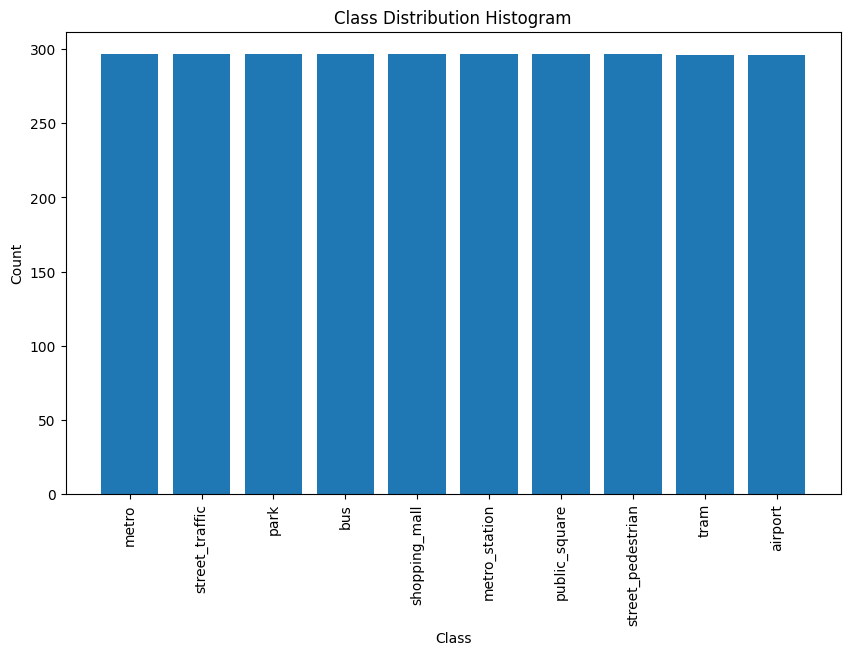

{'metro': 297,
 'tram': 296,
 'street_traffic': 297,
 'park': 297,
 'bus': 297,
 'shopping_mall': 297,
 'metro_station': 297,
 'airport': 296,
 'public_square': 297,
 'street_pedestrian': 297}

In [100]:
reverse=encoder.inverse_transform(y_test_one_hot_encoded)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst,kk='test')

# BLOCK-1

**TRAIN**

In [101]:
Block_number=1


In [102]:
# print(f'embedding{Block_number}')
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)


In [103]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [104]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


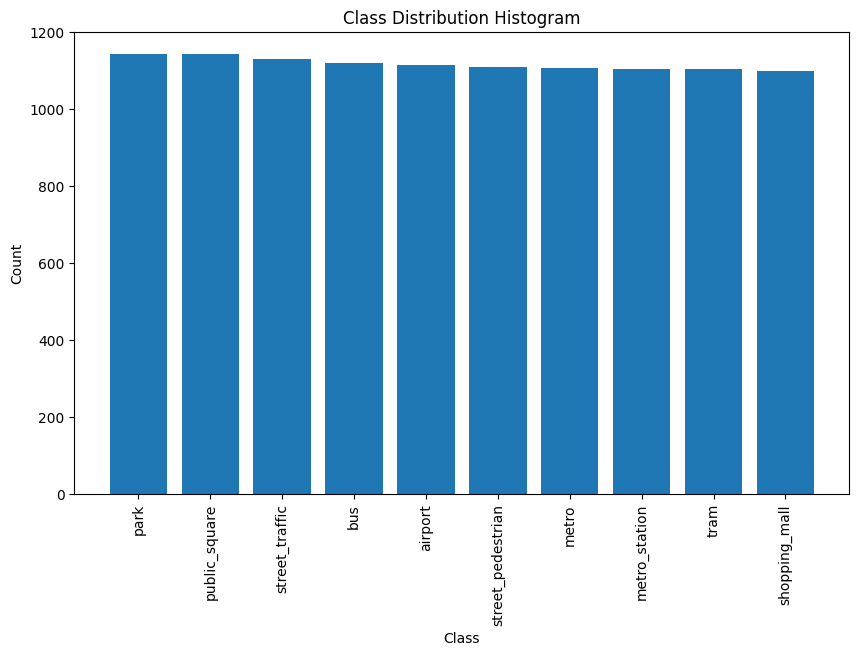

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [105]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


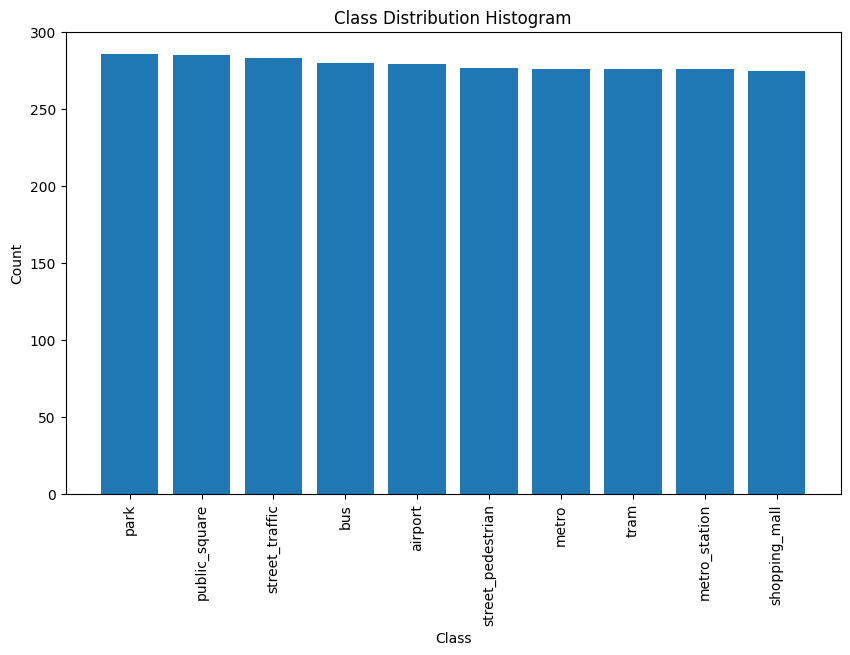

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [106]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [107]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [108]:
X_train_tensor.shape

torch.Size([11169, 768])

In [109]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [110]:
criterion_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 308.33batch/s, acc=0.156, loss=3.29] 


Epoch 0 validation: Cross-entropy=2.28, Accuracy=17.5%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 416.45batch/s, acc=0.172, loss=3.27] 


Epoch 1 validation: Cross-entropy=2.26, Accuracy=17.2%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 245.89batch/s, acc=0.172, loss=3.26] 


Epoch 2 validation: Cross-entropy=2.24, Accuracy=17.3%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 414.15batch/s, acc=0.172, loss=3.24] 


Epoch 3 validation: Cross-entropy=2.22, Accuracy=17.3%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 333.24batch/s, acc=0.172, loss=3.21] 


Epoch 4 validation: Cross-entropy=2.20, Accuracy=18.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 407.13batch/s, acc=0.156, loss=3.19] 


Epoch 5 validation: Cross-entropy=2.18, Accuracy=18.6%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 299.32batch/s, acc=0.156, loss=3.16] 


Epoch 6 validation: Cross-entropy=2.16, Accuracy=19.4%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 400.56batch/s, acc=0.188, loss=3.14] 


Epoch 7 validation: Cross-entropy=2.15, Accuracy=20.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 339.93batch/s, acc=0.203, loss=3.13] 


Epoch 8 validation: Cross-entropy=2.14, Accuracy=20.3%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 409.09batch/s, acc=0.203, loss=3.11] 


Epoch 9 validation: Cross-entropy=2.14, Accuracy=20.5%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 394.82batch/s, acc=0.25, loss=3.1]   


Epoch 10 validation: Cross-entropy=2.13, Accuracy=20.8%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 358.57batch/s, acc=0.266, loss=3.09] 


Epoch 11 validation: Cross-entropy=2.12, Accuracy=21.1%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 412.15batch/s, acc=0.266, loss=3.08] 


Epoch 12 validation: Cross-entropy=2.12, Accuracy=21.5%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 291.12batch/s, acc=0.266, loss=3.07] 


Epoch 13 validation: Cross-entropy=2.11, Accuracy=21.8%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 409.02batch/s, acc=0.266, loss=3.06]


Epoch 14 validation: Cross-entropy=2.11, Accuracy=22.1%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 332.56batch/s, acc=0.266, loss=3.06]


Epoch 15 validation: Cross-entropy=2.11, Accuracy=22.1%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 402.70batch/s, acc=0.266, loss=3.05] 


Epoch 16 validation: Cross-entropy=2.10, Accuracy=22.0%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 337.67batch/s, acc=0.266, loss=3.05] 


Epoch 17 validation: Cross-entropy=2.10, Accuracy=22.0%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 331.56batch/s, acc=0.266, loss=3.04] 


Epoch 18 validation: Cross-entropy=2.10, Accuracy=21.9%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 346.77batch/s, acc=0.266, loss=3.04] 


Epoch 19 validation: Cross-entropy=2.10, Accuracy=22.1%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 344.44batch/s, acc=0.281, loss=3.03] 


Epoch 20 validation: Cross-entropy=2.09, Accuracy=22.1%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 330.51batch/s, acc=0.281, loss=3.03] 


Epoch 21 validation: Cross-entropy=2.09, Accuracy=22.4%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 421.92batch/s, acc=0.281, loss=3.03] 


Epoch 22 validation: Cross-entropy=2.09, Accuracy=22.7%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 339.90batch/s, acc=0.281, loss=3.02] 


Epoch 23 validation: Cross-entropy=2.09, Accuracy=22.6%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 336.76batch/s, acc=0.281, loss=3.02] 


Epoch 24 validation: Cross-entropy=2.08, Accuracy=22.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 418.73batch/s, acc=0.297, loss=3.02] 


Epoch 25 validation: Cross-entropy=2.08, Accuracy=22.8%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 342.96batch/s, acc=0.312, loss=3.01] 


Epoch 26 validation: Cross-entropy=2.08, Accuracy=22.9%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 351.33batch/s, acc=0.312, loss=3.01]


Epoch 27 validation: Cross-entropy=2.08, Accuracy=22.9%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 325.50batch/s, acc=0.312, loss=3.01]


Epoch 28 validation: Cross-entropy=2.08, Accuracy=23.0%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 334.75batch/s, acc=0.312, loss=3.01]


Epoch 29 validation: Cross-entropy=2.08, Accuracy=23.0%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 418.45batch/s, acc=0.312, loss=3]   


Epoch 30 validation: Cross-entropy=2.07, Accuracy=23.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 326.35batch/s, acc=0.328, loss=3]   


Epoch 31 validation: Cross-entropy=2.07, Accuracy=23.2%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 335.96batch/s, acc=0.328, loss=3]   


Epoch 32 validation: Cross-entropy=2.07, Accuracy=23.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 396.67batch/s, acc=0.328, loss=3]   


Epoch 33 validation: Cross-entropy=2.07, Accuracy=23.4%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 299.19batch/s, acc=0.328, loss=2.99]


Epoch 34 validation: Cross-entropy=2.07, Accuracy=23.5%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 397.26batch/s, acc=0.328, loss=2.99]


Epoch 35 validation: Cross-entropy=2.07, Accuracy=23.5%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 337.40batch/s, acc=0.328, loss=2.99]


Epoch 36 validation: Cross-entropy=2.07, Accuracy=23.6%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 335.68batch/s, acc=0.328, loss=2.99]


Epoch 37 validation: Cross-entropy=2.06, Accuracy=23.6%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 417.21batch/s, acc=0.328, loss=2.99]


Epoch 38 validation: Cross-entropy=2.06, Accuracy=23.6%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 341.53batch/s, acc=0.328, loss=2.98]


Epoch 39 validation: Cross-entropy=2.06, Accuracy=23.6%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 357.60batch/s, acc=0.328, loss=2.98]


Epoch 40 validation: Cross-entropy=2.06, Accuracy=23.6%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 383.93batch/s, acc=0.328, loss=2.98]


Epoch 41 validation: Cross-entropy=2.06, Accuracy=23.7%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 304.03batch/s, acc=0.328, loss=2.98]


Epoch 42 validation: Cross-entropy=2.06, Accuracy=23.8%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 411.23batch/s, acc=0.328, loss=2.98]


Epoch 43 validation: Cross-entropy=2.06, Accuracy=23.8%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 340.82batch/s, acc=0.328, loss=2.98]


Epoch 44 validation: Cross-entropy=2.05, Accuracy=23.9%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 417.88batch/s, acc=0.328, loss=2.97]


Epoch 45 validation: Cross-entropy=2.05, Accuracy=23.8%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 336.59batch/s, acc=0.328, loss=2.97]


Epoch 46 validation: Cross-entropy=2.05, Accuracy=24.0%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 424.78batch/s, acc=0.344, loss=2.97]


Epoch 47 validation: Cross-entropy=2.05, Accuracy=24.0%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 342.09batch/s, acc=0.344, loss=2.97]


Epoch 48 validation: Cross-entropy=2.05, Accuracy=24.0%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 345.35batch/s, acc=0.344, loss=2.97]


Epoch 49 validation: Cross-entropy=2.05, Accuracy=24.3%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 343.38batch/s, acc=0.359, loss=2.97]


Epoch 50 validation: Cross-entropy=2.05, Accuracy=24.2%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 416.74batch/s, acc=0.359, loss=2.97]


Epoch 51 validation: Cross-entropy=2.05, Accuracy=24.4%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 351.96batch/s, acc=0.359, loss=2.96]


Epoch 52 validation: Cross-entropy=2.04, Accuracy=24.3%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 346.85batch/s, acc=0.359, loss=2.96]


Epoch 53 validation: Cross-entropy=2.04, Accuracy=24.4%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 418.13batch/s, acc=0.359, loss=2.96]


Epoch 54 validation: Cross-entropy=2.04, Accuracy=24.3%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 343.61batch/s, acc=0.359, loss=2.96]


Epoch 55 validation: Cross-entropy=2.04, Accuracy=24.3%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 288.90batch/s, acc=0.359, loss=2.96]


Epoch 56 validation: Cross-entropy=2.04, Accuracy=24.5%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 398.86batch/s, acc=0.359, loss=2.96]


Epoch 57 validation: Cross-entropy=2.04, Accuracy=24.7%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 349.64batch/s, acc=0.359, loss=2.96]


Epoch 58 validation: Cross-entropy=2.04, Accuracy=24.7%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 424.97batch/s, acc=0.359, loss=2.96]


Epoch 59 validation: Cross-entropy=2.04, Accuracy=24.7%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 349.01batch/s, acc=0.359, loss=2.96]


Epoch 60 validation: Cross-entropy=2.03, Accuracy=24.8%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 421.00batch/s, acc=0.359, loss=2.95]


Epoch 61 validation: Cross-entropy=2.03, Accuracy=24.8%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 344.37batch/s, acc=0.359, loss=2.95]


Epoch 62 validation: Cross-entropy=2.03, Accuracy=24.6%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 354.78batch/s, acc=0.359, loss=2.95]


Epoch 63 validation: Cross-entropy=2.03, Accuracy=24.9%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 374.59batch/s, acc=0.359, loss=2.95]


Epoch 64 validation: Cross-entropy=2.03, Accuracy=25.0%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 384.89batch/s, acc=0.359, loss=2.95]


Epoch 65 validation: Cross-entropy=2.03, Accuracy=25.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 424.45batch/s, acc=0.375, loss=2.95]


Epoch 66 validation: Cross-entropy=2.03, Accuracy=25.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 344.54batch/s, acc=0.375, loss=2.95]


Epoch 67 validation: Cross-entropy=2.03, Accuracy=25.2%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 413.98batch/s, acc=0.375, loss=2.95]


Epoch 68 validation: Cross-entropy=2.03, Accuracy=25.1%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 343.66batch/s, acc=0.375, loss=2.95]


Epoch 69 validation: Cross-entropy=2.02, Accuracy=25.0%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 289.16batch/s, acc=0.375, loss=2.95]


Epoch 70 validation: Cross-entropy=2.02, Accuracy=25.0%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 418.54batch/s, acc=0.391, loss=2.94]


Epoch 71 validation: Cross-entropy=2.02, Accuracy=25.0%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 339.24batch/s, acc=0.391, loss=2.94]


Epoch 72 validation: Cross-entropy=2.02, Accuracy=25.1%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 345.95batch/s, acc=0.391, loss=2.94]


Epoch 73 validation: Cross-entropy=2.02, Accuracy=25.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 420.26batch/s, acc=0.406, loss=2.94]


Epoch 74 validation: Cross-entropy=2.02, Accuracy=25.2%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 346.35batch/s, acc=0.406, loss=2.94]


Epoch 75 validation: Cross-entropy=2.02, Accuracy=25.1%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 423.69batch/s, acc=0.406, loss=2.94]


Epoch 76 validation: Cross-entropy=2.02, Accuracy=25.3%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 339.67batch/s, acc=0.406, loss=2.94]


Epoch 77 validation: Cross-entropy=2.02, Accuracy=25.4%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 300.49batch/s, acc=0.406, loss=2.94]


Epoch 78 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 419.16batch/s, acc=0.406, loss=2.94]


Epoch 79 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 341.39batch/s, acc=0.422, loss=2.94]


Epoch 80 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 423.70batch/s, acc=0.422, loss=2.94]


Epoch 81 validation: Cross-entropy=2.01, Accuracy=25.7%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 343.73batch/s, acc=0.422, loss=2.93]


Epoch 82 validation: Cross-entropy=2.01, Accuracy=25.5%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 329.75batch/s, acc=0.422, loss=2.93]


Epoch 83 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 414.59batch/s, acc=0.422, loss=2.93]


Epoch 84 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 271.98batch/s, acc=0.406, loss=2.93]


Epoch 85 validation: Cross-entropy=2.01, Accuracy=25.7%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 404.80batch/s, acc=0.406, loss=2.93]


Epoch 86 validation: Cross-entropy=2.01, Accuracy=25.7%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 319.16batch/s, acc=0.391, loss=2.93]


Epoch 87 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 324.27batch/s, acc=0.406, loss=2.93]


Epoch 88 validation: Cross-entropy=2.01, Accuracy=25.6%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 398.54batch/s, acc=0.375, loss=2.93]


Epoch 89 validation: Cross-entropy=2.00, Accuracy=25.6%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 402.53batch/s, acc=0.391, loss=2.93]


Epoch 90 validation: Cross-entropy=2.00, Accuracy=25.9%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 320.18batch/s, acc=0.391, loss=2.93]


Epoch 91 validation: Cross-entropy=2.00, Accuracy=25.8%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 333.37batch/s, acc=0.375, loss=2.92]


Epoch 92 validation: Cross-entropy=2.00, Accuracy=25.9%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 318.44batch/s, acc=0.391, loss=2.92]


Epoch 93 validation: Cross-entropy=2.00, Accuracy=25.8%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 376.70batch/s, acc=0.375, loss=2.92]


Epoch 94 validation: Cross-entropy=2.00, Accuracy=25.8%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 319.33batch/s, acc=0.375, loss=2.92]


Epoch 95 validation: Cross-entropy=2.00, Accuracy=25.9%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 335.97batch/s, acc=0.375, loss=2.92]


Epoch 96 validation: Cross-entropy=2.00, Accuracy=25.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 274.38batch/s, acc=0.359, loss=2.92]


Epoch 97 validation: Cross-entropy=2.00, Accuracy=26.1%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 274.39batch/s, acc=0.359, loss=2.92]


Epoch 98 validation: Cross-entropy=2.00, Accuracy=26.0%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 269.38batch/s, acc=0.359, loss=2.92]


Epoch 99 validation: Cross-entropy=2.00, Accuracy=26.1%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 354.94batch/s, acc=0.359, loss=2.92]


Epoch 100 validation: Cross-entropy=2.00, Accuracy=26.1%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 266.72batch/s, acc=0.328, loss=2.92]


Epoch 101 validation: Cross-entropy=2.00, Accuracy=26.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 367.23batch/s, acc=0.344, loss=2.92]


Epoch 102 validation: Cross-entropy=1.99, Accuracy=26.0%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 330.68batch/s, acc=0.344, loss=2.92]


Epoch 103 validation: Cross-entropy=1.99, Accuracy=26.0%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 414.87batch/s, acc=0.344, loss=2.92]


Epoch 104 validation: Cross-entropy=1.99, Accuracy=26.0%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 288.25batch/s, acc=0.344, loss=2.91]


Epoch 105 validation: Cross-entropy=1.99, Accuracy=25.9%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 416.07batch/s, acc=0.344, loss=2.91]


Epoch 106 validation: Cross-entropy=1.99, Accuracy=26.0%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 346.70batch/s, acc=0.344, loss=2.91]


Epoch 107 validation: Cross-entropy=1.99, Accuracy=26.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 418.04batch/s, acc=0.344, loss=2.91]


Epoch 108 validation: Cross-entropy=1.99, Accuracy=26.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 351.00batch/s, acc=0.344, loss=2.91]


Epoch 109 validation: Cross-entropy=1.99, Accuracy=25.9%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 401.57batch/s, acc=0.344, loss=2.91]


Epoch 110 validation: Cross-entropy=1.99, Accuracy=25.9%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 417.10batch/s, acc=0.344, loss=2.91]


Epoch 111 validation: Cross-entropy=1.99, Accuracy=26.1%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 341.95batch/s, acc=0.344, loss=2.91]


Epoch 112 validation: Cross-entropy=1.99, Accuracy=26.1%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 411.14batch/s, acc=0.359, loss=2.91]


Epoch 113 validation: Cross-entropy=1.99, Accuracy=26.2%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 331.86batch/s, acc=0.359, loss=2.91]


Epoch 114 validation: Cross-entropy=1.99, Accuracy=26.3%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 333.24batch/s, acc=0.359, loss=2.91]


Epoch 115 validation: Cross-entropy=1.99, Accuracy=26.2%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 344.94batch/s, acc=0.359, loss=2.91]


Epoch 116 validation: Cross-entropy=1.99, Accuracy=26.4%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 422.45batch/s, acc=0.359, loss=2.9] 


Epoch 117 validation: Cross-entropy=1.99, Accuracy=26.3%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 329.59batch/s, acc=0.359, loss=2.9] 


Epoch 118 validation: Cross-entropy=1.98, Accuracy=26.4%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 424.33batch/s, acc=0.359, loss=2.9] 


Epoch 119 validation: Cross-entropy=1.98, Accuracy=26.6%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 340.46batch/s, acc=0.359, loss=2.9] 


Epoch 120 validation: Cross-entropy=1.98, Accuracy=26.7%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 415.90batch/s, acc=0.359, loss=2.9] 


Epoch 121 validation: Cross-entropy=1.98, Accuracy=26.7%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 292.26batch/s, acc=0.359, loss=2.9] 


Epoch 122 validation: Cross-entropy=1.98, Accuracy=26.6%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 348.60batch/s, acc=0.359, loss=2.9] 


Epoch 123 validation: Cross-entropy=1.98, Accuracy=26.7%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 391.64batch/s, acc=0.359, loss=2.9] 


Epoch 124 validation: Cross-entropy=1.98, Accuracy=26.8%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 339.43batch/s, acc=0.359, loss=2.9] 


Epoch 125 validation: Cross-entropy=1.98, Accuracy=26.8%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 421.95batch/s, acc=0.359, loss=2.9] 


Epoch 126 validation: Cross-entropy=1.98, Accuracy=27.0%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 346.28batch/s, acc=0.359, loss=2.9] 


Epoch 127 validation: Cross-entropy=1.98, Accuracy=27.1%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 346.77batch/s, acc=0.359, loss=2.9] 


Epoch 128 validation: Cross-entropy=1.98, Accuracy=27.1%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 338.69batch/s, acc=0.359, loss=2.9] 


Epoch 129 validation: Cross-entropy=1.98, Accuracy=27.1%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 343.55batch/s, acc=0.359, loss=2.9] 


Epoch 130 validation: Cross-entropy=1.98, Accuracy=27.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 358.23batch/s, acc=0.359, loss=2.9] 


Epoch 131 validation: Cross-entropy=1.98, Accuracy=27.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 388.79batch/s, acc=0.359, loss=2.9] 


Epoch 132 validation: Cross-entropy=1.98, Accuracy=27.2%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 343.82batch/s, acc=0.359, loss=2.89]


Epoch 133 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 402.91batch/s, acc=0.359, loss=2.89]


Epoch 134 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 347.43batch/s, acc=0.359, loss=2.89]


Epoch 135 validation: Cross-entropy=1.98, Accuracy=27.5%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 346.03batch/s, acc=0.359, loss=2.89]


Epoch 136 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 341.04batch/s, acc=0.375, loss=2.89]


Epoch 137 validation: Cross-entropy=1.97, Accuracy=27.4%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 426.59batch/s, acc=0.375, loss=2.89]


Epoch 138 validation: Cross-entropy=1.97, Accuracy=27.4%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 347.47batch/s, acc=0.375, loss=2.89]


Epoch 139 validation: Cross-entropy=1.97, Accuracy=27.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 347.39batch/s, acc=0.375, loss=2.89]


Epoch 140 validation: Cross-entropy=1.97, Accuracy=27.4%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 416.69batch/s, acc=0.375, loss=2.89]


Epoch 141 validation: Cross-entropy=1.97, Accuracy=27.4%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 344.76batch/s, acc=0.375, loss=2.89]


Epoch 142 validation: Cross-entropy=1.97, Accuracy=27.3%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 287.99batch/s, acc=0.375, loss=2.89]


Epoch 143 validation: Cross-entropy=1.97, Accuracy=27.2%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 412.00batch/s, acc=0.375, loss=2.89]


Epoch 144 validation: Cross-entropy=1.97, Accuracy=27.6%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 340.83batch/s, acc=0.375, loss=2.89]


Epoch 145 validation: Cross-entropy=1.97, Accuracy=27.5%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 412.35batch/s, acc=0.375, loss=2.89]


Epoch 146 validation: Cross-entropy=1.97, Accuracy=27.5%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 333.61batch/s, acc=0.375, loss=2.89]


Epoch 147 validation: Cross-entropy=1.97, Accuracy=27.5%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 363.29batch/s, acc=0.375, loss=2.89]


Epoch 148 validation: Cross-entropy=1.97, Accuracy=27.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 378.80batch/s, acc=0.391, loss=2.89]


Epoch 149 validation: Cross-entropy=1.97, Accuracy=27.5%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 296.74batch/s, acc=0.391, loss=2.89]


Epoch 150 validation: Cross-entropy=1.97, Accuracy=27.6%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 401.27batch/s, acc=0.391, loss=2.88]


Epoch 151 validation: Cross-entropy=1.97, Accuracy=27.7%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 338.30batch/s, acc=0.391, loss=2.88]


Epoch 152 validation: Cross-entropy=1.97, Accuracy=27.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 348.90batch/s, acc=0.391, loss=2.88]


Epoch 153 validation: Cross-entropy=1.97, Accuracy=27.6%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 406.03batch/s, acc=0.391, loss=2.88]


Epoch 154 validation: Cross-entropy=1.97, Accuracy=27.9%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 330.06batch/s, acc=0.391, loss=2.88]


Epoch 155 validation: Cross-entropy=1.96, Accuracy=27.9%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 400.77batch/s, acc=0.391, loss=2.88]


Epoch 156 validation: Cross-entropy=1.96, Accuracy=27.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 292.42batch/s, acc=0.391, loss=2.88]


Epoch 157 validation: Cross-entropy=1.96, Accuracy=27.8%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 333.55batch/s, acc=0.391, loss=2.88]


Epoch 158 validation: Cross-entropy=1.96, Accuracy=27.7%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 424.10batch/s, acc=0.391, loss=2.88]


Epoch 159 validation: Cross-entropy=1.96, Accuracy=27.8%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 337.76batch/s, acc=0.391, loss=2.88]


Epoch 160 validation: Cross-entropy=1.96, Accuracy=27.8%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 341.38batch/s, acc=0.391, loss=2.88]


Epoch 161 validation: Cross-entropy=1.96, Accuracy=27.9%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 418.02batch/s, acc=0.391, loss=2.88]


Epoch 162 validation: Cross-entropy=1.96, Accuracy=28.0%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 353.26batch/s, acc=0.391, loss=2.88]


Epoch 163 validation: Cross-entropy=1.96, Accuracy=28.0%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 425.73batch/s, acc=0.391, loss=2.88]


Epoch 164 validation: Cross-entropy=1.96, Accuracy=28.0%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 292.82batch/s, acc=0.391, loss=2.88]


Epoch 165 validation: Cross-entropy=1.96, Accuracy=28.2%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 347.59batch/s, acc=0.391, loss=2.88]


Epoch 166 validation: Cross-entropy=1.96, Accuracy=28.3%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 415.99batch/s, acc=0.391, loss=2.88]


Epoch 167 validation: Cross-entropy=1.96, Accuracy=28.3%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 344.35batch/s, acc=0.391, loss=2.88]


Epoch 168 validation: Cross-entropy=1.96, Accuracy=28.2%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 421.37batch/s, acc=0.391, loss=2.88]


Epoch 169 validation: Cross-entropy=1.96, Accuracy=28.3%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 343.25batch/s, acc=0.391, loss=2.88]


Epoch 170 validation: Cross-entropy=1.96, Accuracy=28.4%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 373.73batch/s, acc=0.391, loss=2.88]


Epoch 171 validation: Cross-entropy=1.96, Accuracy=28.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 312.13batch/s, acc=0.391, loss=2.88]


Epoch 172 validation: Cross-entropy=1.95, Accuracy=28.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 344.77batch/s, acc=0.391, loss=2.87]


Epoch 173 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 421.73batch/s, acc=0.391, loss=2.87]


Epoch 174 validation: Cross-entropy=1.95, Accuracy=28.2%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 344.74batch/s, acc=0.391, loss=2.87]


Epoch 175 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 413.54batch/s, acc=0.391, loss=2.87]


Epoch 176 validation: Cross-entropy=1.95, Accuracy=28.4%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 348.14batch/s, acc=0.391, loss=2.87]


Epoch 177 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 413.50batch/s, acc=0.391, loss=2.87]


Epoch 178 validation: Cross-entropy=1.95, Accuracy=28.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 290.91batch/s, acc=0.391, loss=2.87]


Epoch 179 validation: Cross-entropy=1.95, Accuracy=28.6%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 338.58batch/s, acc=0.391, loss=2.87]


Epoch 180 validation: Cross-entropy=1.95, Accuracy=28.7%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 422.95batch/s, acc=0.391, loss=2.87]


Epoch 181 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 345.38batch/s, acc=0.391, loss=2.87]


Epoch 182 validation: Cross-entropy=1.95, Accuracy=28.7%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 349.13batch/s, acc=0.391, loss=2.87]


Epoch 183 validation: Cross-entropy=1.95, Accuracy=28.7%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 417.61batch/s, acc=0.375, loss=2.87]


Epoch 184 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 337.05batch/s, acc=0.375, loss=2.87]


Epoch 185 validation: Cross-entropy=1.95, Accuracy=28.7%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 346.33batch/s, acc=0.375, loss=2.87]


Epoch 186 validation: Cross-entropy=1.95, Accuracy=28.7%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 348.80batch/s, acc=0.375, loss=2.87]


Epoch 187 validation: Cross-entropy=1.95, Accuracy=28.8%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 343.01batch/s, acc=0.375, loss=2.87]


Epoch 188 validation: Cross-entropy=1.95, Accuracy=28.8%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 417.12batch/s, acc=0.375, loss=2.87]


Epoch 189 validation: Cross-entropy=1.94, Accuracy=28.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 346.08batch/s, acc=0.375, loss=2.87]


Epoch 190 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 348.69batch/s, acc=0.375, loss=2.87]


Epoch 191 validation: Cross-entropy=1.94, Accuracy=28.9%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 412.47batch/s, acc=0.375, loss=2.87]


Epoch 192 validation: Cross-entropy=1.94, Accuracy=28.8%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 295.17batch/s, acc=0.375, loss=2.87]


Epoch 193 validation: Cross-entropy=1.94, Accuracy=29.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 411.54batch/s, acc=0.375, loss=2.87]


Epoch 194 validation: Cross-entropy=1.94, Accuracy=29.1%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 352.82batch/s, acc=0.375, loss=2.87]


Epoch 195 validation: Cross-entropy=1.94, Accuracy=29.0%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 425.42batch/s, acc=0.375, loss=2.86]


Epoch 196 validation: Cross-entropy=1.94, Accuracy=29.0%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 350.55batch/s, acc=0.375, loss=2.86]


Epoch 197 validation: Cross-entropy=1.94, Accuracy=29.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 366.45batch/s, acc=0.375, loss=2.86]


Epoch 198 validation: Cross-entropy=1.94, Accuracy=29.1%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 413.76batch/s, acc=0.375, loss=2.86]


Epoch 199 validation: Cross-entropy=1.94, Accuracy=29.2%


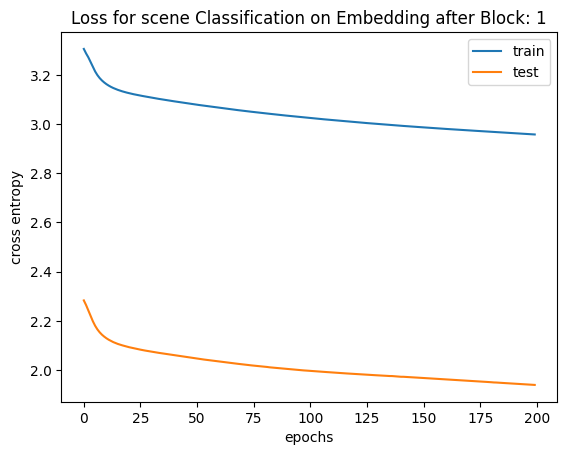

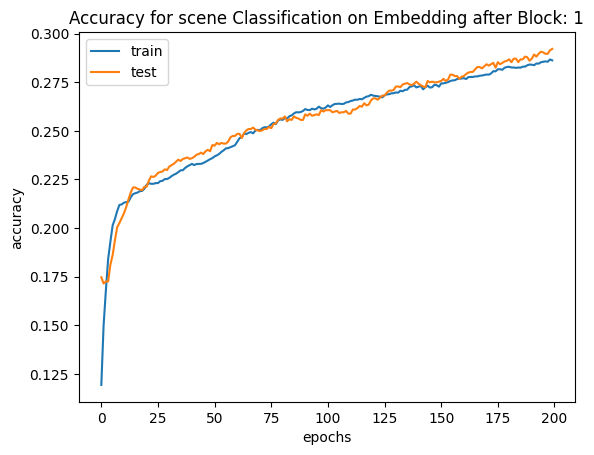

In [111]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            # print(loss_ce,loss_op)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [112]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [113]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [114]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [115]:
X_test=train_ready(test_data,col_name)

In [116]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
    
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

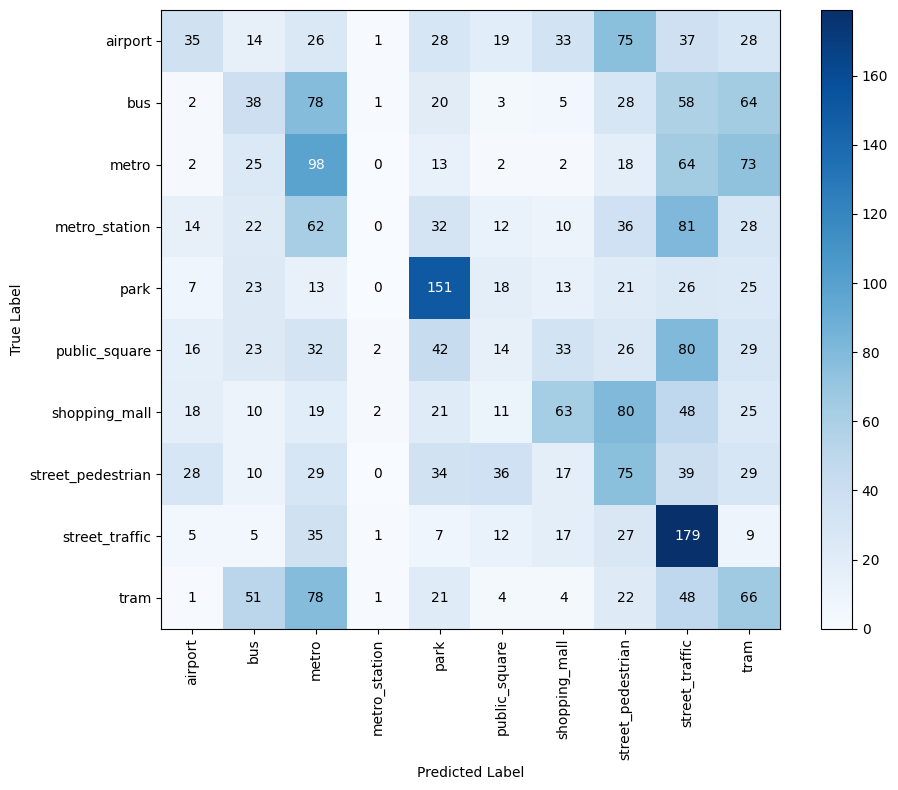

Accuracy: 0.2423


In [117]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-2

In [118]:
Block_number=2

In [119]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [120]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [121]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


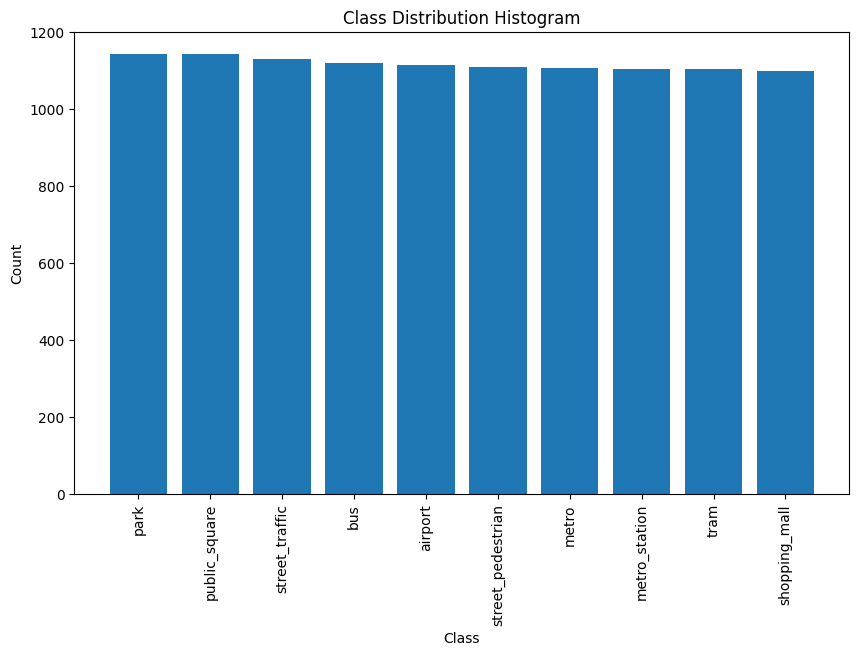

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [122]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


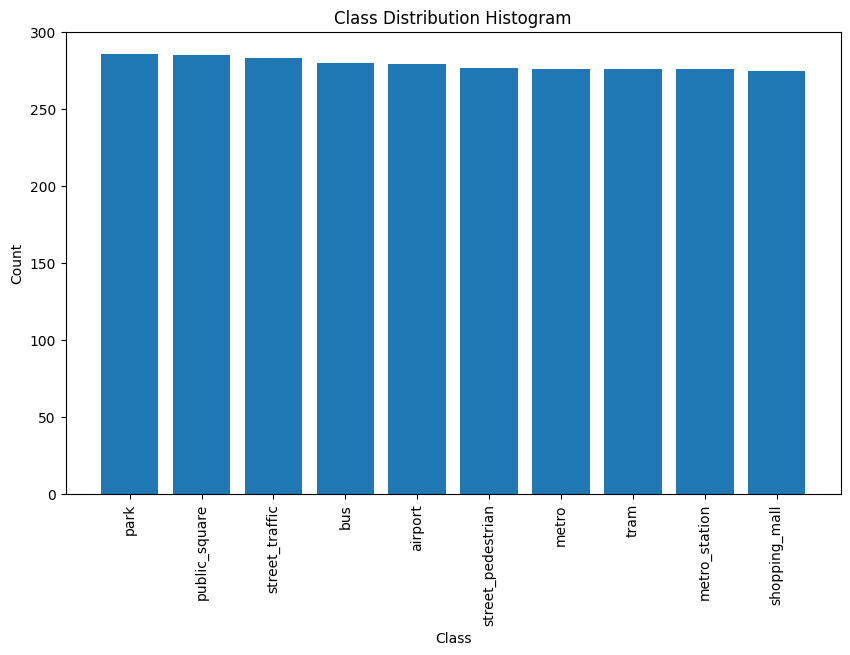

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [123]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [124]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [125]:
X_train_tensor.shape

torch.Size([11169, 768])

In [126]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 284.74batch/s, acc=0.219, loss=3.25] 


Epoch 0 validation: Cross-entropy=2.23, Accuracy=24.0%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 312.11batch/s, acc=0.266, loss=3.19]


Epoch 1 validation: Cross-entropy=2.16, Accuracy=25.7%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 388.83batch/s, acc=0.266, loss=3.11]


Epoch 2 validation: Cross-entropy=2.09, Accuracy=28.6%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 325.89batch/s, acc=0.281, loss=3.04]


Epoch 3 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 387.07batch/s, acc=0.281, loss=2.98]


Epoch 4 validation: Cross-entropy=1.95, Accuracy=33.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 316.41batch/s, acc=0.297, loss=2.92]


Epoch 5 validation: Cross-entropy=1.90, Accuracy=34.6%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 391.23batch/s, acc=0.297, loss=2.88]


Epoch 6 validation: Cross-entropy=1.85, Accuracy=35.6%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 322.44batch/s, acc=0.328, loss=2.85]


Epoch 7 validation: Cross-entropy=1.81, Accuracy=36.6%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 396.78batch/s, acc=0.328, loss=2.82]


Epoch 8 validation: Cross-entropy=1.78, Accuracy=37.6%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 330.85batch/s, acc=0.328, loss=2.8] 


Epoch 9 validation: Cross-entropy=1.76, Accuracy=38.2%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 386.41batch/s, acc=0.328, loss=2.78]


Epoch 10 validation: Cross-entropy=1.73, Accuracy=38.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 348.51batch/s, acc=0.328, loss=2.77]


Epoch 11 validation: Cross-entropy=1.72, Accuracy=39.0%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 303.07batch/s, acc=0.328, loss=2.76]


Epoch 12 validation: Cross-entropy=1.70, Accuracy=39.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 325.62batch/s, acc=0.328, loss=2.75]


Epoch 13 validation: Cross-entropy=1.68, Accuracy=40.4%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 383.43batch/s, acc=0.344, loss=2.74]


Epoch 14 validation: Cross-entropy=1.67, Accuracy=40.8%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 325.76batch/s, acc=0.344, loss=2.73]


Epoch 15 validation: Cross-entropy=1.65, Accuracy=41.2%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 389.68batch/s, acc=0.344, loss=2.72]


Epoch 16 validation: Cross-entropy=1.64, Accuracy=41.5%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 321.91batch/s, acc=0.344, loss=2.71]


Epoch 17 validation: Cross-entropy=1.63, Accuracy=41.7%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 323.62batch/s, acc=0.344, loss=2.7] 


Epoch 18 validation: Cross-entropy=1.62, Accuracy=42.3%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 396.83batch/s, acc=0.359, loss=2.7] 


Epoch 19 validation: Cross-entropy=1.61, Accuracy=42.6%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 276.67batch/s, acc=0.359, loss=2.69]


Epoch 20 validation: Cross-entropy=1.60, Accuracy=43.0%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 342.78batch/s, acc=0.359, loss=2.68]


Epoch 21 validation: Cross-entropy=1.59, Accuracy=43.5%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 383.62batch/s, acc=0.359, loss=2.68]


Epoch 22 validation: Cross-entropy=1.58, Accuracy=43.9%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 340.06batch/s, acc=0.359, loss=2.67]


Epoch 23 validation: Cross-entropy=1.57, Accuracy=43.9%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 345.64batch/s, acc=0.375, loss=2.66]


Epoch 24 validation: Cross-entropy=1.57, Accuracy=44.0%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 368.84batch/s, acc=0.375, loss=2.66]


Epoch 25 validation: Cross-entropy=1.56, Accuracy=44.3%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 295.44batch/s, acc=0.375, loss=2.66]


Epoch 26 validation: Cross-entropy=1.55, Accuracy=44.4%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 341.55batch/s, acc=0.391, loss=2.65]


Epoch 27 validation: Cross-entropy=1.54, Accuracy=44.6%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 328.13batch/s, acc=0.406, loss=2.65]


Epoch 28 validation: Cross-entropy=1.54, Accuracy=44.7%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 375.59batch/s, acc=0.406, loss=2.64]


Epoch 29 validation: Cross-entropy=1.53, Accuracy=44.9%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 315.75batch/s, acc=0.406, loss=2.64]


Epoch 30 validation: Cross-entropy=1.53, Accuracy=45.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 335.25batch/s, acc=0.406, loss=2.64]


Epoch 31 validation: Cross-entropy=1.52, Accuracy=45.2%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 391.67batch/s, acc=0.406, loss=2.63]


Epoch 32 validation: Cross-entropy=1.52, Accuracy=45.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 319.60batch/s, acc=0.406, loss=2.63]


Epoch 33 validation: Cross-entropy=1.51, Accuracy=45.6%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 290.29batch/s, acc=0.406, loss=2.63]


Epoch 34 validation: Cross-entropy=1.51, Accuracy=45.8%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 389.72batch/s, acc=0.406, loss=2.63]


Epoch 35 validation: Cross-entropy=1.50, Accuracy=45.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 333.56batch/s, acc=0.406, loss=2.62]


Epoch 36 validation: Cross-entropy=1.50, Accuracy=45.9%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 398.50batch/s, acc=0.406, loss=2.62]


Epoch 37 validation: Cross-entropy=1.49, Accuracy=46.1%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 320.44batch/s, acc=0.406, loss=2.62]


Epoch 38 validation: Cross-entropy=1.49, Accuracy=46.3%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 332.79batch/s, acc=0.406, loss=2.61]


Epoch 39 validation: Cross-entropy=1.48, Accuracy=46.5%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 399.65batch/s, acc=0.406, loss=2.61]


Epoch 40 validation: Cross-entropy=1.48, Accuracy=46.7%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 282.32batch/s, acc=0.391, loss=2.61]


Epoch 41 validation: Cross-entropy=1.48, Accuracy=46.8%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 333.29batch/s, acc=0.391, loss=2.61]


Epoch 42 validation: Cross-entropy=1.47, Accuracy=47.1%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 386.42batch/s, acc=0.391, loss=2.6] 


Epoch 43 validation: Cross-entropy=1.47, Accuracy=47.2%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 334.30batch/s, acc=0.406, loss=2.6] 


Epoch 44 validation: Cross-entropy=1.46, Accuracy=47.1%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 389.10batch/s, acc=0.406, loss=2.6] 


Epoch 45 validation: Cross-entropy=1.46, Accuracy=47.4%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 352.85batch/s, acc=0.406, loss=2.6] 


Epoch 46 validation: Cross-entropy=1.46, Accuracy=47.6%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 310.64batch/s, acc=0.391, loss=2.59]


Epoch 47 validation: Cross-entropy=1.45, Accuracy=47.6%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 335.85batch/s, acc=0.391, loss=2.59]


Epoch 48 validation: Cross-entropy=1.45, Accuracy=47.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 306.05batch/s, acc=0.391, loss=2.59]


Epoch 49 validation: Cross-entropy=1.45, Accuracy=47.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 345.00batch/s, acc=0.391, loss=2.59]


Epoch 50 validation: Cross-entropy=1.44, Accuracy=47.8%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 368.21batch/s, acc=0.391, loss=2.58]


Epoch 51 validation: Cross-entropy=1.44, Accuracy=47.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 317.12batch/s, acc=0.391, loss=2.58]


Epoch 52 validation: Cross-entropy=1.44, Accuracy=47.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 380.23batch/s, acc=0.391, loss=2.58]


Epoch 53 validation: Cross-entropy=1.44, Accuracy=47.9%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 325.72batch/s, acc=0.391, loss=2.58]


Epoch 54 validation: Cross-entropy=1.43, Accuracy=47.9%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 295.91batch/s, acc=0.391, loss=2.58]


Epoch 55 validation: Cross-entropy=1.43, Accuracy=48.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 378.35batch/s, acc=0.391, loss=2.57]


Epoch 56 validation: Cross-entropy=1.43, Accuracy=48.1%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 329.49batch/s, acc=0.391, loss=2.57]


Epoch 57 validation: Cross-entropy=1.43, Accuracy=47.9%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 396.28batch/s, acc=0.391, loss=2.57]


Epoch 58 validation: Cross-entropy=1.42, Accuracy=48.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 326.03batch/s, acc=0.391, loss=2.57]


Epoch 59 validation: Cross-entropy=1.42, Accuracy=48.0%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 323.34batch/s, acc=0.391, loss=2.56]


Epoch 60 validation: Cross-entropy=1.42, Accuracy=48.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 403.05batch/s, acc=0.391, loss=2.56]


Epoch 61 validation: Cross-entropy=1.42, Accuracy=48.2%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 323.81batch/s, acc=0.391, loss=2.56]


Epoch 62 validation: Cross-entropy=1.41, Accuracy=48.3%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 284.31batch/s, acc=0.391, loss=2.56]


Epoch 63 validation: Cross-entropy=1.41, Accuracy=48.3%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 412.28batch/s, acc=0.391, loss=2.56]


Epoch 64 validation: Cross-entropy=1.41, Accuracy=48.4%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 322.23batch/s, acc=0.391, loss=2.55]


Epoch 65 validation: Cross-entropy=1.41, Accuracy=48.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 354.37batch/s, acc=0.391, loss=2.55]


Epoch 66 validation: Cross-entropy=1.40, Accuracy=48.4%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 356.97batch/s, acc=0.391, loss=2.55]


Epoch 67 validation: Cross-entropy=1.40, Accuracy=48.6%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 336.99batch/s, acc=0.391, loss=2.55]


Epoch 68 validation: Cross-entropy=1.40, Accuracy=48.7%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 396.86batch/s, acc=0.391, loss=2.55]


Epoch 69 validation: Cross-entropy=1.40, Accuracy=48.7%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 280.23batch/s, acc=0.391, loss=2.55]


Epoch 70 validation: Cross-entropy=1.40, Accuracy=48.7%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 416.02batch/s, acc=0.391, loss=2.54]


Epoch 71 validation: Cross-entropy=1.39, Accuracy=48.5%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 346.12batch/s, acc=0.391, loss=2.54]


Epoch 72 validation: Cross-entropy=1.39, Accuracy=48.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 349.18batch/s, acc=0.391, loss=2.54]


Epoch 73 validation: Cross-entropy=1.39, Accuracy=48.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 380.64batch/s, acc=0.391, loss=2.54]


Epoch 74 validation: Cross-entropy=1.39, Accuracy=49.0%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 320.08batch/s, acc=0.391, loss=2.54]


Epoch 75 validation: Cross-entropy=1.39, Accuracy=49.1%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 322.34batch/s, acc=0.391, loss=2.53]


Epoch 76 validation: Cross-entropy=1.39, Accuracy=49.1%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 325.97batch/s, acc=0.391, loss=2.53]


Epoch 77 validation: Cross-entropy=1.38, Accuracy=49.1%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 324.27batch/s, acc=0.391, loss=2.53]


Epoch 78 validation: Cross-entropy=1.38, Accuracy=49.1%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 397.99batch/s, acc=0.391, loss=2.53]


Epoch 79 validation: Cross-entropy=1.38, Accuracy=49.2%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 319.93batch/s, acc=0.391, loss=2.53]


Epoch 80 validation: Cross-entropy=1.38, Accuracy=49.2%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 398.52batch/s, acc=0.391, loss=2.52]


Epoch 81 validation: Cross-entropy=1.38, Accuracy=49.3%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 324.45batch/s, acc=0.391, loss=2.52]


Epoch 82 validation: Cross-entropy=1.38, Accuracy=49.3%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 333.60batch/s, acc=0.391, loss=2.52]


Epoch 83 validation: Cross-entropy=1.37, Accuracy=49.4%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 284.35batch/s, acc=0.391, loss=2.52]


Epoch 84 validation: Cross-entropy=1.37, Accuracy=49.4%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 376.60batch/s, acc=0.391, loss=2.51]


Epoch 85 validation: Cross-entropy=1.37, Accuracy=49.4%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 324.69batch/s, acc=0.391, loss=2.51]


Epoch 86 validation: Cross-entropy=1.37, Accuracy=49.5%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 400.09batch/s, acc=0.391, loss=2.51]


Epoch 87 validation: Cross-entropy=1.37, Accuracy=49.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 313.51batch/s, acc=0.391, loss=2.51]


Epoch 88 validation: Cross-entropy=1.37, Accuracy=49.5%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 330.88batch/s, acc=0.391, loss=2.51]


Epoch 89 validation: Cross-entropy=1.37, Accuracy=49.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 384.59batch/s, acc=0.391, loss=2.51]


Epoch 90 validation: Cross-entropy=1.36, Accuracy=49.5%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 268.77batch/s, acc=0.406, loss=2.5] 


Epoch 91 validation: Cross-entropy=1.36, Accuracy=49.5%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 319.13batch/s, acc=0.406, loss=2.5] 


Epoch 92 validation: Cross-entropy=1.36, Accuracy=49.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 396.42batch/s, acc=0.406, loss=2.5] 


Epoch 93 validation: Cross-entropy=1.36, Accuracy=49.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 317.41batch/s, acc=0.406, loss=2.5] 


Epoch 94 validation: Cross-entropy=1.36, Accuracy=49.6%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 386.78batch/s, acc=0.406, loss=2.5] 


Epoch 95 validation: Cross-entropy=1.36, Accuracy=49.6%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 321.97batch/s, acc=0.406, loss=2.5] 


Epoch 96 validation: Cross-entropy=1.36, Accuracy=49.7%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 332.06batch/s, acc=0.406, loss=2.49]


Epoch 97 validation: Cross-entropy=1.36, Accuracy=49.6%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 318.50batch/s, acc=0.406, loss=2.49]


Epoch 98 validation: Cross-entropy=1.35, Accuracy=49.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 334.57batch/s, acc=0.406, loss=2.49]


Epoch 99 validation: Cross-entropy=1.35, Accuracy=49.7%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 328.47batch/s, acc=0.406, loss=2.49]


Epoch 100 validation: Cross-entropy=1.35, Accuracy=49.7%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 410.02batch/s, acc=0.406, loss=2.49]


Epoch 101 validation: Cross-entropy=1.35, Accuracy=49.7%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 332.50batch/s, acc=0.406, loss=2.48]


Epoch 102 validation: Cross-entropy=1.35, Accuracy=49.7%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 400.73batch/s, acc=0.406, loss=2.48]


Epoch 103 validation: Cross-entropy=1.35, Accuracy=49.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 320.84batch/s, acc=0.406, loss=2.48]


Epoch 104 validation: Cross-entropy=1.35, Accuracy=49.9%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 274.15batch/s, acc=0.406, loss=2.48]


Epoch 105 validation: Cross-entropy=1.35, Accuracy=49.8%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 401.18batch/s, acc=0.406, loss=2.48]


Epoch 106 validation: Cross-entropy=1.35, Accuracy=49.9%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 322.76batch/s, acc=0.406, loss=2.48]


Epoch 107 validation: Cross-entropy=1.34, Accuracy=50.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 327.85batch/s, acc=0.406, loss=2.48]


Epoch 108 validation: Cross-entropy=1.34, Accuracy=50.2%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 401.15batch/s, acc=0.406, loss=2.47]


Epoch 109 validation: Cross-entropy=1.34, Accuracy=50.4%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 335.36batch/s, acc=0.406, loss=2.47]


Epoch 110 validation: Cross-entropy=1.34, Accuracy=50.5%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 323.82batch/s, acc=0.406, loss=2.47]


Epoch 111 validation: Cross-entropy=1.34, Accuracy=50.4%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 311.51batch/s, acc=0.406, loss=2.47]


Epoch 112 validation: Cross-entropy=1.34, Accuracy=50.4%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 333.85batch/s, acc=0.406, loss=2.47]


Epoch 113 validation: Cross-entropy=1.34, Accuracy=50.6%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 328.92batch/s, acc=0.406, loss=2.47]


Epoch 114 validation: Cross-entropy=1.34, Accuracy=50.7%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 382.97batch/s, acc=0.406, loss=2.46]


Epoch 115 validation: Cross-entropy=1.34, Accuracy=50.7%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 336.38batch/s, acc=0.406, loss=2.46]


Epoch 116 validation: Cross-entropy=1.33, Accuracy=50.7%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 328.22batch/s, acc=0.406, loss=2.46]


Epoch 117 validation: Cross-entropy=1.33, Accuracy=50.7%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 399.67batch/s, acc=0.406, loss=2.46]


Epoch 118 validation: Cross-entropy=1.33, Accuracy=50.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 266.62batch/s, acc=0.406, loss=2.46]


Epoch 119 validation: Cross-entropy=1.33, Accuracy=50.7%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 391.59batch/s, acc=0.406, loss=2.46]


Epoch 120 validation: Cross-entropy=1.33, Accuracy=50.8%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 309.85batch/s, acc=0.406, loss=2.45]


Epoch 121 validation: Cross-entropy=1.33, Accuracy=50.9%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 333.64batch/s, acc=0.406, loss=2.45]


Epoch 122 validation: Cross-entropy=1.33, Accuracy=50.9%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 394.51batch/s, acc=0.406, loss=2.45]


Epoch 123 validation: Cross-entropy=1.33, Accuracy=50.9%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 329.22batch/s, acc=0.406, loss=2.45]


Epoch 124 validation: Cross-entropy=1.33, Accuracy=50.9%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 322.70batch/s, acc=0.406, loss=2.45]


Epoch 125 validation: Cross-entropy=1.33, Accuracy=51.0%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 329.99batch/s, acc=0.406, loss=2.45]


Epoch 126 validation: Cross-entropy=1.32, Accuracy=51.0%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 324.24batch/s, acc=0.406, loss=2.45]


Epoch 127 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 326.59batch/s, acc=0.406, loss=2.44]


Epoch 128 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 407.31batch/s, acc=0.422, loss=2.44]


Epoch 129 validation: Cross-entropy=1.32, Accuracy=51.0%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 325.76batch/s, acc=0.406, loss=2.44]


Epoch 130 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 409.31batch/s, acc=0.406, loss=2.44]


Epoch 131 validation: Cross-entropy=1.32, Accuracy=51.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 327.40batch/s, acc=0.422, loss=2.44]


Epoch 132 validation: Cross-entropy=1.32, Accuracy=51.2%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 272.72batch/s, acc=0.422, loss=2.44]


Epoch 133 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 384.80batch/s, acc=0.422, loss=2.44]


Epoch 134 validation: Cross-entropy=1.32, Accuracy=51.3%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 333.77batch/s, acc=0.438, loss=2.43]


Epoch 135 validation: Cross-entropy=1.32, Accuracy=51.3%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 393.52batch/s, acc=0.438, loss=2.43]


Epoch 136 validation: Cross-entropy=1.32, Accuracy=51.3%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 317.84batch/s, acc=0.438, loss=2.43]


Epoch 137 validation: Cross-entropy=1.32, Accuracy=51.3%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 325.27batch/s, acc=0.438, loss=2.43]


Epoch 138 validation: Cross-entropy=1.31, Accuracy=51.3%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 396.28batch/s, acc=0.438, loss=2.43]


Epoch 139 validation: Cross-entropy=1.31, Accuracy=51.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 279.55batch/s, acc=0.438, loss=2.43]


Epoch 140 validation: Cross-entropy=1.31, Accuracy=51.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 332.80batch/s, acc=0.438, loss=2.43]


Epoch 141 validation: Cross-entropy=1.31, Accuracy=51.5%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 407.03batch/s, acc=0.438, loss=2.42]


Epoch 142 validation: Cross-entropy=1.31, Accuracy=51.6%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 324.97batch/s, acc=0.438, loss=2.42]


Epoch 143 validation: Cross-entropy=1.31, Accuracy=51.6%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 326.86batch/s, acc=0.438, loss=2.42]


Epoch 144 validation: Cross-entropy=1.31, Accuracy=51.5%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 387.73batch/s, acc=0.438, loss=2.42]


Epoch 145 validation: Cross-entropy=1.31, Accuracy=51.6%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 312.98batch/s, acc=0.438, loss=2.42]


Epoch 146 validation: Cross-entropy=1.31, Accuracy=51.6%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 276.72batch/s, acc=0.438, loss=2.42]


Epoch 147 validation: Cross-entropy=1.31, Accuracy=51.7%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 389.84batch/s, acc=0.438, loss=2.42]


Epoch 148 validation: Cross-entropy=1.31, Accuracy=51.7%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 325.04batch/s, acc=0.438, loss=2.41]


Epoch 149 validation: Cross-entropy=1.31, Accuracy=51.7%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 398.99batch/s, acc=0.438, loss=2.41]


Epoch 150 validation: Cross-entropy=1.31, Accuracy=51.7%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 335.54batch/s, acc=0.438, loss=2.41]


Epoch 151 validation: Cross-entropy=1.30, Accuracy=51.7%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 406.09batch/s, acc=0.438, loss=2.41]


Epoch 152 validation: Cross-entropy=1.30, Accuracy=51.8%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 335.42batch/s, acc=0.438, loss=2.41]


Epoch 153 validation: Cross-entropy=1.30, Accuracy=51.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 276.05batch/s, acc=0.438, loss=2.41]


Epoch 154 validation: Cross-entropy=1.30, Accuracy=51.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 397.22batch/s, acc=0.438, loss=2.4] 


Epoch 155 validation: Cross-entropy=1.30, Accuracy=51.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 327.59batch/s, acc=0.438, loss=2.4] 


Epoch 156 validation: Cross-entropy=1.30, Accuracy=51.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 321.64batch/s, acc=0.438, loss=2.4] 


Epoch 157 validation: Cross-entropy=1.30, Accuracy=52.0%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 401.95batch/s, acc=0.438, loss=2.4] 


Epoch 158 validation: Cross-entropy=1.30, Accuracy=52.0%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 328.56batch/s, acc=0.438, loss=2.4] 


Epoch 159 validation: Cross-entropy=1.30, Accuracy=52.0%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 322.24batch/s, acc=0.438, loss=2.4] 


Epoch 160 validation: Cross-entropy=1.30, Accuracy=52.1%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 324.79batch/s, acc=0.438, loss=2.4] 


Epoch 161 validation: Cross-entropy=1.30, Accuracy=52.1%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 323.51batch/s, acc=0.438, loss=2.4] 


Epoch 162 validation: Cross-entropy=1.30, Accuracy=52.2%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 359.88batch/s, acc=0.438, loss=2.39]


Epoch 163 validation: Cross-entropy=1.30, Accuracy=52.2%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 381.66batch/s, acc=0.438, loss=2.39]


Epoch 164 validation: Cross-entropy=1.30, Accuracy=52.2%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 340.46batch/s, acc=0.438, loss=2.39]


Epoch 165 validation: Cross-entropy=1.29, Accuracy=52.2%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 405.58batch/s, acc=0.438, loss=2.39]


Epoch 166 validation: Cross-entropy=1.29, Accuracy=52.3%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 326.70batch/s, acc=0.453, loss=2.39]


Epoch 167 validation: Cross-entropy=1.29, Accuracy=52.2%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 340.57batch/s, acc=0.453, loss=2.39]


Epoch 168 validation: Cross-entropy=1.29, Accuracy=52.3%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 305.47batch/s, acc=0.453, loss=2.39]


Epoch 169 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 330.92batch/s, acc=0.453, loss=2.38]


Epoch 170 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 377.52batch/s, acc=0.453, loss=2.38]


Epoch 171 validation: Cross-entropy=1.29, Accuracy=52.3%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 308.87batch/s, acc=0.453, loss=2.38]


Epoch 172 validation: Cross-entropy=1.29, Accuracy=52.3%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 334.10batch/s, acc=0.453, loss=2.38]


Epoch 173 validation: Cross-entropy=1.29, Accuracy=52.2%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 380.18batch/s, acc=0.453, loss=2.38]


Epoch 174 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 284.40batch/s, acc=0.469, loss=2.38]


Epoch 175 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 327.10batch/s, acc=0.469, loss=2.38]


Epoch 176 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 380.08batch/s, acc=0.453, loss=2.38]


Epoch 177 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 328.97batch/s, acc=0.469, loss=2.37]


Epoch 178 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 409.37batch/s, acc=0.453, loss=2.37]


Epoch 179 validation: Cross-entropy=1.29, Accuracy=52.4%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 329.60batch/s, acc=0.453, loss=2.37]


Epoch 180 validation: Cross-entropy=1.29, Accuracy=52.3%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 400.02batch/s, acc=0.453, loss=2.37]


Epoch 181 validation: Cross-entropy=1.28, Accuracy=52.3%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 294.90batch/s, acc=0.453, loss=2.37]


Epoch 182 validation: Cross-entropy=1.28, Accuracy=52.3%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 323.91batch/s, acc=0.469, loss=2.37]


Epoch 183 validation: Cross-entropy=1.28, Accuracy=52.3%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 395.49batch/s, acc=0.484, loss=2.37]


Epoch 184 validation: Cross-entropy=1.28, Accuracy=52.5%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 324.86batch/s, acc=0.469, loss=2.37]


Epoch 185 validation: Cross-entropy=1.28, Accuracy=52.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 331.22batch/s, acc=0.484, loss=2.36]


Epoch 186 validation: Cross-entropy=1.28, Accuracy=52.5%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 406.18batch/s, acc=0.484, loss=2.36]


Epoch 187 validation: Cross-entropy=1.28, Accuracy=52.6%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 337.04batch/s, acc=0.469, loss=2.36]


Epoch 188 validation: Cross-entropy=1.28, Accuracy=52.5%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 355.39batch/s, acc=0.484, loss=2.36]


Epoch 189 validation: Cross-entropy=1.28, Accuracy=52.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 295.44batch/s, acc=0.484, loss=2.36]


Epoch 190 validation: Cross-entropy=1.28, Accuracy=52.5%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 329.26batch/s, acc=0.469, loss=2.36]


Epoch 191 validation: Cross-entropy=1.28, Accuracy=52.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 399.80batch/s, acc=0.484, loss=2.36]


Epoch 192 validation: Cross-entropy=1.28, Accuracy=52.7%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 321.38batch/s, acc=0.469, loss=2.36]


Epoch 193 validation: Cross-entropy=1.28, Accuracy=52.7%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 405.82batch/s, acc=0.484, loss=2.35]


Epoch 194 validation: Cross-entropy=1.28, Accuracy=52.8%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 332.03batch/s, acc=0.484, loss=2.35]


Epoch 195 validation: Cross-entropy=1.28, Accuracy=52.8%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 321.93batch/s, acc=0.469, loss=2.35]


Epoch 196 validation: Cross-entropy=1.28, Accuracy=52.8%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 330.44batch/s, acc=0.469, loss=2.35]


Epoch 197 validation: Cross-entropy=1.28, Accuracy=52.9%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 333.33batch/s, acc=0.469, loss=2.35]


Epoch 198 validation: Cross-entropy=1.27, Accuracy=53.0%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 320.79batch/s, acc=0.484, loss=2.35]


Epoch 199 validation: Cross-entropy=1.27, Accuracy=52.9%


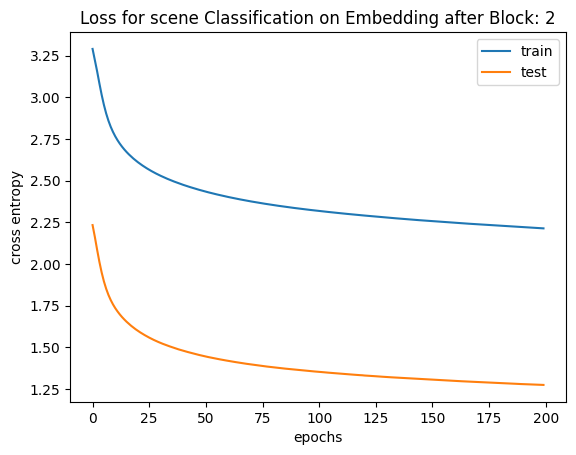

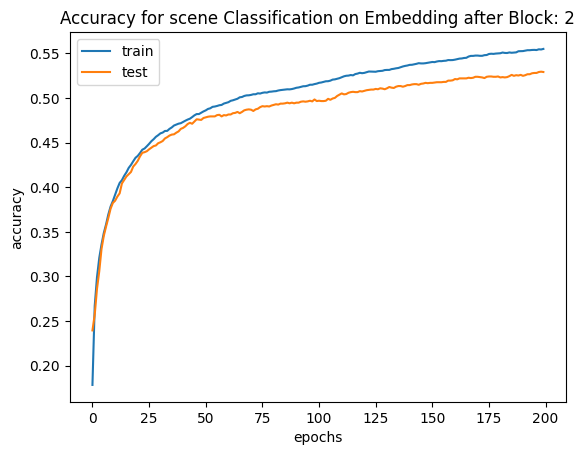

In [128]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [129]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [130]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [131]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [132]:
X_test=train_ready(test_data,col_name)

In [133]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

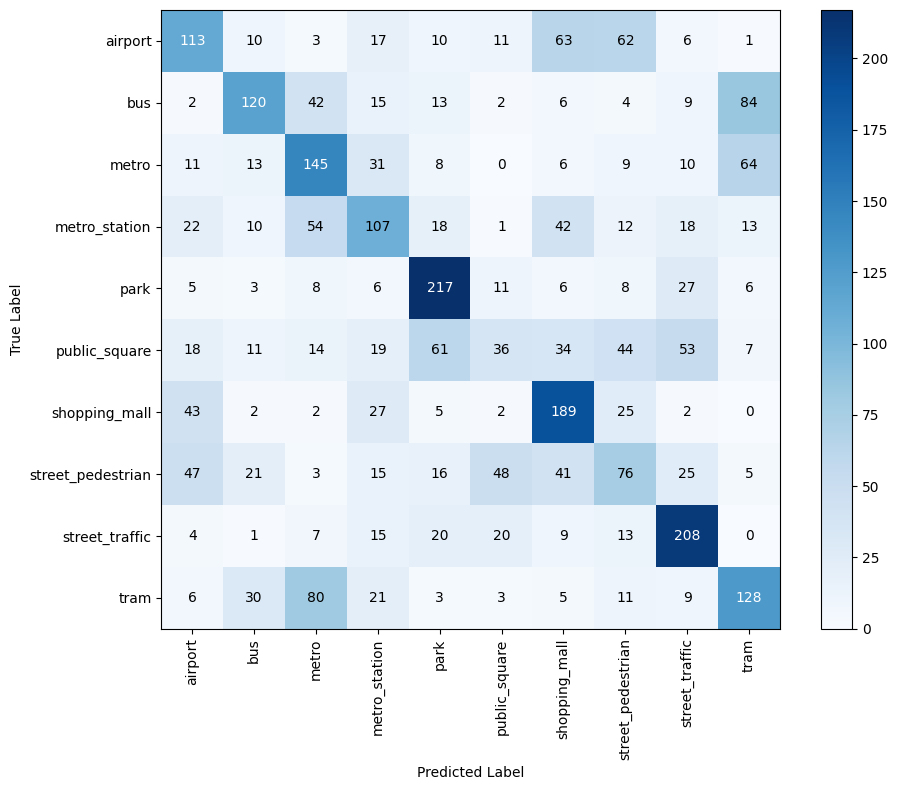

Accuracy: 0.4511


In [134]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# Block-3

In [135]:
Block_number=3

In [136]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [137]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [138]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


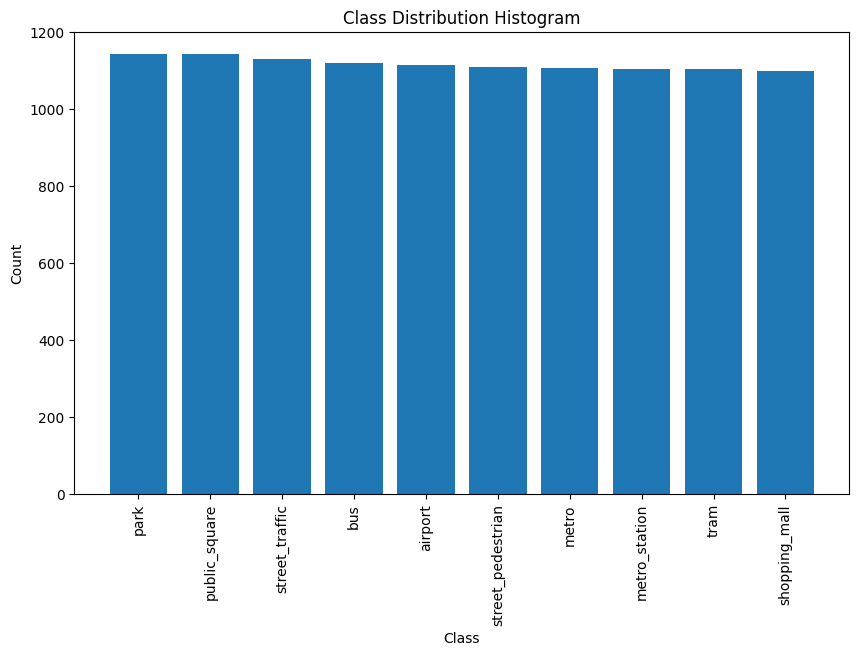

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [139]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


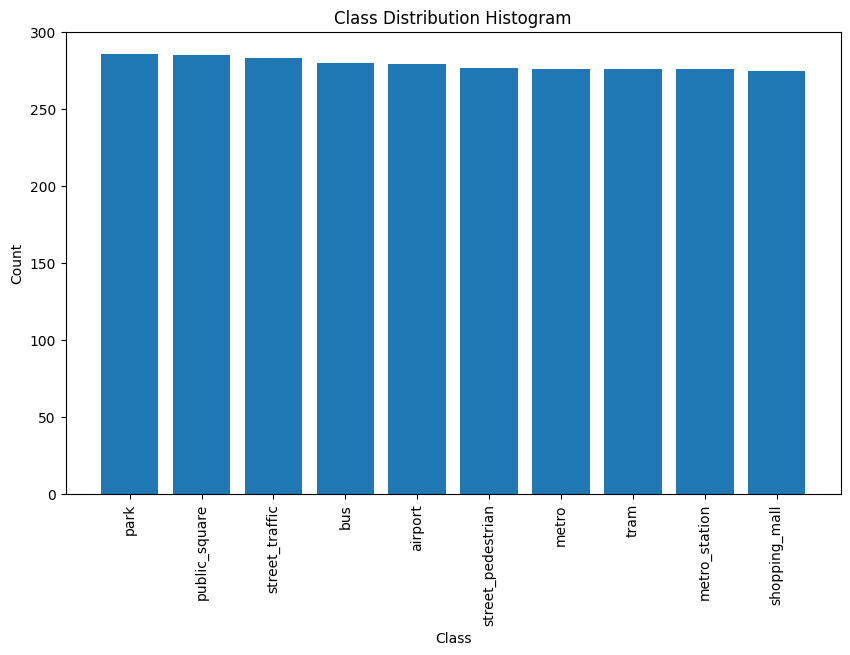

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [140]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [141]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [142]:
X_train_tensor.shape

torch.Size([11169, 768])

In [143]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [144]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 358.62batch/s, acc=0.266, loss=3.23] 


Epoch 0 validation: Cross-entropy=2.20, Accuracy=26.9%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 330.20batch/s, acc=0.328, loss=3.12]


Epoch 1 validation: Cross-entropy=2.07, Accuracy=31.2%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 391.12batch/s, acc=0.391, loss=3]   


Epoch 2 validation: Cross-entropy=1.94, Accuracy=36.1%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 278.00batch/s, acc=0.359, loss=2.88]


Epoch 3 validation: Cross-entropy=1.83, Accuracy=39.6%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 398.35batch/s, acc=0.375, loss=2.79]


Epoch 4 validation: Cross-entropy=1.73, Accuracy=41.7%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 392.04batch/s, acc=0.375, loss=2.71]


Epoch 5 validation: Cross-entropy=1.66, Accuracy=44.1%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 327.72batch/s, acc=0.391, loss=2.66]


Epoch 6 validation: Cross-entropy=1.60, Accuracy=45.5%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 401.93batch/s, acc=0.391, loss=2.61]


Epoch 7 validation: Cross-entropy=1.55, Accuracy=45.8%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 251.82batch/s, acc=0.422, loss=2.58]


Epoch 8 validation: Cross-entropy=1.51, Accuracy=46.8%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 355.57batch/s, acc=0.422, loss=2.55]


Epoch 9 validation: Cross-entropy=1.48, Accuracy=47.9%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 294.72batch/s, acc=0.453, loss=2.52]


Epoch 10 validation: Cross-entropy=1.45, Accuracy=48.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 239.07batch/s, acc=0.469, loss=2.5] 


Epoch 11 validation: Cross-entropy=1.43, Accuracy=49.4%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 332.57batch/s, acc=0.469, loss=2.48]


Epoch 12 validation: Cross-entropy=1.41, Accuracy=49.6%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 330.44batch/s, acc=0.469, loss=2.47]


Epoch 13 validation: Cross-entropy=1.39, Accuracy=50.2%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 327.62batch/s, acc=0.469, loss=2.46]


Epoch 14 validation: Cross-entropy=1.38, Accuracy=50.7%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 281.74batch/s, acc=0.453, loss=2.44]


Epoch 15 validation: Cross-entropy=1.36, Accuracy=51.2%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 335.76batch/s, acc=0.453, loss=2.43]


Epoch 16 validation: Cross-entropy=1.35, Accuracy=51.4%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 314.06batch/s, acc=0.453, loss=2.42]


Epoch 17 validation: Cross-entropy=1.34, Accuracy=51.6%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 339.60batch/s, acc=0.453, loss=2.41]


Epoch 18 validation: Cross-entropy=1.33, Accuracy=52.2%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 279.63batch/s, acc=0.453, loss=2.4] 


Epoch 19 validation: Cross-entropy=1.32, Accuracy=52.3%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 283.85batch/s, acc=0.453, loss=2.4] 


Epoch 20 validation: Cross-entropy=1.31, Accuracy=52.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 341.68batch/s, acc=0.453, loss=2.39]


Epoch 21 validation: Cross-entropy=1.30, Accuracy=52.6%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 334.36batch/s, acc=0.453, loss=2.38]


Epoch 22 validation: Cross-entropy=1.30, Accuracy=52.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 283.97batch/s, acc=0.453, loss=2.37]


Epoch 23 validation: Cross-entropy=1.29, Accuracy=53.0%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 317.57batch/s, acc=0.453, loss=2.37]


Epoch 24 validation: Cross-entropy=1.28, Accuracy=53.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 348.78batch/s, acc=0.453, loss=2.36]


Epoch 25 validation: Cross-entropy=1.28, Accuracy=53.3%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 253.03batch/s, acc=0.453, loss=2.36]


Epoch 26 validation: Cross-entropy=1.27, Accuracy=53.5%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 270.38batch/s, acc=0.453, loss=2.35]


Epoch 27 validation: Cross-entropy=1.27, Accuracy=53.7%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 330.85batch/s, acc=0.453, loss=2.34]


Epoch 28 validation: Cross-entropy=1.26, Accuracy=53.9%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 334.86batch/s, acc=0.453, loss=2.34]


Epoch 29 validation: Cross-entropy=1.26, Accuracy=54.1%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 337.18batch/s, acc=0.453, loss=2.33]


Epoch 30 validation: Cross-entropy=1.25, Accuracy=54.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 329.78batch/s, acc=0.453, loss=2.33]


Epoch 31 validation: Cross-entropy=1.25, Accuracy=54.2%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 270.44batch/s, acc=0.469, loss=2.32]


Epoch 32 validation: Cross-entropy=1.25, Accuracy=54.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 332.32batch/s, acc=0.484, loss=2.32]


Epoch 33 validation: Cross-entropy=1.24, Accuracy=54.7%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 340.65batch/s, acc=0.484, loss=2.32]


Epoch 34 validation: Cross-entropy=1.24, Accuracy=54.5%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 316.11batch/s, acc=0.484, loss=2.31]


Epoch 35 validation: Cross-entropy=1.23, Accuracy=54.5%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 279.56batch/s, acc=0.484, loss=2.31]


Epoch 36 validation: Cross-entropy=1.23, Accuracy=54.7%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 334.39batch/s, acc=0.484, loss=2.3] 


Epoch 37 validation: Cross-entropy=1.23, Accuracy=54.9%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 276.02batch/s, acc=0.484, loss=2.3] 


Epoch 38 validation: Cross-entropy=1.22, Accuracy=55.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 319.05batch/s, acc=0.484, loss=2.29]


Epoch 39 validation: Cross-entropy=1.22, Accuracy=55.1%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 267.59batch/s, acc=0.484, loss=2.29]


Epoch 40 validation: Cross-entropy=1.22, Accuracy=55.3%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 322.45batch/s, acc=0.484, loss=2.29]


Epoch 41 validation: Cross-entropy=1.22, Accuracy=55.4%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 316.38batch/s, acc=0.5, loss=2.28]  


Epoch 42 validation: Cross-entropy=1.21, Accuracy=55.4%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 281.51batch/s, acc=0.5, loss=2.28]  


Epoch 43 validation: Cross-entropy=1.21, Accuracy=55.6%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 259.78batch/s, acc=0.5, loss=2.28]  


Epoch 44 validation: Cross-entropy=1.21, Accuracy=55.7%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 330.20batch/s, acc=0.5, loss=2.27]  


Epoch 45 validation: Cross-entropy=1.21, Accuracy=55.8%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 322.30batch/s, acc=0.5, loss=2.27]  


Epoch 46 validation: Cross-entropy=1.20, Accuracy=55.9%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 331.92batch/s, acc=0.484, loss=2.27]


Epoch 47 validation: Cross-entropy=1.20, Accuracy=55.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 343.20batch/s, acc=0.484, loss=2.26]


Epoch 48 validation: Cross-entropy=1.20, Accuracy=55.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 247.17batch/s, acc=0.484, loss=2.26]


Epoch 49 validation: Cross-entropy=1.20, Accuracy=55.9%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 327.27batch/s, acc=0.484, loss=2.26]


Epoch 50 validation: Cross-entropy=1.19, Accuracy=56.0%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 335.30batch/s, acc=0.484, loss=2.25]


Epoch 51 validation: Cross-entropy=1.19, Accuracy=56.1%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 332.08batch/s, acc=0.484, loss=2.25]


Epoch 52 validation: Cross-entropy=1.19, Accuracy=56.1%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 272.82batch/s, acc=0.484, loss=2.25]


Epoch 53 validation: Cross-entropy=1.19, Accuracy=56.1%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 324.22batch/s, acc=0.484, loss=2.24]


Epoch 54 validation: Cross-entropy=1.19, Accuracy=56.4%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 276.89batch/s, acc=0.484, loss=2.24]


Epoch 55 validation: Cross-entropy=1.18, Accuracy=56.5%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 320.37batch/s, acc=0.5, loss=2.24]  


Epoch 56 validation: Cross-entropy=1.18, Accuracy=56.5%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 263.95batch/s, acc=0.5, loss=2.23]  


Epoch 57 validation: Cross-entropy=1.18, Accuracy=56.5%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 297.65batch/s, acc=0.516, loss=2.23]


Epoch 58 validation: Cross-entropy=1.18, Accuracy=56.5%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 234.78batch/s, acc=0.516, loss=2.23]


Epoch 59 validation: Cross-entropy=1.18, Accuracy=56.6%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 321.77batch/s, acc=0.516, loss=2.23]


Epoch 60 validation: Cross-entropy=1.17, Accuracy=56.7%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 337.54batch/s, acc=0.531, loss=2.22]


Epoch 61 validation: Cross-entropy=1.17, Accuracy=56.7%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 314.15batch/s, acc=0.531, loss=2.22]


Epoch 62 validation: Cross-entropy=1.17, Accuracy=56.7%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 327.76batch/s, acc=0.531, loss=2.22]


Epoch 63 validation: Cross-entropy=1.17, Accuracy=56.8%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 392.95batch/s, acc=0.531, loss=2.22]


Epoch 64 validation: Cross-entropy=1.17, Accuracy=57.0%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 321.19batch/s, acc=0.531, loss=2.21]


Epoch 65 validation: Cross-entropy=1.17, Accuracy=57.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 341.21batch/s, acc=0.531, loss=2.21]


Epoch 66 validation: Cross-entropy=1.16, Accuracy=57.0%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 359.05batch/s, acc=0.531, loss=2.21]


Epoch 67 validation: Cross-entropy=1.16, Accuracy=57.1%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 260.85batch/s, acc=0.531, loss=2.2] 


Epoch 68 validation: Cross-entropy=1.16, Accuracy=57.2%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 333.00batch/s, acc=0.531, loss=2.2] 


Epoch 69 validation: Cross-entropy=1.16, Accuracy=57.3%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 310.60batch/s, acc=0.531, loss=2.2] 


Epoch 70 validation: Cross-entropy=1.16, Accuracy=57.3%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 322.81batch/s, acc=0.531, loss=2.2] 


Epoch 71 validation: Cross-entropy=1.16, Accuracy=57.4%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 389.93batch/s, acc=0.531, loss=2.19]


Epoch 72 validation: Cross-entropy=1.16, Accuracy=57.4%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 331.04batch/s, acc=0.531, loss=2.19]


Epoch 73 validation: Cross-entropy=1.15, Accuracy=57.5%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 320.84batch/s, acc=0.531, loss=2.19]


Epoch 74 validation: Cross-entropy=1.15, Accuracy=57.6%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 394.61batch/s, acc=0.531, loss=2.19]


Epoch 75 validation: Cross-entropy=1.15, Accuracy=57.6%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 264.63batch/s, acc=0.531, loss=2.19]


Epoch 76 validation: Cross-entropy=1.15, Accuracy=57.6%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 326.47batch/s, acc=0.531, loss=2.18]


Epoch 77 validation: Cross-entropy=1.15, Accuracy=57.7%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 385.55batch/s, acc=0.531, loss=2.18]


Epoch 78 validation: Cross-entropy=1.15, Accuracy=57.7%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 323.66batch/s, acc=0.531, loss=2.18]


Epoch 79 validation: Cross-entropy=1.15, Accuracy=57.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 394.56batch/s, acc=0.531, loss=2.18]


Epoch 80 validation: Cross-entropy=1.14, Accuracy=57.7%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 329.47batch/s, acc=0.531, loss=2.17]


Epoch 81 validation: Cross-entropy=1.14, Accuracy=57.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 324.47batch/s, acc=0.531, loss=2.17]


Epoch 82 validation: Cross-entropy=1.14, Accuracy=57.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 327.97batch/s, acc=0.531, loss=2.17]


Epoch 83 validation: Cross-entropy=1.14, Accuracy=57.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 331.49batch/s, acc=0.531, loss=2.17]


Epoch 84 validation: Cross-entropy=1.14, Accuracy=58.0%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 325.95batch/s, acc=0.531, loss=2.17]


Epoch 85 validation: Cross-entropy=1.14, Accuracy=58.1%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 388.63batch/s, acc=0.531, loss=2.16]


Epoch 86 validation: Cross-entropy=1.14, Accuracy=58.1%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 314.38batch/s, acc=0.531, loss=2.16]


Epoch 87 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 318.13batch/s, acc=0.531, loss=2.16]


Epoch 88 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 403.50batch/s, acc=0.531, loss=2.16]


Epoch 89 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 271.87batch/s, acc=0.531, loss=2.15]


Epoch 90 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 322.97batch/s, acc=0.531, loss=2.15]


Epoch 91 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 408.63batch/s, acc=0.531, loss=2.15]


Epoch 92 validation: Cross-entropy=1.13, Accuracy=58.0%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 328.43batch/s, acc=0.547, loss=2.15]


Epoch 93 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 325.63batch/s, acc=0.547, loss=2.15]


Epoch 94 validation: Cross-entropy=1.13, Accuracy=58.3%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 400.34batch/s, acc=0.547, loss=2.15]


Epoch 95 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 333.40batch/s, acc=0.547, loss=2.14]


Epoch 96 validation: Cross-entropy=1.12, Accuracy=58.3%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 321.37batch/s, acc=0.547, loss=2.14]


Epoch 97 validation: Cross-entropy=1.12, Accuracy=58.2%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 326.51batch/s, acc=0.547, loss=2.14]


Epoch 98 validation: Cross-entropy=1.12, Accuracy=58.4%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 328.93batch/s, acc=0.547, loss=2.14]


Epoch 99 validation: Cross-entropy=1.12, Accuracy=58.4%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 396.75batch/s, acc=0.547, loss=2.14]


Epoch 100 validation: Cross-entropy=1.12, Accuracy=58.4%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 319.40batch/s, acc=0.547, loss=2.13]


Epoch 101 validation: Cross-entropy=1.12, Accuracy=58.5%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 315.57batch/s, acc=0.547, loss=2.13]


Epoch 102 validation: Cross-entropy=1.12, Accuracy=58.6%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 394.05batch/s, acc=0.547, loss=2.13]


Epoch 103 validation: Cross-entropy=1.12, Accuracy=58.6%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 274.01batch/s, acc=0.547, loss=2.13]


Epoch 104 validation: Cross-entropy=1.12, Accuracy=58.6%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 331.47batch/s, acc=0.547, loss=2.13]


Epoch 105 validation: Cross-entropy=1.12, Accuracy=58.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 380.63batch/s, acc=0.547, loss=2.12]


Epoch 106 validation: Cross-entropy=1.11, Accuracy=58.7%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 319.06batch/s, acc=0.547, loss=2.12]


Epoch 107 validation: Cross-entropy=1.11, Accuracy=58.6%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 330.64batch/s, acc=0.547, loss=2.12]


Epoch 108 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 399.97batch/s, acc=0.547, loss=2.12]


Epoch 109 validation: Cross-entropy=1.11, Accuracy=58.7%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 325.56batch/s, acc=0.547, loss=2.12]


Epoch 110 validation: Cross-entropy=1.11, Accuracy=58.6%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 288.33batch/s, acc=0.547, loss=2.11]


Epoch 111 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 385.48batch/s, acc=0.547, loss=2.11]


Epoch 112 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 340.83batch/s, acc=0.547, loss=2.11]


Epoch 113 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 401.81batch/s, acc=0.547, loss=2.11]


Epoch 114 validation: Cross-entropy=1.11, Accuracy=58.9%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 327.20batch/s, acc=0.547, loss=2.11]


Epoch 115 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 342.98batch/s, acc=0.547, loss=2.11]


Epoch 116 validation: Cross-entropy=1.10, Accuracy=58.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 378.88batch/s, acc=0.547, loss=2.1] 


Epoch 117 validation: Cross-entropy=1.10, Accuracy=58.8%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 282.58batch/s, acc=0.547, loss=2.1] 


Epoch 118 validation: Cross-entropy=1.10, Accuracy=58.9%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 393.73batch/s, acc=0.547, loss=2.1] 


Epoch 119 validation: Cross-entropy=1.10, Accuracy=58.9%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 324.29batch/s, acc=0.547, loss=2.1] 


Epoch 120 validation: Cross-entropy=1.10, Accuracy=59.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 327.80batch/s, acc=0.547, loss=2.1] 


Epoch 121 validation: Cross-entropy=1.10, Accuracy=59.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 384.61batch/s, acc=0.547, loss=2.1] 


Epoch 122 validation: Cross-entropy=1.10, Accuracy=59.1%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 336.48batch/s, acc=0.547, loss=2.09]


Epoch 123 validation: Cross-entropy=1.10, Accuracy=59.1%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 314.34batch/s, acc=0.547, loss=2.09]


Epoch 124 validation: Cross-entropy=1.10, Accuracy=59.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 288.76batch/s, acc=0.547, loss=2.09]


Epoch 125 validation: Cross-entropy=1.10, Accuracy=59.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 385.43batch/s, acc=0.547, loss=2.09]


Epoch 126 validation: Cross-entropy=1.10, Accuracy=59.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 313.82batch/s, acc=0.547, loss=2.09]


Epoch 127 validation: Cross-entropy=1.10, Accuracy=59.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 388.11batch/s, acc=0.547, loss=2.08]


Epoch 128 validation: Cross-entropy=1.09, Accuracy=59.4%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 327.52batch/s, acc=0.547, loss=2.08]


Epoch 129 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 318.95batch/s, acc=0.547, loss=2.08]


Epoch 130 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 413.79batch/s, acc=0.547, loss=2.08]


Epoch 131 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 286.54batch/s, acc=0.547, loss=2.08]


Epoch 132 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 328.13batch/s, acc=0.547, loss=2.08]


Epoch 133 validation: Cross-entropy=1.09, Accuracy=59.4%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 408.70batch/s, acc=0.547, loss=2.08]


Epoch 134 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 344.62batch/s, acc=0.547, loss=2.07]


Epoch 135 validation: Cross-entropy=1.09, Accuracy=59.4%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 399.78batch/s, acc=0.547, loss=2.07]


Epoch 136 validation: Cross-entropy=1.09, Accuracy=59.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 342.36batch/s, acc=0.547, loss=2.07]


Epoch 137 validation: Cross-entropy=1.09, Accuracy=59.4%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 337.72batch/s, acc=0.562, loss=2.07]


Epoch 138 validation: Cross-entropy=1.09, Accuracy=59.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 350.49batch/s, acc=0.562, loss=2.07]


Epoch 139 validation: Cross-entropy=1.09, Accuracy=59.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 336.34batch/s, acc=0.562, loss=2.07]


Epoch 140 validation: Cross-entropy=1.09, Accuracy=59.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 416.11batch/s, acc=0.562, loss=2.07]


Epoch 141 validation: Cross-entropy=1.08, Accuracy=59.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 334.82batch/s, acc=0.562, loss=2.06]


Epoch 142 validation: Cross-entropy=1.08, Accuracy=59.7%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 352.45batch/s, acc=0.562, loss=2.06]


Epoch 143 validation: Cross-entropy=1.08, Accuracy=59.8%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 411.30batch/s, acc=0.562, loss=2.06]


Epoch 144 validation: Cross-entropy=1.08, Accuracy=59.9%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 342.33batch/s, acc=0.562, loss=2.06]


Epoch 145 validation: Cross-entropy=1.08, Accuracy=59.8%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 349.89batch/s, acc=0.562, loss=2.06]


Epoch 146 validation: Cross-entropy=1.08, Accuracy=59.8%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 306.87batch/s, acc=0.562, loss=2.06]


Epoch 147 validation: Cross-entropy=1.08, Accuracy=59.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 330.41batch/s, acc=0.578, loss=2.05]


Epoch 148 validation: Cross-entropy=1.08, Accuracy=60.0%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 419.34batch/s, acc=0.578, loss=2.05]


Epoch 149 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 343.95batch/s, acc=0.578, loss=2.05]


Epoch 150 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 348.05batch/s, acc=0.578, loss=2.05]


Epoch 151 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 387.82batch/s, acc=0.578, loss=2.05]


Epoch 152 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 308.58batch/s, acc=0.578, loss=2.05]


Epoch 153 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 359.23batch/s, acc=0.578, loss=2.04]


Epoch 154 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 335.71batch/s, acc=0.578, loss=2.04]


Epoch 155 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 349.60batch/s, acc=0.578, loss=2.04]


Epoch 156 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 397.66batch/s, acc=0.578, loss=2.04]


Epoch 157 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 337.52batch/s, acc=0.578, loss=2.04]


Epoch 158 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 372.35batch/s, acc=0.578, loss=2.04]


Epoch 159 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 383.58batch/s, acc=0.578, loss=2.04]


Epoch 160 validation: Cross-entropy=1.07, Accuracy=60.3%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 273.64batch/s, acc=0.578, loss=2.03]


Epoch 161 validation: Cross-entropy=1.07, Accuracy=60.3%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 419.64batch/s, acc=0.578, loss=2.03]


Epoch 162 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 331.34batch/s, acc=0.578, loss=2.03]


Epoch 163 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 344.81batch/s, acc=0.578, loss=2.03]


Epoch 164 validation: Cross-entropy=1.07, Accuracy=60.3%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 370.16batch/s, acc=0.578, loss=2.03]


Epoch 165 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 322.98batch/s, acc=0.578, loss=2.03]


Epoch 166 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 200.07batch/s, acc=0.578, loss=2.03]


Epoch 167 validation: Cross-entropy=1.07, Accuracy=60.3%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 392.11batch/s, acc=0.578, loss=2.02]


Epoch 168 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 342.24batch/s, acc=0.578, loss=2.02]


Epoch 169 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 360.03batch/s, acc=0.578, loss=2.02]


Epoch 170 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 328.24batch/s, acc=0.594, loss=2.02]


Epoch 171 validation: Cross-entropy=1.06, Accuracy=60.3%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 387.67batch/s, acc=0.578, loss=2.02]


Epoch 172 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 323.40batch/s, acc=0.578, loss=2.02]


Epoch 173 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 406.01batch/s, acc=0.594, loss=2.02]


Epoch 174 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 320.91batch/s, acc=0.594, loss=2.01]


Epoch 175 validation: Cross-entropy=1.06, Accuracy=60.3%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 402.54batch/s, acc=0.594, loss=2.01]


Epoch 176 validation: Cross-entropy=1.06, Accuracy=60.3%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 262.31batch/s, acc=0.594, loss=2.01]


Epoch 177 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 393.33batch/s, acc=0.594, loss=2.01]


Epoch 178 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 337.63batch/s, acc=0.594, loss=2.01]


Epoch 179 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 368.49batch/s, acc=0.594, loss=2.01]


Epoch 180 validation: Cross-entropy=1.06, Accuracy=60.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 399.79batch/s, acc=0.594, loss=2.01]


Epoch 181 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 310.21batch/s, acc=0.594, loss=2.01]


Epoch 182 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 378.23batch/s, acc=0.594, loss=2]   


Epoch 183 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 283.31batch/s, acc=0.594, loss=2]   


Epoch 184 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 337.31batch/s, acc=0.594, loss=2]   


Epoch 185 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 369.34batch/s, acc=0.594, loss=2]   


Epoch 186 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 407.63batch/s, acc=0.594, loss=2]   


Epoch 187 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 311.71batch/s, acc=0.594, loss=2]   


Epoch 188 validation: Cross-entropy=1.05, Accuracy=60.5%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 397.32batch/s, acc=0.594, loss=2]   


Epoch 189 validation: Cross-entropy=1.05, Accuracy=60.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 271.44batch/s, acc=0.594, loss=2]   


Epoch 190 validation: Cross-entropy=1.05, Accuracy=60.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 387.75batch/s, acc=0.594, loss=1.99]


Epoch 191 validation: Cross-entropy=1.05, Accuracy=60.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 320.50batch/s, acc=0.594, loss=1.99]


Epoch 192 validation: Cross-entropy=1.05, Accuracy=60.6%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 412.48batch/s, acc=0.594, loss=1.99]


Epoch 193 validation: Cross-entropy=1.05, Accuracy=60.5%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 333.77batch/s, acc=0.594, loss=1.99]


Epoch 194 validation: Cross-entropy=1.05, Accuracy=60.6%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 394.01batch/s, acc=0.594, loss=1.99]


Epoch 195 validation: Cross-entropy=1.05, Accuracy=60.6%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 325.22batch/s, acc=0.594, loss=1.99]


Epoch 196 validation: Cross-entropy=1.05, Accuracy=60.7%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 415.38batch/s, acc=0.594, loss=1.99]


Epoch 197 validation: Cross-entropy=1.05, Accuracy=60.7%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 263.64batch/s, acc=0.594, loss=1.99]


Epoch 198 validation: Cross-entropy=1.05, Accuracy=60.7%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 377.50batch/s, acc=0.594, loss=1.99]


Epoch 199 validation: Cross-entropy=1.05, Accuracy=60.8%


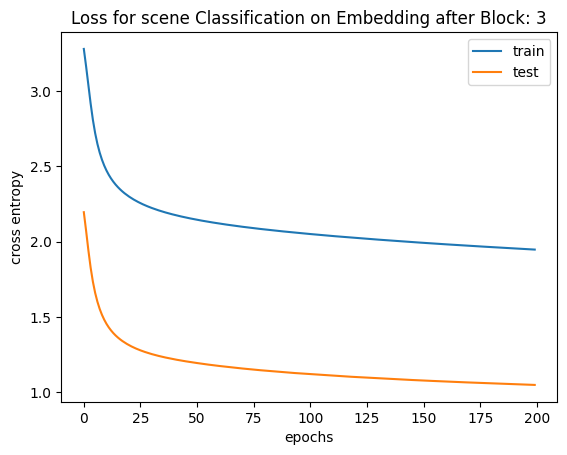

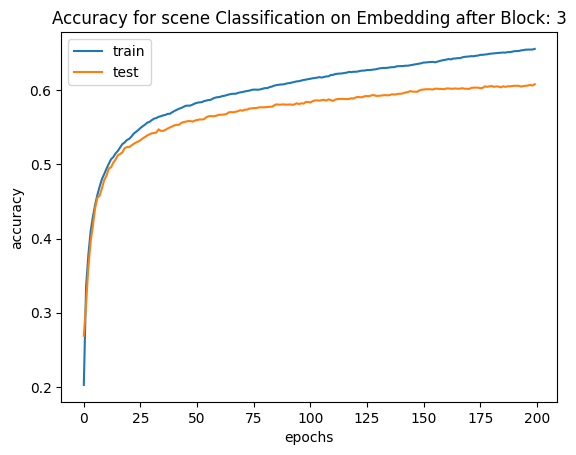

In [145]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [146]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [147]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [148]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [149]:
X_test=train_ready(test_data,col_name)

In [150]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

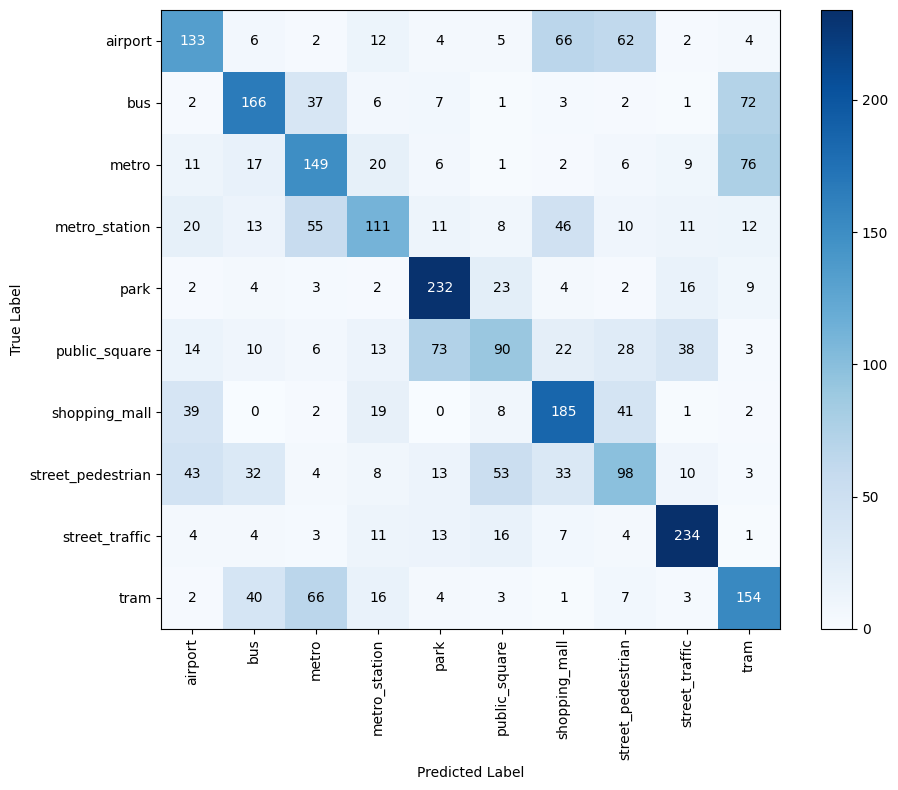

Accuracy: 0.5229


In [151]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-4

In [152]:
Block_number=4

In [153]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [154]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [155]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


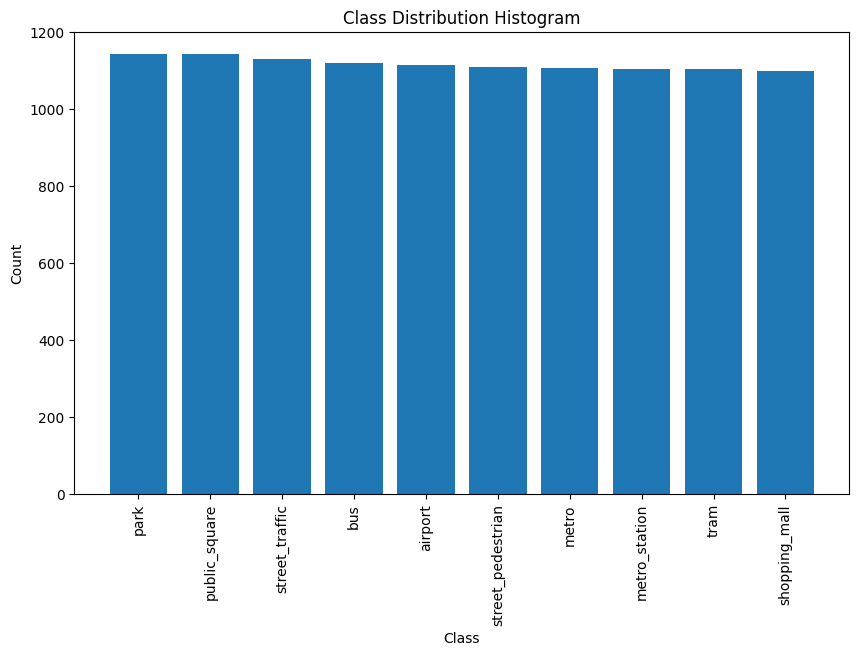

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [156]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


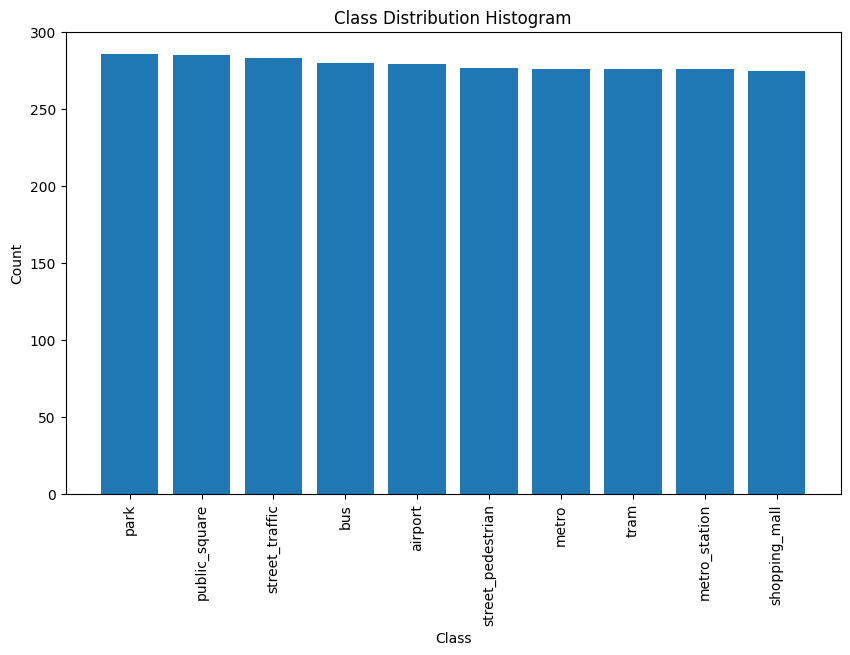

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [157]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [158]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [159]:
X_train_tensor.shape

torch.Size([11169, 768])

In [160]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [161]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 345.66batch/s, acc=0.453, loss=3.16]


Epoch 0 validation: Cross-entropy=2.13, Accuracy=40.2%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 274.25batch/s, acc=0.469, loss=2.96]


Epoch 1 validation: Cross-entropy=1.90, Accuracy=44.5%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 383.70batch/s, acc=0.5, loss=2.75]  


Epoch 2 validation: Cross-entropy=1.69, Accuracy=48.0%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 319.46batch/s, acc=0.516, loss=2.59]


Epoch 3 validation: Cross-entropy=1.54, Accuracy=49.6%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 393.39batch/s, acc=0.547, loss=2.48]


Epoch 4 validation: Cross-entropy=1.44, Accuracy=51.7%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 327.35batch/s, acc=0.531, loss=2.41]


Epoch 5 validation: Cross-entropy=1.37, Accuracy=53.1%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 389.39batch/s, acc=0.531, loss=2.36]


Epoch 6 validation: Cross-entropy=1.31, Accuracy=54.3%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 332.09batch/s, acc=0.531, loss=2.32]


Epoch 7 validation: Cross-entropy=1.27, Accuracy=55.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 381.96batch/s, acc=0.531, loss=2.28]


Epoch 8 validation: Cross-entropy=1.24, Accuracy=56.1%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 290.48batch/s, acc=0.531, loss=2.26]


Epoch 9 validation: Cross-entropy=1.21, Accuracy=56.9%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 369.44batch/s, acc=0.531, loss=2.24]


Epoch 10 validation: Cross-entropy=1.19, Accuracy=57.4%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 322.25batch/s, acc=0.547, loss=2.22]


Epoch 11 validation: Cross-entropy=1.17, Accuracy=57.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 334.90batch/s, acc=0.531, loss=2.2] 


Epoch 12 validation: Cross-entropy=1.16, Accuracy=58.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 385.32batch/s, acc=0.531, loss=2.19]


Epoch 13 validation: Cross-entropy=1.14, Accuracy=58.6%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 327.30batch/s, acc=0.531, loss=2.18]


Epoch 14 validation: Cross-entropy=1.13, Accuracy=58.8%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 335.79batch/s, acc=0.547, loss=2.16]


Epoch 15 validation: Cross-entropy=1.12, Accuracy=59.1%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 312.13batch/s, acc=0.547, loss=2.15]


Epoch 16 validation: Cross-entropy=1.11, Accuracy=59.5%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 324.78batch/s, acc=0.547, loss=2.14]


Epoch 17 validation: Cross-entropy=1.10, Accuracy=59.7%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 390.70batch/s, acc=0.562, loss=2.13]


Epoch 18 validation: Cross-entropy=1.09, Accuracy=59.8%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 319.94batch/s, acc=0.562, loss=2.13]


Epoch 19 validation: Cross-entropy=1.08, Accuracy=60.0%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 335.04batch/s, acc=0.562, loss=2.12]


Epoch 20 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 402.62batch/s, acc=0.562, loss=2.11]


Epoch 21 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 325.83batch/s, acc=0.562, loss=2.11]


Epoch 22 validation: Cross-entropy=1.06, Accuracy=60.7%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 275.50batch/s, acc=0.547, loss=2.1] 


Epoch 23 validation: Cross-entropy=1.06, Accuracy=60.9%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 398.38batch/s, acc=0.562, loss=2.09]


Epoch 24 validation: Cross-entropy=1.05, Accuracy=61.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 331.82batch/s, acc=0.562, loss=2.09]


Epoch 25 validation: Cross-entropy=1.05, Accuracy=61.3%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 378.14batch/s, acc=0.562, loss=2.08]


Epoch 26 validation: Cross-entropy=1.04, Accuracy=61.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 347.97batch/s, acc=0.578, loss=2.08]


Epoch 27 validation: Cross-entropy=1.04, Accuracy=61.6%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 329.40batch/s, acc=0.578, loss=2.07]


Epoch 28 validation: Cross-entropy=1.03, Accuracy=61.7%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 410.03batch/s, acc=0.578, loss=2.07]


Epoch 29 validation: Cross-entropy=1.03, Accuracy=61.8%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 276.76batch/s, acc=0.578, loss=2.06]


Epoch 30 validation: Cross-entropy=1.03, Accuracy=61.9%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 326.48batch/s, acc=0.609, loss=2.06]


Epoch 31 validation: Cross-entropy=1.02, Accuracy=62.0%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 409.55batch/s, acc=0.609, loss=2.05]


Epoch 32 validation: Cross-entropy=1.02, Accuracy=62.2%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 320.11batch/s, acc=0.625, loss=2.05]


Epoch 33 validation: Cross-entropy=1.02, Accuracy=62.3%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 359.18batch/s, acc=0.625, loss=2.04]


Epoch 34 validation: Cross-entropy=1.01, Accuracy=62.2%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 373.84batch/s, acc=0.625, loss=2.04]


Epoch 35 validation: Cross-entropy=1.01, Accuracy=62.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 324.12batch/s, acc=0.625, loss=2.04]


Epoch 36 validation: Cross-entropy=1.01, Accuracy=62.3%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 322.76batch/s, acc=0.625, loss=2.03]


Epoch 37 validation: Cross-entropy=1.00, Accuracy=62.3%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 331.62batch/s, acc=0.625, loss=2.03]


Epoch 38 validation: Cross-entropy=1.00, Accuracy=62.4%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 323.96batch/s, acc=0.625, loss=2.03]


Epoch 39 validation: Cross-entropy=1.00, Accuracy=62.5%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 408.28batch/s, acc=0.625, loss=2.02]


Epoch 40 validation: Cross-entropy=1.00, Accuracy=62.7%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 327.74batch/s, acc=0.625, loss=2.02]


Epoch 41 validation: Cross-entropy=0.99, Accuracy=62.7%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 376.83batch/s, acc=0.625, loss=2.02]


Epoch 42 validation: Cross-entropy=0.99, Accuracy=62.7%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 374.07batch/s, acc=0.625, loss=2.01]


Epoch 43 validation: Cross-entropy=0.99, Accuracy=62.7%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 280.15batch/s, acc=0.625, loss=2.01]


Epoch 44 validation: Cross-entropy=0.99, Accuracy=62.7%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 413.54batch/s, acc=0.625, loss=2.01]


Epoch 45 validation: Cross-entropy=0.98, Accuracy=62.9%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 336.61batch/s, acc=0.625, loss=2]   


Epoch 46 validation: Cross-entropy=0.98, Accuracy=63.1%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 387.15batch/s, acc=0.625, loss=2]   


Epoch 47 validation: Cross-entropy=0.98, Accuracy=63.2%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 330.21batch/s, acc=0.625, loss=2]   


Epoch 48 validation: Cross-entropy=0.98, Accuracy=63.3%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 322.44batch/s, acc=0.625, loss=1.99]


Epoch 49 validation: Cross-entropy=0.97, Accuracy=63.4%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 404.82batch/s, acc=0.625, loss=1.99]


Epoch 50 validation: Cross-entropy=0.97, Accuracy=63.8%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 272.84batch/s, acc=0.625, loss=1.99]


Epoch 51 validation: Cross-entropy=0.97, Accuracy=63.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 400.46batch/s, acc=0.625, loss=1.99]


Epoch 52 validation: Cross-entropy=0.97, Accuracy=64.0%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 328.08batch/s, acc=0.625, loss=1.98]


Epoch 53 validation: Cross-entropy=0.97, Accuracy=64.2%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 342.29batch/s, acc=0.625, loss=1.98]


Epoch 54 validation: Cross-entropy=0.96, Accuracy=64.2%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 380.64batch/s, acc=0.625, loss=1.98]


Epoch 55 validation: Cross-entropy=0.96, Accuracy=64.3%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 336.25batch/s, acc=0.625, loss=1.98]


Epoch 56 validation: Cross-entropy=0.96, Accuracy=64.4%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 393.27batch/s, acc=0.625, loss=1.97]


Epoch 57 validation: Cross-entropy=0.96, Accuracy=64.5%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 275.92batch/s, acc=0.625, loss=1.97]


Epoch 58 validation: Cross-entropy=0.96, Accuracy=64.5%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 382.67batch/s, acc=0.625, loss=1.97]


Epoch 59 validation: Cross-entropy=0.96, Accuracy=64.6%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 331.61batch/s, acc=0.641, loss=1.97]


Epoch 60 validation: Cross-entropy=0.95, Accuracy=64.6%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 383.62batch/s, acc=0.641, loss=1.97]


Epoch 61 validation: Cross-entropy=0.95, Accuracy=64.6%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 334.33batch/s, acc=0.641, loss=1.96]


Epoch 62 validation: Cross-entropy=0.95, Accuracy=64.6%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 322.77batch/s, acc=0.641, loss=1.96]


Epoch 63 validation: Cross-entropy=0.95, Accuracy=64.6%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 340.71batch/s, acc=0.656, loss=1.96]


Epoch 64 validation: Cross-entropy=0.95, Accuracy=64.4%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 326.02batch/s, acc=0.672, loss=1.96]


Epoch 65 validation: Cross-entropy=0.95, Accuracy=64.5%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 330.09batch/s, acc=0.672, loss=1.95]


Epoch 66 validation: Cross-entropy=0.95, Accuracy=64.6%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 405.14batch/s, acc=0.672, loss=1.95]


Epoch 67 validation: Cross-entropy=0.94, Accuracy=64.7%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 345.72batch/s, acc=0.672, loss=1.95]


Epoch 68 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 360.81batch/s, acc=0.672, loss=1.95]


Epoch 69 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 370.26batch/s, acc=0.672, loss=1.95]


Epoch 70 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 333.40batch/s, acc=0.672, loss=1.95]


Epoch 71 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 327.90batch/s, acc=0.672, loss=1.94]


Epoch 72 validation: Cross-entropy=0.94, Accuracy=64.9%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 317.34batch/s, acc=0.672, loss=1.94]


Epoch 73 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 326.40batch/s, acc=0.672, loss=1.94]


Epoch 74 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 387.45batch/s, acc=0.672, loss=1.94]


Epoch 75 validation: Cross-entropy=0.93, Accuracy=64.9%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 330.03batch/s, acc=0.672, loss=1.94]


Epoch 76 validation: Cross-entropy=0.93, Accuracy=65.0%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 389.71batch/s, acc=0.672, loss=1.93]


Epoch 77 validation: Cross-entropy=0.93, Accuracy=65.0%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 332.94batch/s, acc=0.672, loss=1.93]


Epoch 78 validation: Cross-entropy=0.93, Accuracy=65.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 281.83batch/s, acc=0.672, loss=1.93]


Epoch 79 validation: Cross-entropy=0.93, Accuracy=65.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 347.42batch/s, acc=0.672, loss=1.93]


Epoch 80 validation: Cross-entropy=0.93, Accuracy=65.2%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 372.15batch/s, acc=0.672, loss=1.93]


Epoch 81 validation: Cross-entropy=0.93, Accuracy=65.2%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 336.46batch/s, acc=0.672, loss=1.92]


Epoch 82 validation: Cross-entropy=0.93, Accuracy=65.2%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 398.13batch/s, acc=0.672, loss=1.92]


Epoch 83 validation: Cross-entropy=0.93, Accuracy=65.2%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 320.65batch/s, acc=0.688, loss=1.92]


Epoch 84 validation: Cross-entropy=0.92, Accuracy=65.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 351.62batch/s, acc=0.688, loss=1.92]


Epoch 85 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 308.56batch/s, acc=0.672, loss=1.92]


Epoch 86 validation: Cross-entropy=0.92, Accuracy=65.4%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 328.03batch/s, acc=0.672, loss=1.92]


Epoch 87 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 396.93batch/s, acc=0.672, loss=1.91]


Epoch 88 validation: Cross-entropy=0.92, Accuracy=65.2%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 332.81batch/s, acc=0.672, loss=1.91]


Epoch 89 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 328.54batch/s, acc=0.672, loss=1.91]


Epoch 90 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 393.19batch/s, acc=0.672, loss=1.91]


Epoch 91 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 327.79batch/s, acc=0.672, loss=1.91]


Epoch 92 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 278.87batch/s, acc=0.672, loss=1.91]


Epoch 93 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 384.63batch/s, acc=0.672, loss=1.9] 


Epoch 94 validation: Cross-entropy=0.91, Accuracy=65.3%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 331.28batch/s, acc=0.672, loss=1.9] 


Epoch 95 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 405.11batch/s, acc=0.672, loss=1.9] 


Epoch 96 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 325.37batch/s, acc=0.672, loss=1.9] 


Epoch 97 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 336.82batch/s, acc=0.672, loss=1.9] 


Epoch 98 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 398.81batch/s, acc=0.688, loss=1.9] 


Epoch 99 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 284.27batch/s, acc=0.703, loss=1.89]


Epoch 100 validation: Cross-entropy=0.91, Accuracy=65.5%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 316.54batch/s, acc=0.703, loss=1.89]


Epoch 101 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 396.07batch/s, acc=0.703, loss=1.89]


Epoch 102 validation: Cross-entropy=0.91, Accuracy=65.7%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 334.91batch/s, acc=0.703, loss=1.89]


Epoch 103 validation: Cross-entropy=0.91, Accuracy=65.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 343.97batch/s, acc=0.703, loss=1.89]


Epoch 104 validation: Cross-entropy=0.91, Accuracy=65.7%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 378.95batch/s, acc=0.703, loss=1.89]


Epoch 105 validation: Cross-entropy=0.91, Accuracy=65.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 324.72batch/s, acc=0.703, loss=1.89]


Epoch 106 validation: Cross-entropy=0.90, Accuracy=65.7%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 339.32batch/s, acc=0.703, loss=1.88]


Epoch 107 validation: Cross-entropy=0.90, Accuracy=65.8%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 319.91batch/s, acc=0.703, loss=1.88]


Epoch 108 validation: Cross-entropy=0.90, Accuracy=65.8%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 329.27batch/s, acc=0.703, loss=1.88]


Epoch 109 validation: Cross-entropy=0.90, Accuracy=65.9%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 406.87batch/s, acc=0.703, loss=1.88]


Epoch 110 validation: Cross-entropy=0.90, Accuracy=65.9%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 330.30batch/s, acc=0.703, loss=1.88]


Epoch 111 validation: Cross-entropy=0.90, Accuracy=66.0%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 398.55batch/s, acc=0.703, loss=1.88]


Epoch 112 validation: Cross-entropy=0.90, Accuracy=66.1%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 340.80batch/s, acc=0.703, loss=1.88]


Epoch 113 validation: Cross-entropy=0.90, Accuracy=66.1%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 286.46batch/s, acc=0.703, loss=1.87]


Epoch 114 validation: Cross-entropy=0.90, Accuracy=66.1%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 386.02batch/s, acc=0.703, loss=1.87]


Epoch 115 validation: Cross-entropy=0.90, Accuracy=66.0%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 326.84batch/s, acc=0.703, loss=1.87]


Epoch 116 validation: Cross-entropy=0.90, Accuracy=66.2%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 300.96batch/s, acc=0.703, loss=1.87]


Epoch 117 validation: Cross-entropy=0.90, Accuracy=66.1%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 396.04batch/s, acc=0.734, loss=1.87]


Epoch 118 validation: Cross-entropy=0.90, Accuracy=66.1%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 325.07batch/s, acc=0.734, loss=1.87]


Epoch 119 validation: Cross-entropy=0.90, Accuracy=66.2%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 369.59batch/s, acc=0.734, loss=1.86]


Epoch 120 validation: Cross-entropy=0.89, Accuracy=66.1%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 316.34batch/s, acc=0.734, loss=1.86]


Epoch 121 validation: Cross-entropy=0.89, Accuracy=66.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 287.39batch/s, acc=0.75, loss=1.86] 


Epoch 122 validation: Cross-entropy=0.89, Accuracy=66.2%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 408.17batch/s, acc=0.75, loss=1.86] 


Epoch 123 validation: Cross-entropy=0.89, Accuracy=66.2%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 329.85batch/s, acc=0.75, loss=1.86] 


Epoch 124 validation: Cross-entropy=0.89, Accuracy=66.3%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 395.87batch/s, acc=0.75, loss=1.86] 


Epoch 125 validation: Cross-entropy=0.89, Accuracy=66.4%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 326.26batch/s, acc=0.75, loss=1.86] 


Epoch 126 validation: Cross-entropy=0.89, Accuracy=66.3%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 357.10batch/s, acc=0.75, loss=1.86] 


Epoch 127 validation: Cross-entropy=0.89, Accuracy=66.4%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 357.59batch/s, acc=0.75, loss=1.85] 


Epoch 128 validation: Cross-entropy=0.89, Accuracy=66.5%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 283.74batch/s, acc=0.75, loss=1.85] 


Epoch 129 validation: Cross-entropy=0.89, Accuracy=66.6%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 402.22batch/s, acc=0.75, loss=1.85] 


Epoch 130 validation: Cross-entropy=0.89, Accuracy=66.6%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 329.38batch/s, acc=0.75, loss=1.85] 


Epoch 131 validation: Cross-entropy=0.89, Accuracy=66.7%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 327.75batch/s, acc=0.75, loss=1.85] 


Epoch 132 validation: Cross-entropy=0.89, Accuracy=66.7%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 421.65batch/s, acc=0.75, loss=1.85] 


Epoch 133 validation: Cross-entropy=0.89, Accuracy=66.7%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 331.19batch/s, acc=0.75, loss=1.85] 


Epoch 134 validation: Cross-entropy=0.89, Accuracy=66.7%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 399.69batch/s, acc=0.75, loss=1.84] 


Epoch 135 validation: Cross-entropy=0.88, Accuracy=66.6%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 279.12batch/s, acc=0.75, loss=1.84] 


Epoch 136 validation: Cross-entropy=0.88, Accuracy=66.6%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 334.63batch/s, acc=0.75, loss=1.84] 


Epoch 137 validation: Cross-entropy=0.88, Accuracy=66.7%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 403.33batch/s, acc=0.75, loss=1.84] 


Epoch 138 validation: Cross-entropy=0.88, Accuracy=66.8%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 321.97batch/s, acc=0.75, loss=1.84] 


Epoch 139 validation: Cross-entropy=0.88, Accuracy=66.8%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 352.01batch/s, acc=0.75, loss=1.84] 


Epoch 140 validation: Cross-entropy=0.88, Accuracy=66.8%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 375.30batch/s, acc=0.75, loss=1.84] 


Epoch 141 validation: Cross-entropy=0.88, Accuracy=66.9%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 325.58batch/s, acc=0.75, loss=1.84] 


Epoch 142 validation: Cross-entropy=0.88, Accuracy=66.9%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 332.36batch/s, acc=0.75, loss=1.84] 


Epoch 143 validation: Cross-entropy=0.88, Accuracy=66.9%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 332.35batch/s, acc=0.75, loss=1.83] 


Epoch 144 validation: Cross-entropy=0.88, Accuracy=66.9%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 326.01batch/s, acc=0.75, loss=1.83] 


Epoch 145 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 398.85batch/s, acc=0.75, loss=1.83] 


Epoch 146 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 324.08batch/s, acc=0.75, loss=1.83] 


Epoch 147 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 332.21batch/s, acc=0.75, loss=1.83] 


Epoch 148 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 393.61batch/s, acc=0.75, loss=1.83] 


Epoch 149 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 276.24batch/s, acc=0.75, loss=1.83] 


Epoch 150 validation: Cross-entropy=0.88, Accuracy=66.9%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 324.86batch/s, acc=0.734, loss=1.83]


Epoch 151 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 366.39batch/s, acc=0.734, loss=1.82]


Epoch 152 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 303.56batch/s, acc=0.734, loss=1.82]


Epoch 153 validation: Cross-entropy=0.88, Accuracy=67.0%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 261.91batch/s, acc=0.734, loss=1.82]


Epoch 154 validation: Cross-entropy=0.87, Accuracy=67.0%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 281.61batch/s, acc=0.734, loss=1.82]


Epoch 155 validation: Cross-entropy=0.87, Accuracy=67.0%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 342.80batch/s, acc=0.734, loss=1.82]


Epoch 156 validation: Cross-entropy=0.87, Accuracy=67.1%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 275.30batch/s, acc=0.734, loss=1.82]


Epoch 157 validation: Cross-entropy=0.87, Accuracy=67.1%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 341.70batch/s, acc=0.734, loss=1.82]


Epoch 158 validation: Cross-entropy=0.87, Accuracy=67.1%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 271.70batch/s, acc=0.734, loss=1.82]


Epoch 159 validation: Cross-entropy=0.87, Accuracy=67.2%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 271.56batch/s, acc=0.734, loss=1.82]


Epoch 160 validation: Cross-entropy=0.87, Accuracy=67.2%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 289.31batch/s, acc=0.734, loss=1.82]


Epoch 161 validation: Cross-entropy=0.87, Accuracy=67.3%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 303.51batch/s, acc=0.734, loss=1.81]


Epoch 162 validation: Cross-entropy=0.87, Accuracy=67.3%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 279.42batch/s, acc=0.734, loss=1.81]


Epoch 163 validation: Cross-entropy=0.87, Accuracy=67.2%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 248.32batch/s, acc=0.734, loss=1.81]


Epoch 164 validation: Cross-entropy=0.87, Accuracy=67.2%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 298.28batch/s, acc=0.734, loss=1.81]


Epoch 165 validation: Cross-entropy=0.87, Accuracy=67.3%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 313.83batch/s, acc=0.734, loss=1.81]


Epoch 166 validation: Cross-entropy=0.87, Accuracy=67.4%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 328.65batch/s, acc=0.734, loss=1.81]


Epoch 167 validation: Cross-entropy=0.87, Accuracy=67.3%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 316.94batch/s, acc=0.734, loss=1.81]


Epoch 168 validation: Cross-entropy=0.87, Accuracy=67.4%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 379.03batch/s, acc=0.734, loss=1.81]


Epoch 169 validation: Cross-entropy=0.87, Accuracy=67.4%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 314.23batch/s, acc=0.734, loss=1.81]


Epoch 170 validation: Cross-entropy=0.87, Accuracy=67.4%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 369.94batch/s, acc=0.734, loss=1.8] 


Epoch 171 validation: Cross-entropy=0.87, Accuracy=67.3%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 319.44batch/s, acc=0.734, loss=1.8] 


Epoch 172 validation: Cross-entropy=0.87, Accuracy=67.5%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 384.51batch/s, acc=0.734, loss=1.8] 


Epoch 173 validation: Cross-entropy=0.87, Accuracy=67.5%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 383.06batch/s, acc=0.734, loss=1.8] 


Epoch 174 validation: Cross-entropy=0.87, Accuracy=67.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 276.69batch/s, acc=0.734, loss=1.8] 


Epoch 175 validation: Cross-entropy=0.86, Accuracy=67.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 301.31batch/s, acc=0.734, loss=1.8] 


Epoch 176 validation: Cross-entropy=0.86, Accuracy=67.5%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 386.20batch/s, acc=0.734, loss=1.8] 


Epoch 177 validation: Cross-entropy=0.86, Accuracy=67.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 333.20batch/s, acc=0.734, loss=1.8] 


Epoch 178 validation: Cross-entropy=0.86, Accuracy=67.5%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 402.31batch/s, acc=0.734, loss=1.8] 


Epoch 179 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 318.90batch/s, acc=0.734, loss=1.8] 


Epoch 180 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 326.18batch/s, acc=0.734, loss=1.79]


Epoch 181 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 320.76batch/s, acc=0.734, loss=1.79]


Epoch 182 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 319.56batch/s, acc=0.734, loss=1.79]


Epoch 183 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 331.46batch/s, acc=0.734, loss=1.79]


Epoch 184 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 398.22batch/s, acc=0.734, loss=1.79]


Epoch 185 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 327.01batch/s, acc=0.734, loss=1.79]


Epoch 186 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 401.25batch/s, acc=0.734, loss=1.79]


Epoch 187 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 337.64batch/s, acc=0.734, loss=1.79]


Epoch 188 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 310.63batch/s, acc=0.734, loss=1.79]


Epoch 189 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 346.14batch/s, acc=0.734, loss=1.79]


Epoch 190 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 328.62batch/s, acc=0.734, loss=1.79]


Epoch 191 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 392.25batch/s, acc=0.734, loss=1.78]


Epoch 192 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 322.98batch/s, acc=0.734, loss=1.78]


Epoch 193 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 353.94batch/s, acc=0.734, loss=1.78]


Epoch 194 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 367.35batch/s, acc=0.734, loss=1.78]


Epoch 195 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 320.15batch/s, acc=0.734, loss=1.78]


Epoch 196 validation: Cross-entropy=0.86, Accuracy=67.6%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 344.56batch/s, acc=0.734, loss=1.78]


Epoch 197 validation: Cross-entropy=0.86, Accuracy=67.7%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 332.49batch/s, acc=0.734, loss=1.78]


Epoch 198 validation: Cross-entropy=0.85, Accuracy=67.7%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 340.73batch/s, acc=0.734, loss=1.78]


Epoch 199 validation: Cross-entropy=0.85, Accuracy=67.7%


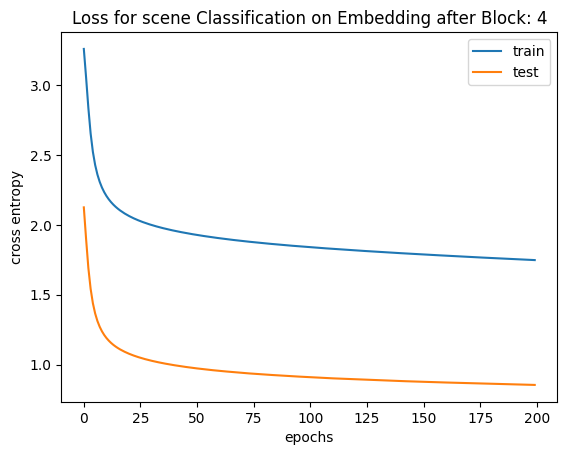

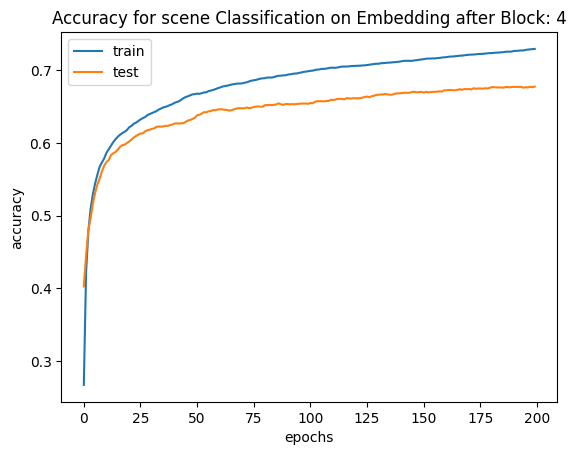

In [162]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [163]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [164]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [165]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [166]:
X_test=train_ready(test_data,col_name)

In [167]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

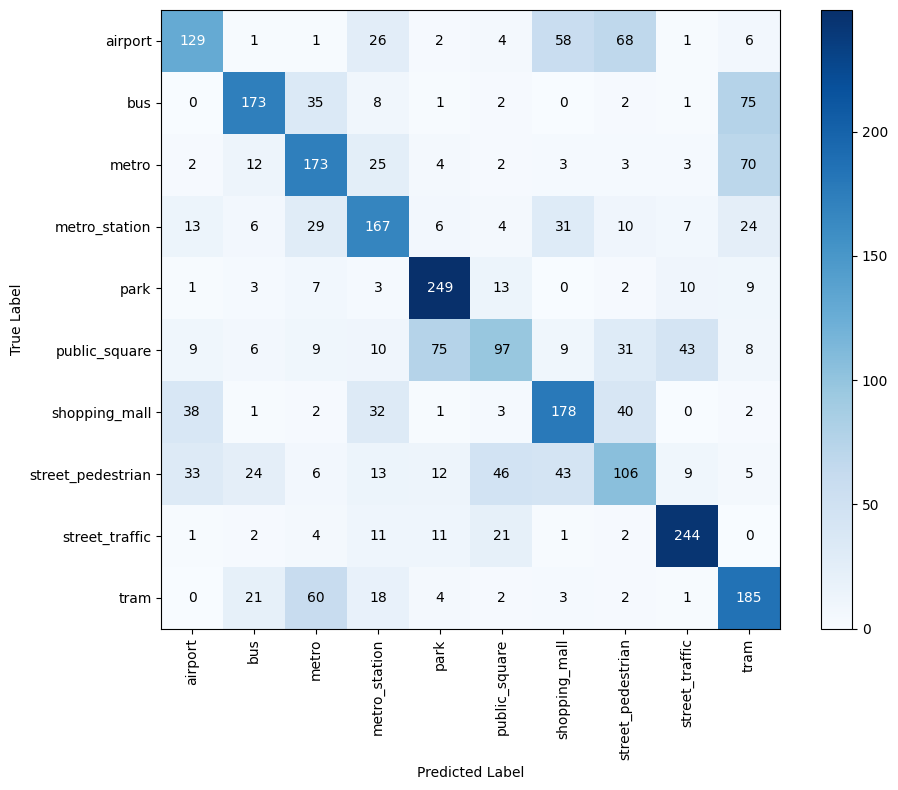

Accuracy: 0.5731


In [168]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-5

In [169]:
Block_number=5

In [170]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [171]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [172]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


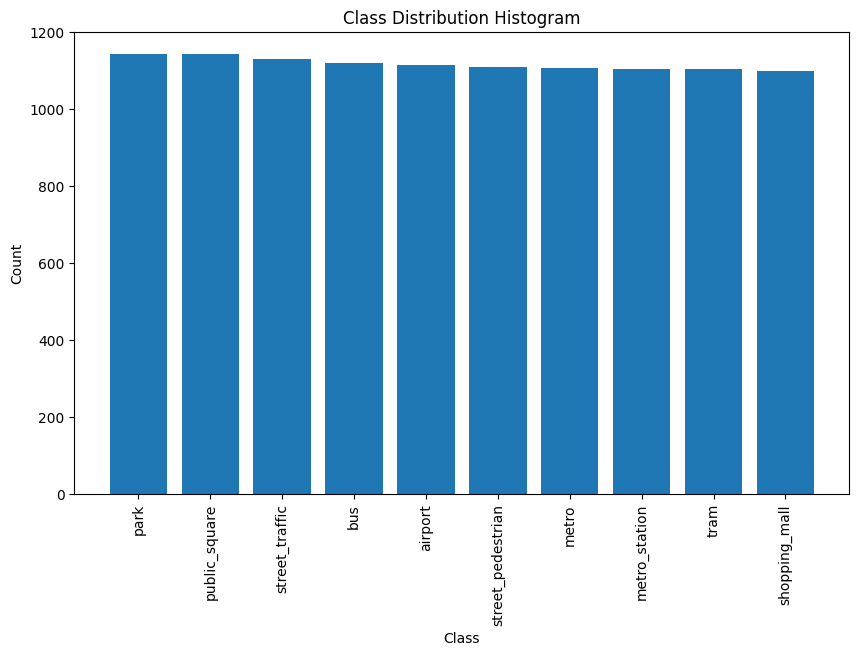

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [173]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


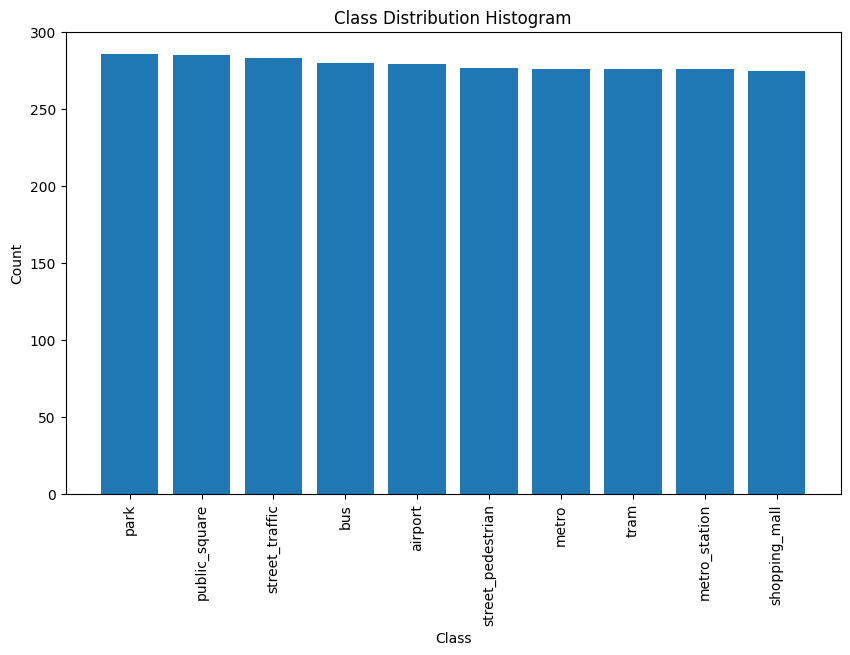

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [174]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [175]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [176]:
X_train_tensor.shape

torch.Size([11169, 768])

In [177]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [178]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 282.81batch/s, acc=0.469, loss=3.08]


Epoch 0 validation: Cross-entropy=2.05, Accuracy=43.9%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 322.14batch/s, acc=0.531, loss=2.76]


Epoch 1 validation: Cross-entropy=1.73, Accuracy=52.0%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 313.09batch/s, acc=0.578, loss=2.51]


Epoch 2 validation: Cross-entropy=1.49, Accuracy=55.2%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 386.05batch/s, acc=0.625, loss=2.35]


Epoch 3 validation: Cross-entropy=1.34, Accuracy=57.2%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 326.29batch/s, acc=0.578, loss=2.25]


Epoch 4 validation: Cross-entropy=1.24, Accuracy=58.6%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 393.60batch/s, acc=0.594, loss=2.18]


Epoch 5 validation: Cross-entropy=1.18, Accuracy=59.7%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 329.63batch/s, acc=0.594, loss=2.13]


Epoch 6 validation: Cross-entropy=1.13, Accuracy=60.4%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 395.36batch/s, acc=0.609, loss=2.09]


Epoch 7 validation: Cross-entropy=1.09, Accuracy=61.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 271.21batch/s, acc=0.625, loss=2.05]


Epoch 8 validation: Cross-entropy=1.06, Accuracy=61.5%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 400.32batch/s, acc=0.625, loss=2.02]


Epoch 9 validation: Cross-entropy=1.04, Accuracy=61.8%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 330.22batch/s, acc=0.625, loss=2]   


Epoch 10 validation: Cross-entropy=1.02, Accuracy=62.3%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 381.04batch/s, acc=0.625, loss=1.98]


Epoch 11 validation: Cross-entropy=1.00, Accuracy=62.7%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 329.19batch/s, acc=0.641, loss=1.96]


Epoch 12 validation: Cross-entropy=0.99, Accuracy=63.1%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 380.30batch/s, acc=0.641, loss=1.94]


Epoch 13 validation: Cross-entropy=0.98, Accuracy=63.2%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 326.80batch/s, acc=0.656, loss=1.93]


Epoch 14 validation: Cross-entropy=0.96, Accuracy=63.6%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 311.43batch/s, acc=0.688, loss=1.91]


Epoch 15 validation: Cross-entropy=0.95, Accuracy=64.1%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 318.58batch/s, acc=0.703, loss=1.9] 


Epoch 16 validation: Cross-entropy=0.94, Accuracy=64.3%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 316.70batch/s, acc=0.688, loss=1.89]


Epoch 17 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 400.48batch/s, acc=0.719, loss=1.88]


Epoch 18 validation: Cross-entropy=0.93, Accuracy=65.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 328.77batch/s, acc=0.719, loss=1.87]


Epoch 19 validation: Cross-entropy=0.92, Accuracy=65.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 333.46batch/s, acc=0.719, loss=1.86]


Epoch 20 validation: Cross-entropy=0.91, Accuracy=65.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 402.39batch/s, acc=0.719, loss=1.85]


Epoch 21 validation: Cross-entropy=0.91, Accuracy=65.4%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 273.56batch/s, acc=0.734, loss=1.84]


Epoch 22 validation: Cross-entropy=0.90, Accuracy=65.9%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 334.44batch/s, acc=0.734, loss=1.83]


Epoch 23 validation: Cross-entropy=0.90, Accuracy=66.0%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 394.46batch/s, acc=0.734, loss=1.82]


Epoch 24 validation: Cross-entropy=0.89, Accuracy=66.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 331.36batch/s, acc=0.719, loss=1.82]


Epoch 25 validation: Cross-entropy=0.88, Accuracy=66.2%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 394.00batch/s, acc=0.719, loss=1.81]


Epoch 26 validation: Cross-entropy=0.88, Accuracy=66.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 335.34batch/s, acc=0.719, loss=1.8] 


Epoch 27 validation: Cross-entropy=0.88, Accuracy=66.5%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 327.42batch/s, acc=0.734, loss=1.8] 


Epoch 28 validation: Cross-entropy=0.87, Accuracy=66.6%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 328.60batch/s, acc=0.734, loss=1.79]


Epoch 29 validation: Cross-entropy=0.87, Accuracy=66.8%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 321.61batch/s, acc=0.734, loss=1.78]


Epoch 30 validation: Cross-entropy=0.86, Accuracy=67.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 385.05batch/s, acc=0.734, loss=1.78]


Epoch 31 validation: Cross-entropy=0.86, Accuracy=67.1%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 321.90batch/s, acc=0.75, loss=1.77] 


Epoch 32 validation: Cross-entropy=0.86, Accuracy=67.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 326.82batch/s, acc=0.766, loss=1.77]


Epoch 33 validation: Cross-entropy=0.85, Accuracy=67.4%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 384.49batch/s, acc=0.766, loss=1.77]


Epoch 34 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 307.59batch/s, acc=0.766, loss=1.76]


Epoch 35 validation: Cross-entropy=0.85, Accuracy=67.6%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 276.89batch/s, acc=0.766, loss=1.76]


Epoch 36 validation: Cross-entropy=0.84, Accuracy=67.7%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 401.83batch/s, acc=0.766, loss=1.75]


Epoch 37 validation: Cross-entropy=0.84, Accuracy=67.7%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 341.48batch/s, acc=0.766, loss=1.75]


Epoch 38 validation: Cross-entropy=0.84, Accuracy=67.8%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 402.11batch/s, acc=0.766, loss=1.75]


Epoch 39 validation: Cross-entropy=0.83, Accuracy=68.0%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 321.11batch/s, acc=0.781, loss=1.74]


Epoch 40 validation: Cross-entropy=0.83, Accuracy=68.0%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 322.59batch/s, acc=0.781, loss=1.74]


Epoch 41 validation: Cross-entropy=0.83, Accuracy=68.2%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 409.93batch/s, acc=0.781, loss=1.74]


Epoch 42 validation: Cross-entropy=0.83, Accuracy=68.3%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 277.54batch/s, acc=0.781, loss=1.73]


Epoch 43 validation: Cross-entropy=0.82, Accuracy=68.3%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 372.74batch/s, acc=0.781, loss=1.73]


Epoch 44 validation: Cross-entropy=0.82, Accuracy=68.5%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 310.55batch/s, acc=0.766, loss=1.73]


Epoch 45 validation: Cross-entropy=0.82, Accuracy=68.7%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 389.09batch/s, acc=0.766, loss=1.72]


Epoch 46 validation: Cross-entropy=0.82, Accuracy=68.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 322.84batch/s, acc=0.766, loss=1.72]


Epoch 47 validation: Cross-entropy=0.81, Accuracy=68.8%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 326.75batch/s, acc=0.766, loss=1.72]


Epoch 48 validation: Cross-entropy=0.81, Accuracy=68.9%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 391.92batch/s, acc=0.766, loss=1.72]


Epoch 49 validation: Cross-entropy=0.81, Accuracy=68.9%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 276.50batch/s, acc=0.766, loss=1.71]


Epoch 50 validation: Cross-entropy=0.81, Accuracy=69.1%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 391.67batch/s, acc=0.766, loss=1.71]


Epoch 51 validation: Cross-entropy=0.81, Accuracy=69.2%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 329.24batch/s, acc=0.766, loss=1.71]


Epoch 52 validation: Cross-entropy=0.80, Accuracy=69.3%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 336.93batch/s, acc=0.766, loss=1.71]


Epoch 53 validation: Cross-entropy=0.80, Accuracy=69.4%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 387.01batch/s, acc=0.766, loss=1.71]


Epoch 54 validation: Cross-entropy=0.80, Accuracy=69.5%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 323.22batch/s, acc=0.766, loss=1.7] 


Epoch 55 validation: Cross-entropy=0.80, Accuracy=69.6%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 392.37batch/s, acc=0.766, loss=1.7] 


Epoch 56 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 272.75batch/s, acc=0.766, loss=1.7] 


Epoch 57 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 325.42batch/s, acc=0.766, loss=1.7] 


Epoch 58 validation: Cross-entropy=0.79, Accuracy=69.9%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 397.31batch/s, acc=0.75, loss=1.7]  


Epoch 59 validation: Cross-entropy=0.79, Accuracy=70.0%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 326.61batch/s, acc=0.75, loss=1.7]  


Epoch 60 validation: Cross-entropy=0.79, Accuracy=70.1%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 323.02batch/s, acc=0.75, loss=1.69] 


Epoch 61 validation: Cross-entropy=0.79, Accuracy=70.0%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 395.94batch/s, acc=0.75, loss=1.69] 


Epoch 62 validation: Cross-entropy=0.79, Accuracy=70.0%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 324.69batch/s, acc=0.75, loss=1.69] 


Epoch 63 validation: Cross-entropy=0.79, Accuracy=70.0%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 279.75batch/s, acc=0.75, loss=1.69] 


Epoch 64 validation: Cross-entropy=0.78, Accuracy=70.2%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 386.80batch/s, acc=0.75, loss=1.69] 


Epoch 65 validation: Cross-entropy=0.78, Accuracy=70.2%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 335.42batch/s, acc=0.75, loss=1.69] 


Epoch 66 validation: Cross-entropy=0.78, Accuracy=70.2%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 392.63batch/s, acc=0.75, loss=1.69] 


Epoch 67 validation: Cross-entropy=0.78, Accuracy=70.4%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 324.55batch/s, acc=0.75, loss=1.68] 


Epoch 68 validation: Cross-entropy=0.78, Accuracy=70.4%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 392.22batch/s, acc=0.75, loss=1.68] 


Epoch 69 validation: Cross-entropy=0.78, Accuracy=70.5%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 328.82batch/s, acc=0.75, loss=1.68] 


Epoch 70 validation: Cross-entropy=0.78, Accuracy=70.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 278.53batch/s, acc=0.75, loss=1.68] 


Epoch 71 validation: Cross-entropy=0.78, Accuracy=70.6%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 360.63batch/s, acc=0.75, loss=1.68] 


Epoch 72 validation: Cross-entropy=0.77, Accuracy=70.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 295.69batch/s, acc=0.75, loss=1.68] 


Epoch 73 validation: Cross-entropy=0.77, Accuracy=70.7%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 239.53batch/s, acc=0.75, loss=1.68] 


Epoch 74 validation: Cross-entropy=0.77, Accuracy=70.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 314.37batch/s, acc=0.75, loss=1.68] 


Epoch 75 validation: Cross-entropy=0.77, Accuracy=70.9%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 208.73batch/s, acc=0.75, loss=1.67] 


Epoch 76 validation: Cross-entropy=0.77, Accuracy=70.9%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 331.72batch/s, acc=0.75, loss=1.67] 


Epoch 77 validation: Cross-entropy=0.77, Accuracy=70.9%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 275.01batch/s, acc=0.75, loss=1.67] 


Epoch 78 validation: Cross-entropy=0.77, Accuracy=71.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 379.14batch/s, acc=0.75, loss=1.67] 


Epoch 79 validation: Cross-entropy=0.77, Accuracy=71.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 323.83batch/s, acc=0.75, loss=1.67] 


Epoch 80 validation: Cross-entropy=0.76, Accuracy=71.0%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 397.35batch/s, acc=0.75, loss=1.67] 


Epoch 81 validation: Cross-entropy=0.76, Accuracy=71.0%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 316.37batch/s, acc=0.75, loss=1.67] 


Epoch 82 validation: Cross-entropy=0.76, Accuracy=71.2%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 384.00batch/s, acc=0.75, loss=1.67] 


Epoch 83 validation: Cross-entropy=0.76, Accuracy=71.2%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 394.70batch/s, acc=0.75, loss=1.67] 


Epoch 84 validation: Cross-entropy=0.76, Accuracy=71.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 329.35batch/s, acc=0.75, loss=1.66] 


Epoch 85 validation: Cross-entropy=0.76, Accuracy=71.3%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 324.54batch/s, acc=0.75, loss=1.66] 


Epoch 86 validation: Cross-entropy=0.76, Accuracy=71.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 298.27batch/s, acc=0.75, loss=1.66] 


Epoch 87 validation: Cross-entropy=0.76, Accuracy=71.3%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 328.39batch/s, acc=0.75, loss=1.66] 


Epoch 88 validation: Cross-entropy=0.76, Accuracy=71.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 390.21batch/s, acc=0.75, loss=1.66] 


Epoch 89 validation: Cross-entropy=0.76, Accuracy=71.5%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 326.43batch/s, acc=0.75, loss=1.66] 


Epoch 90 validation: Cross-entropy=0.75, Accuracy=71.5%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 376.23batch/s, acc=0.75, loss=1.66] 


Epoch 91 validation: Cross-entropy=0.75, Accuracy=71.5%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 345.47batch/s, acc=0.75, loss=1.66] 


Epoch 92 validation: Cross-entropy=0.75, Accuracy=71.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 320.01batch/s, acc=0.75, loss=1.66] 


Epoch 93 validation: Cross-entropy=0.75, Accuracy=71.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 375.20batch/s, acc=0.75, loss=1.66] 


Epoch 94 validation: Cross-entropy=0.75, Accuracy=71.8%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 280.73batch/s, acc=0.75, loss=1.66] 


Epoch 95 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 335.08batch/s, acc=0.75, loss=1.66] 


Epoch 96 validation: Cross-entropy=0.75, Accuracy=71.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 369.45batch/s, acc=0.75, loss=1.65] 


Epoch 97 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 317.37batch/s, acc=0.75, loss=1.65] 


Epoch 98 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 394.21batch/s, acc=0.75, loss=1.65] 


Epoch 99 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 326.98batch/s, acc=0.75, loss=1.65] 


Epoch 100 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 328.28batch/s, acc=0.75, loss=1.65] 


Epoch 101 validation: Cross-entropy=0.74, Accuracy=72.0%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 314.34batch/s, acc=0.75, loss=1.65] 


Epoch 102 validation: Cross-entropy=0.74, Accuracy=72.0%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 329.39batch/s, acc=0.75, loss=1.65] 


Epoch 103 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 321.90batch/s, acc=0.75, loss=1.65] 


Epoch 104 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 388.77batch/s, acc=0.75, loss=1.65] 


Epoch 105 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 323.78batch/s, acc=0.75, loss=1.65] 


Epoch 106 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 368.76batch/s, acc=0.75, loss=1.65] 


Epoch 107 validation: Cross-entropy=0.74, Accuracy=71.8%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 346.64batch/s, acc=0.75, loss=1.65] 


Epoch 108 validation: Cross-entropy=0.74, Accuracy=71.8%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 281.19batch/s, acc=0.75, loss=1.65] 


Epoch 109 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 397.94batch/s, acc=0.766, loss=1.65]


Epoch 110 validation: Cross-entropy=0.74, Accuracy=72.0%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 326.22batch/s, acc=0.766, loss=1.65]


Epoch 111 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 393.38batch/s, acc=0.766, loss=1.65]


Epoch 112 validation: Cross-entropy=0.74, Accuracy=72.0%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 329.07batch/s, acc=0.766, loss=1.64]


Epoch 113 validation: Cross-entropy=0.74, Accuracy=72.0%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 321.32batch/s, acc=0.766, loss=1.64]


Epoch 114 validation: Cross-entropy=0.73, Accuracy=72.0%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 407.68batch/s, acc=0.766, loss=1.64]


Epoch 115 validation: Cross-entropy=0.73, Accuracy=72.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 264.83batch/s, acc=0.766, loss=1.64]


Epoch 116 validation: Cross-entropy=0.73, Accuracy=72.2%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 313.44batch/s, acc=0.766, loss=1.64]


Epoch 117 validation: Cross-entropy=0.73, Accuracy=72.3%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 392.29batch/s, acc=0.766, loss=1.64]


Epoch 118 validation: Cross-entropy=0.73, Accuracy=72.2%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 309.35batch/s, acc=0.766, loss=1.64]


Epoch 119 validation: Cross-entropy=0.73, Accuracy=72.3%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 360.10batch/s, acc=0.766, loss=1.64]


Epoch 120 validation: Cross-entropy=0.73, Accuracy=72.4%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 351.85batch/s, acc=0.766, loss=1.64]


Epoch 121 validation: Cross-entropy=0.73, Accuracy=72.4%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 324.20batch/s, acc=0.766, loss=1.64]


Epoch 122 validation: Cross-entropy=0.73, Accuracy=72.4%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 334.67batch/s, acc=0.766, loss=1.64]


Epoch 123 validation: Cross-entropy=0.73, Accuracy=72.4%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 325.35batch/s, acc=0.766, loss=1.64]


Epoch 124 validation: Cross-entropy=0.73, Accuracy=72.5%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 313.94batch/s, acc=0.766, loss=1.64]


Epoch 125 validation: Cross-entropy=0.73, Accuracy=72.5%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 398.76batch/s, acc=0.766, loss=1.64]


Epoch 126 validation: Cross-entropy=0.73, Accuracy=72.6%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 326.92batch/s, acc=0.766, loss=1.64]


Epoch 127 validation: Cross-entropy=0.73, Accuracy=72.5%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 391.82batch/s, acc=0.766, loss=1.63]


Epoch 128 validation: Cross-entropy=0.73, Accuracy=72.6%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 318.40batch/s, acc=0.766, loss=1.63]


Epoch 129 validation: Cross-entropy=0.73, Accuracy=72.6%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 280.16batch/s, acc=0.766, loss=1.63]


Epoch 130 validation: Cross-entropy=0.72, Accuracy=72.6%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 377.84batch/s, acc=0.766, loss=1.63]


Epoch 131 validation: Cross-entropy=0.72, Accuracy=72.7%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 320.29batch/s, acc=0.766, loss=1.63]


Epoch 132 validation: Cross-entropy=0.72, Accuracy=72.7%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 323.91batch/s, acc=0.766, loss=1.63]


Epoch 133 validation: Cross-entropy=0.72, Accuracy=72.7%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 396.53batch/s, acc=0.766, loss=1.63]


Epoch 134 validation: Cross-entropy=0.72, Accuracy=72.7%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 332.04batch/s, acc=0.766, loss=1.63]


Epoch 135 validation: Cross-entropy=0.72, Accuracy=72.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 329.01batch/s, acc=0.75, loss=1.63] 


Epoch 136 validation: Cross-entropy=0.72, Accuracy=72.8%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 321.50batch/s, acc=0.75, loss=1.63] 


Epoch 137 validation: Cross-entropy=0.72, Accuracy=72.8%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 317.74batch/s, acc=0.75, loss=1.63] 


Epoch 138 validation: Cross-entropy=0.72, Accuracy=72.8%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 391.36batch/s, acc=0.75, loss=1.63] 


Epoch 139 validation: Cross-entropy=0.72, Accuracy=72.9%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 327.82batch/s, acc=0.75, loss=1.63] 


Epoch 140 validation: Cross-entropy=0.72, Accuracy=73.0%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 329.72batch/s, acc=0.734, loss=1.63]


Epoch 141 validation: Cross-entropy=0.72, Accuracy=73.0%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 387.37batch/s, acc=0.734, loss=1.63]


Epoch 142 validation: Cross-entropy=0.72, Accuracy=73.0%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 327.16batch/s, acc=0.734, loss=1.63]


Epoch 143 validation: Cross-entropy=0.72, Accuracy=73.1%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 279.19batch/s, acc=0.734, loss=1.63]


Epoch 144 validation: Cross-entropy=0.72, Accuracy=73.1%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 393.35batch/s, acc=0.734, loss=1.63]


Epoch 145 validation: Cross-entropy=0.72, Accuracy=73.1%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 323.64batch/s, acc=0.734, loss=1.63]


Epoch 146 validation: Cross-entropy=0.72, Accuracy=73.1%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 399.76batch/s, acc=0.734, loss=1.63]


Epoch 147 validation: Cross-entropy=0.71, Accuracy=73.1%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 328.14batch/s, acc=0.734, loss=1.63]


Epoch 148 validation: Cross-entropy=0.71, Accuracy=73.1%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 393.80batch/s, acc=0.734, loss=1.63]


Epoch 149 validation: Cross-entropy=0.71, Accuracy=73.1%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 308.79batch/s, acc=0.734, loss=1.62]


Epoch 150 validation: Cross-entropy=0.71, Accuracy=73.2%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 281.64batch/s, acc=0.734, loss=1.62]


Epoch 151 validation: Cross-entropy=0.71, Accuracy=73.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 344.01batch/s, acc=0.734, loss=1.62]


Epoch 152 validation: Cross-entropy=0.71, Accuracy=73.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 356.18batch/s, acc=0.734, loss=1.62]


Epoch 153 validation: Cross-entropy=0.71, Accuracy=73.2%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 306.17batch/s, acc=0.734, loss=1.62]


Epoch 154 validation: Cross-entropy=0.71, Accuracy=73.3%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 402.71batch/s, acc=0.734, loss=1.62]


Epoch 155 validation: Cross-entropy=0.71, Accuracy=73.3%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 325.31batch/s, acc=0.734, loss=1.62]


Epoch 156 validation: Cross-entropy=0.71, Accuracy=73.3%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 390.27batch/s, acc=0.734, loss=1.62]


Epoch 157 validation: Cross-entropy=0.71, Accuracy=73.3%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 282.25batch/s, acc=0.734, loss=1.62]


Epoch 158 validation: Cross-entropy=0.71, Accuracy=73.4%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 309.63batch/s, acc=0.734, loss=1.62]


Epoch 159 validation: Cross-entropy=0.71, Accuracy=73.4%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 392.59batch/s, acc=0.734, loss=1.62]


Epoch 160 validation: Cross-entropy=0.71, Accuracy=73.4%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 325.61batch/s, acc=0.734, loss=1.62]


Epoch 161 validation: Cross-entropy=0.71, Accuracy=73.4%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 313.86batch/s, acc=0.734, loss=1.62]


Epoch 162 validation: Cross-entropy=0.71, Accuracy=73.5%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 391.66batch/s, acc=0.734, loss=1.62]


Epoch 163 validation: Cross-entropy=0.71, Accuracy=73.5%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 335.93batch/s, acc=0.734, loss=1.62]


Epoch 164 validation: Cross-entropy=0.71, Accuracy=73.5%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 336.42batch/s, acc=0.734, loss=1.62]


Epoch 165 validation: Cross-entropy=0.71, Accuracy=73.5%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 310.51batch/s, acc=0.734, loss=1.62]


Epoch 166 validation: Cross-entropy=0.71, Accuracy=73.5%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 324.17batch/s, acc=0.734, loss=1.62]


Epoch 167 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 390.46batch/s, acc=0.734, loss=1.62]


Epoch 168 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 326.24batch/s, acc=0.734, loss=1.62]


Epoch 169 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 400.82batch/s, acc=0.734, loss=1.62]


Epoch 170 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 327.28batch/s, acc=0.734, loss=1.62]


Epoch 171 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 275.47batch/s, acc=0.734, loss=1.61]


Epoch 172 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 388.30batch/s, acc=0.734, loss=1.61]


Epoch 173 validation: Cross-entropy=0.70, Accuracy=73.7%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 329.06batch/s, acc=0.734, loss=1.61]


Epoch 174 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 330.07batch/s, acc=0.734, loss=1.61]


Epoch 175 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 384.83batch/s, acc=0.734, loss=1.61]


Epoch 176 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 323.19batch/s, acc=0.734, loss=1.61]


Epoch 177 validation: Cross-entropy=0.70, Accuracy=73.7%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 328.58batch/s, acc=0.734, loss=1.61]


Epoch 178 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 338.49batch/s, acc=0.734, loss=1.61]


Epoch 179 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 317.74batch/s, acc=0.734, loss=1.61]


Epoch 180 validation: Cross-entropy=0.70, Accuracy=73.7%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 383.02batch/s, acc=0.734, loss=1.61]


Epoch 181 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 355.37batch/s, acc=0.734, loss=1.61]


Epoch 182 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 331.27batch/s, acc=0.734, loss=1.61]


Epoch 183 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 393.90batch/s, acc=0.734, loss=1.61]


Epoch 184 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 317.59batch/s, acc=0.734, loss=1.61]


Epoch 185 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 301.96batch/s, acc=0.734, loss=1.61]


Epoch 186 validation: Cross-entropy=0.70, Accuracy=73.8%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 366.44batch/s, acc=0.734, loss=1.61]


Epoch 187 validation: Cross-entropy=0.70, Accuracy=73.9%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 319.23batch/s, acc=0.734, loss=1.61]


Epoch 188 validation: Cross-entropy=0.70, Accuracy=73.9%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 396.02batch/s, acc=0.734, loss=1.61]


Epoch 189 validation: Cross-entropy=0.70, Accuracy=73.9%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 349.99batch/s, acc=0.734, loss=1.61]


Epoch 190 validation: Cross-entropy=0.70, Accuracy=73.9%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 334.01batch/s, acc=0.734, loss=1.61]


Epoch 191 validation: Cross-entropy=0.70, Accuracy=73.9%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 403.73batch/s, acc=0.734, loss=1.61]


Epoch 192 validation: Cross-entropy=0.70, Accuracy=73.9%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 333.94batch/s, acc=0.734, loss=1.61]


Epoch 193 validation: Cross-entropy=0.69, Accuracy=73.9%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 308.13batch/s, acc=0.734, loss=1.6] 


Epoch 194 validation: Cross-entropy=0.69, Accuracy=73.9%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 377.45batch/s, acc=0.734, loss=1.6] 


Epoch 195 validation: Cross-entropy=0.69, Accuracy=74.0%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 322.95batch/s, acc=0.734, loss=1.6] 


Epoch 196 validation: Cross-entropy=0.69, Accuracy=73.9%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 399.59batch/s, acc=0.734, loss=1.6] 


Epoch 197 validation: Cross-entropy=0.69, Accuracy=74.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 340.83batch/s, acc=0.734, loss=1.6] 


Epoch 198 validation: Cross-entropy=0.69, Accuracy=73.9%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 341.02batch/s, acc=0.734, loss=1.6] 


Epoch 199 validation: Cross-entropy=0.69, Accuracy=73.9%


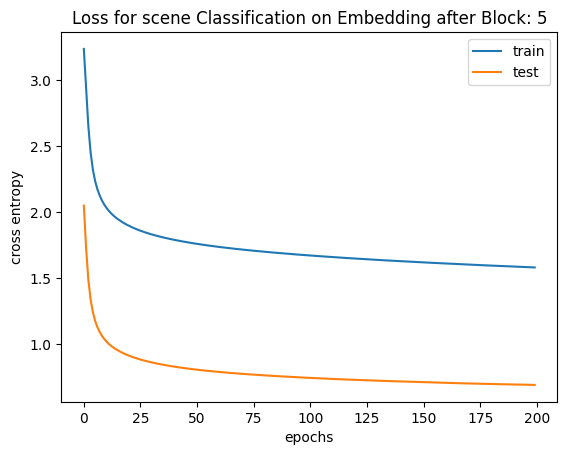

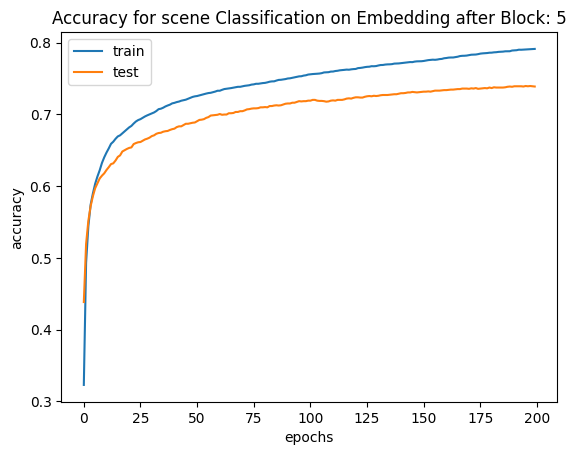

In [179]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [180]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [181]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [182]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [183]:
X_test=train_ready(test_data,col_name)

In [184]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

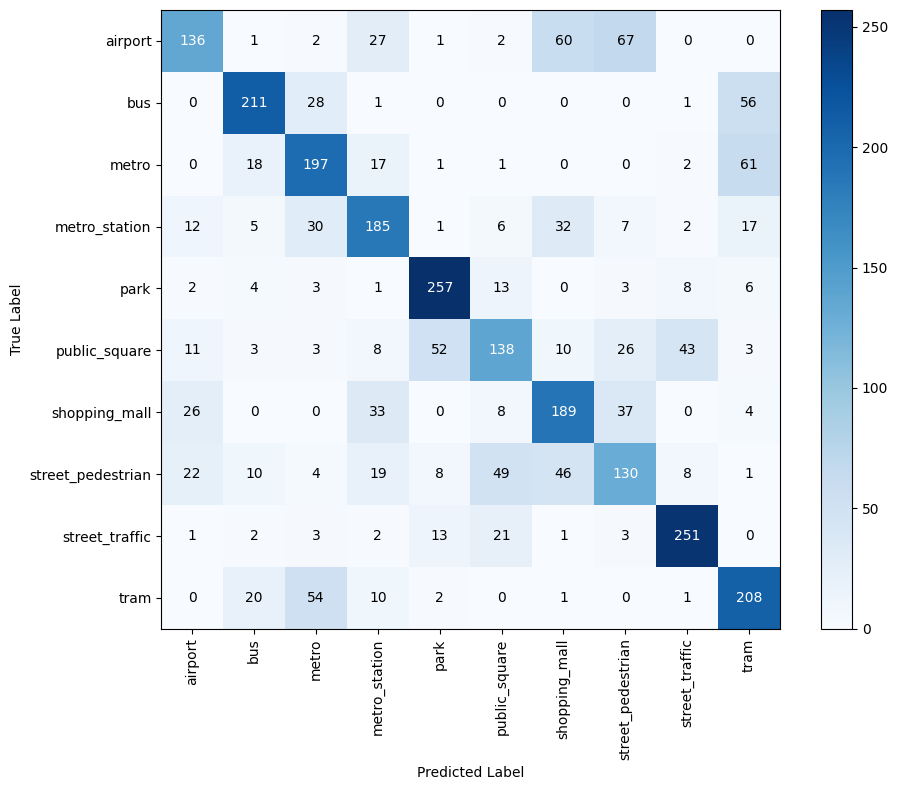

Accuracy: 0.6408


In [185]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-6

In [186]:
Block_number=6

In [187]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [188]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [189]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


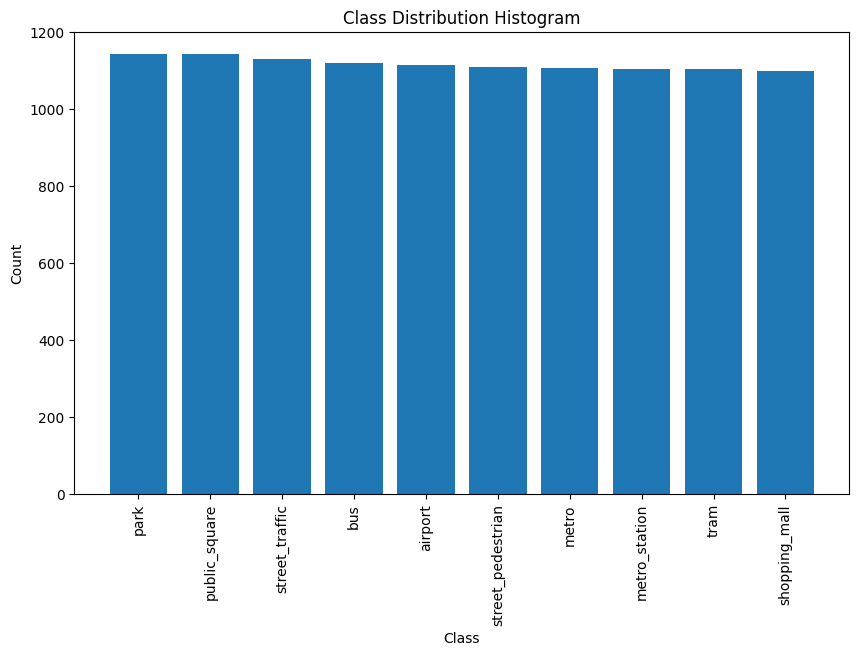

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [190]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


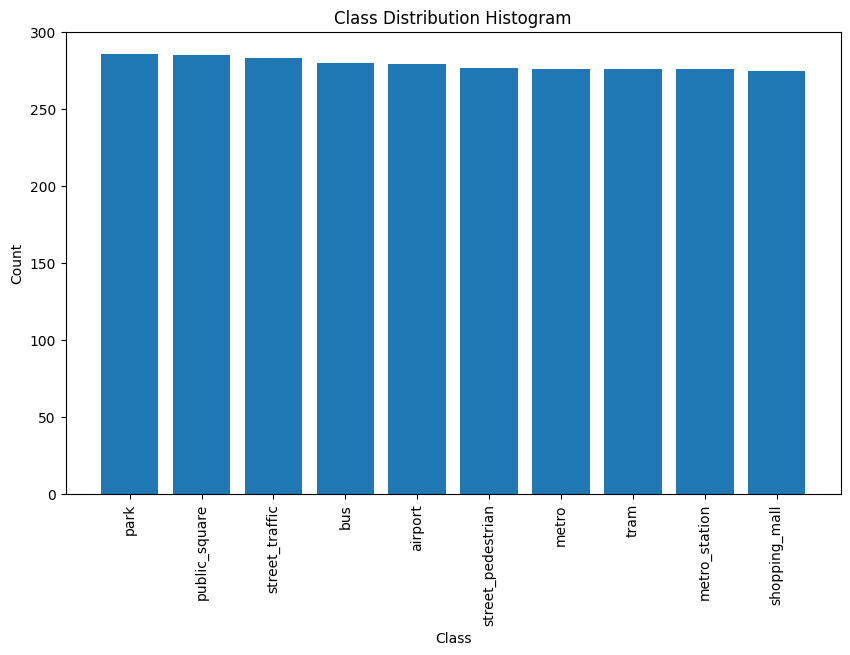

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [191]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [192]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [193]:
X_train_tensor.shape

torch.Size([11169, 768])

In [194]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [195]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 253.42batch/s, acc=0.594, loss=2.87]


Epoch 0 validation: Cross-entropy=1.80, Accuracy=53.0%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 304.20batch/s, acc=0.656, loss=2.42]


Epoch 1 validation: Cross-entropy=1.36, Accuracy=59.6%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 311.40batch/s, acc=0.719, loss=2.18]


Epoch 2 validation: Cross-entropy=1.15, Accuracy=62.5%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 365.88batch/s, acc=0.734, loss=2.05]


Epoch 3 validation: Cross-entropy=1.04, Accuracy=64.3%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 311.52batch/s, acc=0.75, loss=1.97] 


Epoch 4 validation: Cross-entropy=0.98, Accuracy=65.3%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 380.10batch/s, acc=0.75, loss=1.91] 


Epoch 5 validation: Cross-entropy=0.94, Accuracy=66.2%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 315.07batch/s, acc=0.766, loss=1.87]


Epoch 6 validation: Cross-entropy=0.91, Accuracy=67.0%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 329.47batch/s, acc=0.766, loss=1.84]


Epoch 7 validation: Cross-entropy=0.88, Accuracy=67.5%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 313.38batch/s, acc=0.781, loss=1.81]


Epoch 8 validation: Cross-entropy=0.86, Accuracy=68.1%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 381.61batch/s, acc=0.766, loss=1.79]


Epoch 9 validation: Cross-entropy=0.84, Accuracy=68.9%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 311.76batch/s, acc=0.766, loss=1.77]


Epoch 10 validation: Cross-entropy=0.82, Accuracy=69.3%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 384.76batch/s, acc=0.766, loss=1.76]


Epoch 11 validation: Cross-entropy=0.81, Accuracy=69.5%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 314.18batch/s, acc=0.766, loss=1.74]


Epoch 12 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 313.25batch/s, acc=0.75, loss=1.73] 


Epoch 13 validation: Cross-entropy=0.79, Accuracy=70.2%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 261.70batch/s, acc=0.75, loss=1.72] 


Epoch 14 validation: Cross-entropy=0.78, Accuracy=70.5%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 364.83batch/s, acc=0.75, loss=1.72] 


Epoch 15 validation: Cross-entropy=0.77, Accuracy=70.7%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 305.39batch/s, acc=0.75, loss=1.71] 


Epoch 16 validation: Cross-entropy=0.76, Accuracy=71.2%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 350.55batch/s, acc=0.75, loss=1.7]  


Epoch 17 validation: Cross-entropy=0.76, Accuracy=71.5%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 348.71batch/s, acc=0.75, loss=1.7]  


Epoch 18 validation: Cross-entropy=0.75, Accuracy=71.6%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 314.85batch/s, acc=0.75, loss=1.69] 


Epoch 19 validation: Cross-entropy=0.74, Accuracy=71.8%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 386.57batch/s, acc=0.75, loss=1.69] 


Epoch 20 validation: Cross-entropy=0.74, Accuracy=72.1%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 272.98batch/s, acc=0.75, loss=1.69] 


Epoch 21 validation: Cross-entropy=0.73, Accuracy=72.0%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 297.74batch/s, acc=0.734, loss=1.68]


Epoch 22 validation: Cross-entropy=0.73, Accuracy=72.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 386.16batch/s, acc=0.734, loss=1.68]


Epoch 23 validation: Cross-entropy=0.72, Accuracy=72.5%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 307.26batch/s, acc=0.734, loss=1.67]


Epoch 24 validation: Cross-entropy=0.72, Accuracy=72.6%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 310.70batch/s, acc=0.719, loss=1.67]


Epoch 25 validation: Cross-entropy=0.72, Accuracy=72.8%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 370.12batch/s, acc=0.719, loss=1.67]


Epoch 26 validation: Cross-entropy=0.71, Accuracy=73.1%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 313.28batch/s, acc=0.719, loss=1.67]


Epoch 27 validation: Cross-entropy=0.71, Accuracy=73.3%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 336.75batch/s, acc=0.719, loss=1.66]


Epoch 28 validation: Cross-entropy=0.70, Accuracy=73.4%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 288.32batch/s, acc=0.719, loss=1.66]


Epoch 29 validation: Cross-entropy=0.70, Accuracy=73.4%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 286.17batch/s, acc=0.719, loss=1.66]


Epoch 30 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 368.72batch/s, acc=0.734, loss=1.66]


Epoch 31 validation: Cross-entropy=0.69, Accuracy=73.7%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 272.64batch/s, acc=0.734, loss=1.66]


Epoch 32 validation: Cross-entropy=0.69, Accuracy=73.7%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 297.43batch/s, acc=0.734, loss=1.65]


Epoch 33 validation: Cross-entropy=0.69, Accuracy=73.8%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 369.65batch/s, acc=0.734, loss=1.65]


Epoch 34 validation: Cross-entropy=0.69, Accuracy=73.9%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 261.38batch/s, acc=0.734, loss=1.65]


Epoch 35 validation: Cross-entropy=0.68, Accuracy=73.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 288.24batch/s, acc=0.75, loss=1.65] 


Epoch 36 validation: Cross-entropy=0.68, Accuracy=74.0%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 268.68batch/s, acc=0.75, loss=1.65] 


Epoch 37 validation: Cross-entropy=0.68, Accuracy=74.0%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 260.90batch/s, acc=0.75, loss=1.65] 


Epoch 38 validation: Cross-entropy=0.68, Accuracy=74.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 281.76batch/s, acc=0.75, loss=1.64] 


Epoch 39 validation: Cross-entropy=0.67, Accuracy=74.2%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 208.07batch/s, acc=0.75, loss=1.64] 


Epoch 40 validation: Cross-entropy=0.67, Accuracy=74.4%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 312.11batch/s, acc=0.734, loss=1.64]


Epoch 41 validation: Cross-entropy=0.67, Accuracy=74.4%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 270.31batch/s, acc=0.734, loss=1.64]


Epoch 42 validation: Cross-entropy=0.67, Accuracy=74.5%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 367.45batch/s, acc=0.734, loss=1.64]


Epoch 43 validation: Cross-entropy=0.67, Accuracy=74.5%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 304.25batch/s, acc=0.734, loss=1.64]


Epoch 44 validation: Cross-entropy=0.66, Accuracy=74.6%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 374.85batch/s, acc=0.734, loss=1.64]


Epoch 45 validation: Cross-entropy=0.66, Accuracy=74.7%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 313.65batch/s, acc=0.734, loss=1.64]


Epoch 46 validation: Cross-entropy=0.66, Accuracy=74.8%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 377.61batch/s, acc=0.734, loss=1.64]


Epoch 47 validation: Cross-entropy=0.66, Accuracy=74.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 275.73batch/s, acc=0.734, loss=1.64]


Epoch 48 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 366.06batch/s, acc=0.734, loss=1.63]


Epoch 49 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 311.58batch/s, acc=0.734, loss=1.63]


Epoch 50 validation: Cross-entropy=0.65, Accuracy=75.2%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 380.50batch/s, acc=0.734, loss=1.63]


Epoch 51 validation: Cross-entropy=0.65, Accuracy=75.2%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 312.37batch/s, acc=0.734, loss=1.63]


Epoch 52 validation: Cross-entropy=0.65, Accuracy=75.2%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 378.88batch/s, acc=0.734, loss=1.63]


Epoch 53 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 312.44batch/s, acc=0.734, loss=1.63]


Epoch 54 validation: Cross-entropy=0.65, Accuracy=75.4%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 267.43batch/s, acc=0.734, loss=1.63]


Epoch 55 validation: Cross-entropy=0.65, Accuracy=75.4%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 384.02batch/s, acc=0.734, loss=1.63]


Epoch 56 validation: Cross-entropy=0.65, Accuracy=75.4%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 314.04batch/s, acc=0.734, loss=1.63]


Epoch 57 validation: Cross-entropy=0.64, Accuracy=75.3%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 320.21batch/s, acc=0.75, loss=1.63] 


Epoch 58 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 380.15batch/s, acc=0.75, loss=1.63] 


Epoch 59 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 321.54batch/s, acc=0.75, loss=1.63] 


Epoch 60 validation: Cross-entropy=0.64, Accuracy=75.3%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 378.28batch/s, acc=0.75, loss=1.62] 


Epoch 61 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 274.35batch/s, acc=0.75, loss=1.62] 


Epoch 62 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 320.14batch/s, acc=0.75, loss=1.62] 


Epoch 63 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 400.17batch/s, acc=0.734, loss=1.62]


Epoch 64 validation: Cross-entropy=0.64, Accuracy=75.5%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 321.73batch/s, acc=0.734, loss=1.62]


Epoch 65 validation: Cross-entropy=0.63, Accuracy=75.6%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 381.38batch/s, acc=0.734, loss=1.62]


Epoch 66 validation: Cross-entropy=0.63, Accuracy=75.7%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 312.78batch/s, acc=0.734, loss=1.62]


Epoch 67 validation: Cross-entropy=0.63, Accuracy=75.7%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 330.70batch/s, acc=0.734, loss=1.62]


Epoch 68 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 310.37batch/s, acc=0.734, loss=1.62]


Epoch 69 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 316.55batch/s, acc=0.734, loss=1.62]


Epoch 70 validation: Cross-entropy=0.63, Accuracy=75.7%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 388.58batch/s, acc=0.734, loss=1.61]


Epoch 71 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 325.95batch/s, acc=0.734, loss=1.61]


Epoch 72 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 322.83batch/s, acc=0.734, loss=1.61]


Epoch 73 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 388.97batch/s, acc=0.734, loss=1.61]


Epoch 74 validation: Cross-entropy=0.62, Accuracy=75.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 319.56batch/s, acc=0.734, loss=1.61]


Epoch 75 validation: Cross-entropy=0.62, Accuracy=75.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 266.50batch/s, acc=0.734, loss=1.61]


Epoch 76 validation: Cross-entropy=0.62, Accuracy=76.0%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 374.44batch/s, acc=0.734, loss=1.61]


Epoch 77 validation: Cross-entropy=0.62, Accuracy=76.0%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 328.08batch/s, acc=0.734, loss=1.61]


Epoch 78 validation: Cross-entropy=0.62, Accuracy=76.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 331.98batch/s, acc=0.734, loss=1.61]


Epoch 79 validation: Cross-entropy=0.62, Accuracy=76.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 389.66batch/s, acc=0.734, loss=1.61]


Epoch 80 validation: Cross-entropy=0.62, Accuracy=76.1%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 315.57batch/s, acc=0.734, loss=1.61]


Epoch 81 validation: Cross-entropy=0.62, Accuracy=76.1%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 331.45batch/s, acc=0.734, loss=1.6] 


Epoch 82 validation: Cross-entropy=0.62, Accuracy=76.2%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 311.71batch/s, acc=0.734, loss=1.6] 


Epoch 83 validation: Cross-entropy=0.62, Accuracy=76.2%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 323.37batch/s, acc=0.734, loss=1.6] 


Epoch 84 validation: Cross-entropy=0.62, Accuracy=76.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 379.30batch/s, acc=0.734, loss=1.6] 


Epoch 85 validation: Cross-entropy=0.62, Accuracy=76.2%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 324.19batch/s, acc=0.734, loss=1.6] 


Epoch 86 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 299.93batch/s, acc=0.734, loss=1.6] 


Epoch 87 validation: Cross-entropy=0.61, Accuracy=76.3%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 385.35batch/s, acc=0.734, loss=1.6] 


Epoch 88 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 325.42batch/s, acc=0.734, loss=1.6] 


Epoch 89 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 316.65batch/s, acc=0.734, loss=1.6] 


Epoch 90 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 317.62batch/s, acc=0.734, loss=1.6] 


Epoch 91 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 332.78batch/s, acc=0.734, loss=1.59]


Epoch 92 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 394.12batch/s, acc=0.734, loss=1.59]


Epoch 93 validation: Cross-entropy=0.61, Accuracy=76.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 313.62batch/s, acc=0.734, loss=1.59]


Epoch 94 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 309.40batch/s, acc=0.734, loss=1.59]


Epoch 95 validation: Cross-entropy=0.61, Accuracy=76.3%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 393.10batch/s, acc=0.734, loss=1.59]


Epoch 96 validation: Cross-entropy=0.61, Accuracy=76.2%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 267.79batch/s, acc=0.734, loss=1.59]


Epoch 97 validation: Cross-entropy=0.61, Accuracy=76.3%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 369.66batch/s, acc=0.734, loss=1.59]


Epoch 98 validation: Cross-entropy=0.61, Accuracy=76.3%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 343.11batch/s, acc=0.734, loss=1.59]


Epoch 99 validation: Cross-entropy=0.61, Accuracy=76.4%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 315.48batch/s, acc=0.734, loss=1.59]


Epoch 100 validation: Cross-entropy=0.61, Accuracy=76.4%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 374.46batch/s, acc=0.734, loss=1.59]


Epoch 101 validation: Cross-entropy=0.60, Accuracy=76.4%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 316.71batch/s, acc=0.734, loss=1.59]


Epoch 102 validation: Cross-entropy=0.60, Accuracy=76.5%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 314.54batch/s, acc=0.734, loss=1.59]


Epoch 103 validation: Cross-entropy=0.60, Accuracy=76.5%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 324.12batch/s, acc=0.734, loss=1.58]


Epoch 104 validation: Cross-entropy=0.60, Accuracy=76.6%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 316.75batch/s, acc=0.734, loss=1.58]


Epoch 105 validation: Cross-entropy=0.60, Accuracy=76.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 327.73batch/s, acc=0.734, loss=1.58]


Epoch 106 validation: Cross-entropy=0.60, Accuracy=76.7%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 377.01batch/s, acc=0.734, loss=1.58]


Epoch 107 validation: Cross-entropy=0.60, Accuracy=76.9%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 317.40batch/s, acc=0.734, loss=1.58]


Epoch 108 validation: Cross-entropy=0.60, Accuracy=76.9%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 327.70batch/s, acc=0.734, loss=1.58]


Epoch 109 validation: Cross-entropy=0.60, Accuracy=76.9%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 371.99batch/s, acc=0.734, loss=1.58]


Epoch 110 validation: Cross-entropy=0.60, Accuracy=76.9%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 277.53batch/s, acc=0.734, loss=1.58]


Epoch 111 validation: Cross-entropy=0.60, Accuracy=76.9%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 380.14batch/s, acc=0.734, loss=1.58]


Epoch 112 validation: Cross-entropy=0.60, Accuracy=76.9%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 312.05batch/s, acc=0.734, loss=1.58]


Epoch 113 validation: Cross-entropy=0.60, Accuracy=77.0%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 304.48batch/s, acc=0.734, loss=1.58]


Epoch 114 validation: Cross-entropy=0.60, Accuracy=77.0%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 365.10batch/s, acc=0.734, loss=1.57]


Epoch 115 validation: Cross-entropy=0.60, Accuracy=77.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 311.19batch/s, acc=0.734, loss=1.57]


Epoch 116 validation: Cross-entropy=0.60, Accuracy=77.2%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 333.89batch/s, acc=0.734, loss=1.57]


Epoch 117 validation: Cross-entropy=0.60, Accuracy=77.2%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 312.24batch/s, acc=0.734, loss=1.57]


Epoch 118 validation: Cross-entropy=0.60, Accuracy=77.2%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 311.55batch/s, acc=0.734, loss=1.57]


Epoch 119 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 401.49batch/s, acc=0.734, loss=1.57]


Epoch 120 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 310.05batch/s, acc=0.734, loss=1.57]


Epoch 121 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 317.00batch/s, acc=0.734, loss=1.57]


Epoch 122 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 393.43batch/s, acc=0.734, loss=1.57]


Epoch 123 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 315.08batch/s, acc=0.734, loss=1.57]


Epoch 124 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 326.97batch/s, acc=0.734, loss=1.57]


Epoch 125 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 312.71batch/s, acc=0.734, loss=1.56]


Epoch 126 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 318.82batch/s, acc=0.734, loss=1.56]


Epoch 127 validation: Cross-entropy=0.59, Accuracy=77.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 386.58batch/s, acc=0.734, loss=1.56]


Epoch 128 validation: Cross-entropy=0.59, Accuracy=77.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 309.56batch/s, acc=0.734, loss=1.56]


Epoch 129 validation: Cross-entropy=0.59, Accuracy=77.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 359.00batch/s, acc=0.734, loss=1.56]


Epoch 130 validation: Cross-entropy=0.59, Accuracy=77.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 352.23batch/s, acc=0.734, loss=1.56]


Epoch 131 validation: Cross-entropy=0.59, Accuracy=77.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 268.55batch/s, acc=0.734, loss=1.56]


Epoch 132 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 381.13batch/s, acc=0.734, loss=1.56]


Epoch 133 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 309.09batch/s, acc=0.734, loss=1.56]


Epoch 134 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 335.60batch/s, acc=0.734, loss=1.56]


Epoch 135 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 361.93batch/s, acc=0.734, loss=1.56]


Epoch 136 validation: Cross-entropy=0.59, Accuracy=77.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 318.02batch/s, acc=0.734, loss=1.55]


Epoch 137 validation: Cross-entropy=0.59, Accuracy=77.5%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 321.49batch/s, acc=0.734, loss=1.55]


Epoch 138 validation: Cross-entropy=0.59, Accuracy=77.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 326.46batch/s, acc=0.734, loss=1.55]


Epoch 139 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 308.66batch/s, acc=0.75, loss=1.55] 


Epoch 140 validation: Cross-entropy=0.59, Accuracy=77.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 366.34batch/s, acc=0.75, loss=1.55] 


Epoch 141 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 319.50batch/s, acc=0.75, loss=1.55] 


Epoch 142 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 378.56batch/s, acc=0.75, loss=1.55] 


Epoch 143 validation: Cross-entropy=0.58, Accuracy=77.4%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 289.35batch/s, acc=0.75, loss=1.55] 


Epoch 144 validation: Cross-entropy=0.58, Accuracy=77.4%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 299.24batch/s, acc=0.75, loss=1.55] 


Epoch 145 validation: Cross-entropy=0.58, Accuracy=77.5%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 197.76batch/s, acc=0.75, loss=1.55] 


Epoch 146 validation: Cross-entropy=0.58, Accuracy=77.7%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 307.89batch/s, acc=0.75, loss=1.55] 


Epoch 147 validation: Cross-entropy=0.58, Accuracy=77.6%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 252.33batch/s, acc=0.766, loss=1.54]


Epoch 148 validation: Cross-entropy=0.58, Accuracy=77.6%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 324.70batch/s, acc=0.766, loss=1.54]


Epoch 149 validation: Cross-entropy=0.58, Accuracy=77.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 265.61batch/s, acc=0.766, loss=1.54]


Epoch 150 validation: Cross-entropy=0.58, Accuracy=77.6%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 305.64batch/s, acc=0.766, loss=1.54]


Epoch 151 validation: Cross-entropy=0.58, Accuracy=77.6%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 221.17batch/s, acc=0.766, loss=1.54]


Epoch 152 validation: Cross-entropy=0.58, Accuracy=77.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 365.26batch/s, acc=0.766, loss=1.54]


Epoch 153 validation: Cross-entropy=0.58, Accuracy=77.7%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 319.37batch/s, acc=0.766, loss=1.54]


Epoch 154 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 364.80batch/s, acc=0.766, loss=1.54]


Epoch 155 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 388.89batch/s, acc=0.766, loss=1.54]


Epoch 156 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 319.93batch/s, acc=0.766, loss=1.54]


Epoch 157 validation: Cross-entropy=0.58, Accuracy=77.9%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 375.16batch/s, acc=0.766, loss=1.53]


Epoch 158 validation: Cross-entropy=0.58, Accuracy=78.0%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 300.98batch/s, acc=0.766, loss=1.53]


Epoch 159 validation: Cross-entropy=0.58, Accuracy=78.0%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 370.77batch/s, acc=0.766, loss=1.53]


Epoch 160 validation: Cross-entropy=0.58, Accuracy=78.0%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 261.48batch/s, acc=0.766, loss=1.53]


Epoch 161 validation: Cross-entropy=0.58, Accuracy=78.1%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 387.42batch/s, acc=0.766, loss=1.53]


Epoch 162 validation: Cross-entropy=0.58, Accuracy=78.1%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 321.13batch/s, acc=0.766, loss=1.53]


Epoch 163 validation: Cross-entropy=0.58, Accuracy=78.1%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 312.23batch/s, acc=0.766, loss=1.53]


Epoch 164 validation: Cross-entropy=0.58, Accuracy=78.2%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 324.09batch/s, acc=0.766, loss=1.53]


Epoch 165 validation: Cross-entropy=0.58, Accuracy=78.3%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 367.80batch/s, acc=0.766, loss=1.53]


Epoch 166 validation: Cross-entropy=0.58, Accuracy=78.2%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 299.25batch/s, acc=0.766, loss=1.53]


Epoch 167 validation: Cross-entropy=0.58, Accuracy=78.2%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 311.39batch/s, acc=0.766, loss=1.53]


Epoch 168 validation: Cross-entropy=0.58, Accuracy=78.3%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 309.66batch/s, acc=0.766, loss=1.52]


Epoch 169 validation: Cross-entropy=0.58, Accuracy=78.4%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 324.21batch/s, acc=0.766, loss=1.52]


Epoch 170 validation: Cross-entropy=0.58, Accuracy=78.3%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 378.62batch/s, acc=0.766, loss=1.52]


Epoch 171 validation: Cross-entropy=0.58, Accuracy=78.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 316.86batch/s, acc=0.766, loss=1.52]


Epoch 172 validation: Cross-entropy=0.58, Accuracy=78.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 378.58batch/s, acc=0.766, loss=1.52]


Epoch 173 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 315.25batch/s, acc=0.766, loss=1.52]


Epoch 174 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 262.64batch/s, acc=0.766, loss=1.52]


Epoch 175 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 373.85batch/s, acc=0.766, loss=1.52]


Epoch 176 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 312.21batch/s, acc=0.766, loss=1.52]


Epoch 177 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 317.22batch/s, acc=0.766, loss=1.51]


Epoch 178 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 384.31batch/s, acc=0.766, loss=1.51]


Epoch 179 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 324.61batch/s, acc=0.766, loss=1.51]


Epoch 180 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 320.99batch/s, acc=0.766, loss=1.51]


Epoch 181 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 332.28batch/s, acc=0.766, loss=1.51]


Epoch 182 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 318.32batch/s, acc=0.766, loss=1.51]


Epoch 183 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 316.22batch/s, acc=0.766, loss=1.51]


Epoch 184 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 396.79batch/s, acc=0.766, loss=1.51]


Epoch 185 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 336.37batch/s, acc=0.766, loss=1.51]


Epoch 186 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 331.79batch/s, acc=0.766, loss=1.51]


Epoch 187 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 373.68batch/s, acc=0.766, loss=1.5] 


Epoch 188 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 277.34batch/s, acc=0.766, loss=1.5] 


Epoch 189 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 379.15batch/s, acc=0.766, loss=1.5] 


Epoch 190 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 321.20batch/s, acc=0.766, loss=1.5] 


Epoch 191 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 317.77batch/s, acc=0.766, loss=1.5] 


Epoch 192 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 390.50batch/s, acc=0.766, loss=1.5] 


Epoch 193 validation: Cross-entropy=0.57, Accuracy=78.7%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 317.22batch/s, acc=0.766, loss=1.5] 


Epoch 194 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 333.18batch/s, acc=0.766, loss=1.5] 


Epoch 195 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 312.48batch/s, acc=0.766, loss=1.5] 


Epoch 196 validation: Cross-entropy=0.57, Accuracy=78.7%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 311.91batch/s, acc=0.766, loss=1.5] 


Epoch 197 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 356.16batch/s, acc=0.766, loss=1.5] 


Epoch 198 validation: Cross-entropy=0.57, Accuracy=78.7%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 340.23batch/s, acc=0.766, loss=1.49]


Epoch 199 validation: Cross-entropy=0.57, Accuracy=78.6%


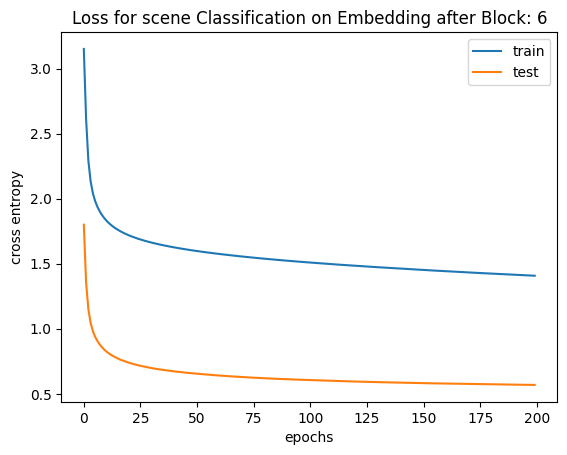

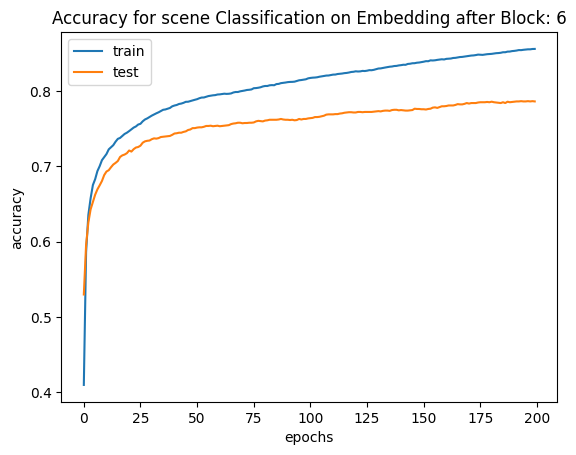

In [196]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [197]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [198]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [199]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [200]:
X_test=train_ready(test_data,col_name)

In [201]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

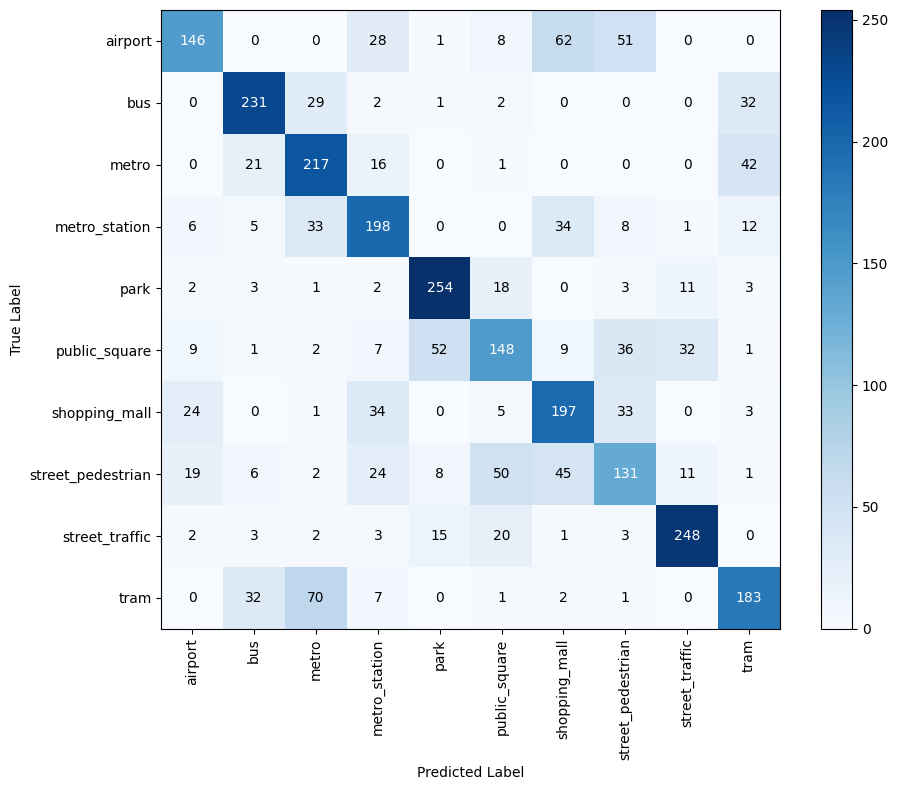

Accuracy: 0.6580


In [202]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-7

In [203]:
Block_number=7

In [204]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [205]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [206]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


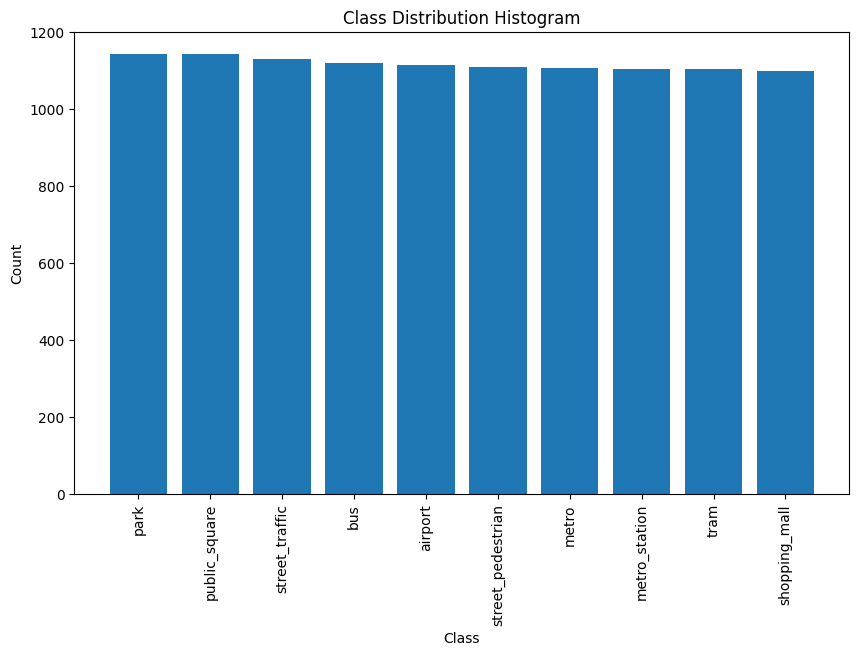

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [207]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


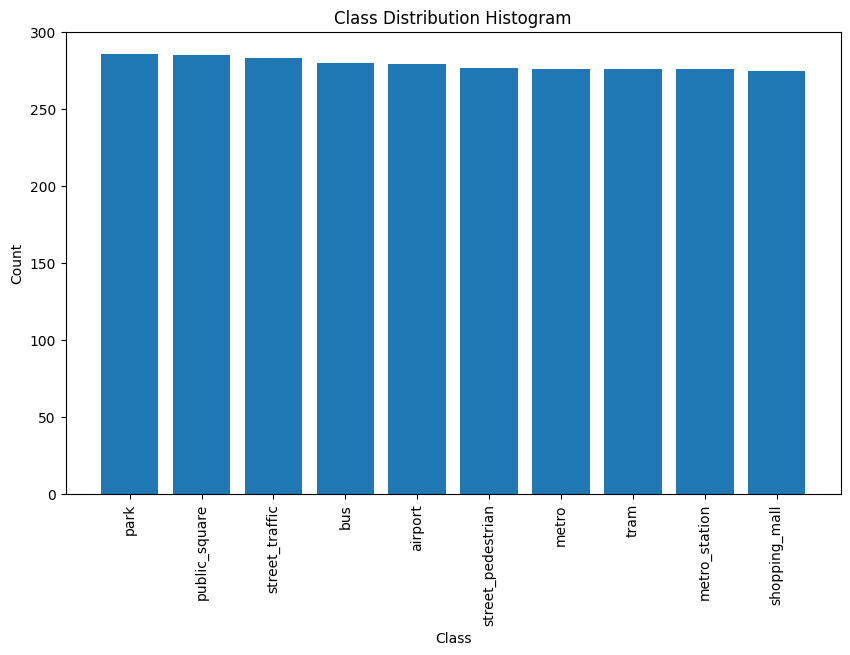

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [208]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [209]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [210]:
X_train_tensor.shape

torch.Size([11169, 768])

In [211]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [212]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 285.75batch/s, acc=0.656, loss=2.72]


Epoch 0 validation: Cross-entropy=1.62, Accuracy=59.8%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 319.62batch/s, acc=0.703, loss=2.24]


Epoch 1 validation: Cross-entropy=1.17, Accuracy=65.1%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 396.60batch/s, acc=0.734, loss=2.03]


Epoch 2 validation: Cross-entropy=0.99, Accuracy=67.7%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 327.88batch/s, acc=0.719, loss=1.92]


Epoch 3 validation: Cross-entropy=0.89, Accuracy=68.7%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 384.63batch/s, acc=0.766, loss=1.85]


Epoch 4 validation: Cross-entropy=0.83, Accuracy=69.8%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 277.04batch/s, acc=0.766, loss=1.8] 


Epoch 5 validation: Cross-entropy=0.80, Accuracy=71.0%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 392.54batch/s, acc=0.766, loss=1.76]


Epoch 6 validation: Cross-entropy=0.77, Accuracy=71.7%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 331.56batch/s, acc=0.766, loss=1.73]


Epoch 7 validation: Cross-entropy=0.74, Accuracy=72.5%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 386.19batch/s, acc=0.781, loss=1.71]


Epoch 8 validation: Cross-entropy=0.72, Accuracy=73.4%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 401.59batch/s, acc=0.781, loss=1.7] 


Epoch 9 validation: Cross-entropy=0.71, Accuracy=74.1%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 306.49batch/s, acc=0.781, loss=1.68]


Epoch 10 validation: Cross-entropy=0.69, Accuracy=74.8%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 394.24batch/s, acc=0.797, loss=1.67]


Epoch 11 validation: Cross-entropy=0.68, Accuracy=75.1%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 275.16batch/s, acc=0.797, loss=1.66]


Epoch 12 validation: Cross-entropy=0.67, Accuracy=75.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 386.76batch/s, acc=0.797, loss=1.65]


Epoch 13 validation: Cross-entropy=0.66, Accuracy=75.7%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 323.58batch/s, acc=0.781, loss=1.64]


Epoch 14 validation: Cross-entropy=0.65, Accuracy=76.2%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 401.36batch/s, acc=0.797, loss=1.64]


Epoch 15 validation: Cross-entropy=0.65, Accuracy=76.4%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 316.42batch/s, acc=0.797, loss=1.63]


Epoch 16 validation: Cross-entropy=0.64, Accuracy=76.5%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 400.50batch/s, acc=0.797, loss=1.63]


Epoch 17 validation: Cross-entropy=0.63, Accuracy=76.5%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 320.68batch/s, acc=0.797, loss=1.62]


Epoch 18 validation: Cross-entropy=0.63, Accuracy=76.8%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 336.23batch/s, acc=0.797, loss=1.62]


Epoch 19 validation: Cross-entropy=0.62, Accuracy=77.0%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 329.20batch/s, acc=0.797, loss=1.61]


Epoch 20 validation: Cross-entropy=0.62, Accuracy=77.1%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 348.90batch/s, acc=0.797, loss=1.61]


Epoch 21 validation: Cross-entropy=0.61, Accuracy=77.3%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 378.19batch/s, acc=0.797, loss=1.61]


Epoch 22 validation: Cross-entropy=0.61, Accuracy=77.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 326.06batch/s, acc=0.781, loss=1.6] 


Epoch 23 validation: Cross-entropy=0.61, Accuracy=77.5%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 327.11batch/s, acc=0.781, loss=1.6] 


Epoch 24 validation: Cross-entropy=0.60, Accuracy=77.6%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 399.22batch/s, acc=0.781, loss=1.59]


Epoch 25 validation: Cross-entropy=0.60, Accuracy=77.7%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 285.73batch/s, acc=0.781, loss=1.59]


Epoch 26 validation: Cross-entropy=0.59, Accuracy=77.8%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 397.59batch/s, acc=0.781, loss=1.59]


Epoch 27 validation: Cross-entropy=0.59, Accuracy=77.9%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 332.32batch/s, acc=0.781, loss=1.58]


Epoch 28 validation: Cross-entropy=0.59, Accuracy=78.2%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 410.19batch/s, acc=0.781, loss=1.58]


Epoch 29 validation: Cross-entropy=0.58, Accuracy=78.2%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 339.06batch/s, acc=0.781, loss=1.58]


Epoch 30 validation: Cross-entropy=0.58, Accuracy=78.4%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 296.37batch/s, acc=0.781, loss=1.58]


Epoch 31 validation: Cross-entropy=0.58, Accuracy=78.4%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 385.20batch/s, acc=0.781, loss=1.58]


Epoch 32 validation: Cross-entropy=0.58, Accuracy=78.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 231.77batch/s, acc=0.781, loss=1.57]


Epoch 33 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 281.92batch/s, acc=0.797, loss=1.57]


Epoch 34 validation: Cross-entropy=0.57, Accuracy=78.8%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 309.01batch/s, acc=0.781, loss=1.57]


Epoch 35 validation: Cross-entropy=0.57, Accuracy=79.0%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 274.37batch/s, acc=0.781, loss=1.57]


Epoch 36 validation: Cross-entropy=0.57, Accuracy=79.2%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 352.71batch/s, acc=0.781, loss=1.56]


Epoch 37 validation: Cross-entropy=0.56, Accuracy=79.2%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 267.28batch/s, acc=0.797, loss=1.56]


Epoch 38 validation: Cross-entropy=0.56, Accuracy=79.3%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 392.65batch/s, acc=0.797, loss=1.56]


Epoch 39 validation: Cross-entropy=0.56, Accuracy=79.3%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 315.22batch/s, acc=0.797, loss=1.56]


Epoch 40 validation: Cross-entropy=0.56, Accuracy=79.4%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 392.77batch/s, acc=0.797, loss=1.56]


Epoch 41 validation: Cross-entropy=0.56, Accuracy=79.4%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 391.50batch/s, acc=0.797, loss=1.55]


Epoch 42 validation: Cross-entropy=0.55, Accuracy=79.5%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 323.30batch/s, acc=0.797, loss=1.55]


Epoch 43 validation: Cross-entropy=0.55, Accuracy=79.4%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 395.88batch/s, acc=0.797, loss=1.55]


Epoch 44 validation: Cross-entropy=0.55, Accuracy=79.6%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 328.56batch/s, acc=0.797, loss=1.55]


Epoch 45 validation: Cross-entropy=0.55, Accuracy=79.5%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 400.51batch/s, acc=0.797, loss=1.55]


Epoch 46 validation: Cross-entropy=0.55, Accuracy=79.6%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 324.56batch/s, acc=0.797, loss=1.54]


Epoch 47 validation: Cross-entropy=0.55, Accuracy=79.6%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 319.52batch/s, acc=0.797, loss=1.54]


Epoch 48 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 316.17batch/s, acc=0.797, loss=1.54]


Epoch 49 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 327.54batch/s, acc=0.797, loss=1.54]


Epoch 50 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 388.04batch/s, acc=0.797, loss=1.54]


Epoch 51 validation: Cross-entropy=0.54, Accuracy=79.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 323.00batch/s, acc=0.797, loss=1.53]


Epoch 52 validation: Cross-entropy=0.54, Accuracy=79.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 327.53batch/s, acc=0.797, loss=1.53]


Epoch 53 validation: Cross-entropy=0.54, Accuracy=80.1%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 390.40batch/s, acc=0.797, loss=1.53]


Epoch 54 validation: Cross-entropy=0.54, Accuracy=80.2%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 266.01batch/s, acc=0.797, loss=1.53]


Epoch 55 validation: Cross-entropy=0.53, Accuracy=80.5%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 327.33batch/s, acc=0.797, loss=1.52]


Epoch 56 validation: Cross-entropy=0.53, Accuracy=80.5%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 386.74batch/s, acc=0.797, loss=1.52]


Epoch 57 validation: Cross-entropy=0.53, Accuracy=80.5%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 394.19batch/s, acc=0.797, loss=1.52]


Epoch 58 validation: Cross-entropy=0.53, Accuracy=80.6%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 337.21batch/s, acc=0.797, loss=1.52]


Epoch 59 validation: Cross-entropy=0.53, Accuracy=80.6%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 399.65batch/s, acc=0.797, loss=1.52]


Epoch 60 validation: Cross-entropy=0.53, Accuracy=80.6%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 320.25batch/s, acc=0.797, loss=1.51]


Epoch 61 validation: Cross-entropy=0.53, Accuracy=80.6%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 327.83batch/s, acc=0.797, loss=1.51]


Epoch 62 validation: Cross-entropy=0.52, Accuracy=80.6%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 320.84batch/s, acc=0.797, loss=1.51]


Epoch 63 validation: Cross-entropy=0.52, Accuracy=80.6%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 327.48batch/s, acc=0.797, loss=1.51]


Epoch 64 validation: Cross-entropy=0.52, Accuracy=80.6%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 361.40batch/s, acc=0.797, loss=1.51]


Epoch 65 validation: Cross-entropy=0.52, Accuracy=80.6%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 382.21batch/s, acc=0.797, loss=1.5] 


Epoch 66 validation: Cross-entropy=0.52, Accuracy=80.6%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 330.92batch/s, acc=0.797, loss=1.5] 


Epoch 67 validation: Cross-entropy=0.52, Accuracy=80.5%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 366.33batch/s, acc=0.797, loss=1.5] 


Epoch 68 validation: Cross-entropy=0.52, Accuracy=80.4%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 312.27batch/s, acc=0.797, loss=1.5] 


Epoch 69 validation: Cross-entropy=0.52, Accuracy=80.5%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 382.55batch/s, acc=0.797, loss=1.5] 


Epoch 70 validation: Cross-entropy=0.52, Accuracy=80.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 357.54batch/s, acc=0.797, loss=1.49]


Epoch 71 validation: Cross-entropy=0.51, Accuracy=80.6%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 331.34batch/s, acc=0.797, loss=1.49]


Epoch 72 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 401.98batch/s, acc=0.797, loss=1.49]


Epoch 73 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 324.05batch/s, acc=0.797, loss=1.49]


Epoch 74 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 329.21batch/s, acc=0.797, loss=1.49]


Epoch 75 validation: Cross-entropy=0.51, Accuracy=80.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 296.73batch/s, acc=0.797, loss=1.48]


Epoch 76 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 368.00batch/s, acc=0.797, loss=1.48]


Epoch 77 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 332.19batch/s, acc=0.797, loss=1.48]


Epoch 78 validation: Cross-entropy=0.51, Accuracy=80.8%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 391.07batch/s, acc=0.797, loss=1.48]


Epoch 79 validation: Cross-entropy=0.51, Accuracy=81.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 326.79batch/s, acc=0.797, loss=1.48]


Epoch 80 validation: Cross-entropy=0.51, Accuracy=81.1%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 334.46batch/s, acc=0.797, loss=1.47]


Epoch 81 validation: Cross-entropy=0.51, Accuracy=81.3%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 394.60batch/s, acc=0.797, loss=1.47]


Epoch 82 validation: Cross-entropy=0.50, Accuracy=81.3%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 276.24batch/s, acc=0.797, loss=1.47]


Epoch 83 validation: Cross-entropy=0.50, Accuracy=81.3%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 410.34batch/s, acc=0.797, loss=1.47]


Epoch 84 validation: Cross-entropy=0.50, Accuracy=81.4%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 319.86batch/s, acc=0.797, loss=1.47]


Epoch 85 validation: Cross-entropy=0.50, Accuracy=81.4%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 339.62batch/s, acc=0.797, loss=1.46]


Epoch 86 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 390.23batch/s, acc=0.797, loss=1.46]


Epoch 87 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 318.90batch/s, acc=0.797, loss=1.46]


Epoch 88 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 334.77batch/s, acc=0.797, loss=1.46]


Epoch 89 validation: Cross-entropy=0.50, Accuracy=81.6%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 316.20batch/s, acc=0.797, loss=1.46]


Epoch 90 validation: Cross-entropy=0.50, Accuracy=81.6%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 332.18batch/s, acc=0.781, loss=1.45]


Epoch 91 validation: Cross-entropy=0.50, Accuracy=81.6%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 382.08batch/s, acc=0.781, loss=1.45]


Epoch 92 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 337.83batch/s, acc=0.781, loss=1.45]


Epoch 93 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 325.96batch/s, acc=0.781, loss=1.45]


Epoch 94 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 400.96batch/s, acc=0.781, loss=1.45]


Epoch 95 validation: Cross-entropy=0.49, Accuracy=81.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 329.35batch/s, acc=0.781, loss=1.45]


Epoch 96 validation: Cross-entropy=0.49, Accuracy=81.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 272.59batch/s, acc=0.781, loss=1.44]


Epoch 97 validation: Cross-entropy=0.49, Accuracy=81.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 394.74batch/s, acc=0.781, loss=1.44]


Epoch 98 validation: Cross-entropy=0.49, Accuracy=81.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 322.54batch/s, acc=0.781, loss=1.44]


Epoch 99 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 326.27batch/s, acc=0.781, loss=1.44]


Epoch 100 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 403.81batch/s, acc=0.781, loss=1.44]


Epoch 101 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 327.36batch/s, acc=0.781, loss=1.44]


Epoch 102 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 339.50batch/s, acc=0.781, loss=1.44]


Epoch 103 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 324.81batch/s, acc=0.781, loss=1.43]


Epoch 104 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 327.50batch/s, acc=0.781, loss=1.43]


Epoch 105 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 393.02batch/s, acc=0.781, loss=1.43]


Epoch 106 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 320.16batch/s, acc=0.797, loss=1.43]


Epoch 107 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 320.30batch/s, acc=0.797, loss=1.43]


Epoch 108 validation: Cross-entropy=0.49, Accuracy=82.1%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 405.97batch/s, acc=0.797, loss=1.43]


Epoch 109 validation: Cross-entropy=0.49, Accuracy=82.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 321.09batch/s, acc=0.797, loss=1.43]


Epoch 110 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 325.92batch/s, acc=0.797, loss=1.42]


Epoch 111 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 326.21batch/s, acc=0.797, loss=1.42]


Epoch 112 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 313.97batch/s, acc=0.797, loss=1.42]


Epoch 113 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 395.39batch/s, acc=0.797, loss=1.42]


Epoch 114 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 327.40batch/s, acc=0.797, loss=1.42]


Epoch 115 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 374.70batch/s, acc=0.797, loss=1.42]


Epoch 116 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 340.33batch/s, acc=0.797, loss=1.41]


Epoch 117 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 274.84batch/s, acc=0.797, loss=1.41]


Epoch 118 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 401.96batch/s, acc=0.797, loss=1.41]


Epoch 119 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 321.13batch/s, acc=0.797, loss=1.41]


Epoch 120 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 313.25batch/s, acc=0.797, loss=1.41]


Epoch 121 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 395.02batch/s, acc=0.797, loss=1.41]


Epoch 122 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 341.11batch/s, acc=0.797, loss=1.4] 


Epoch 123 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 390.73batch/s, acc=0.812, loss=1.4] 


Epoch 124 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 267.59batch/s, acc=0.812, loss=1.4] 


Epoch 125 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 347.16batch/s, acc=0.812, loss=1.4] 


Epoch 126 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 366.17batch/s, acc=0.812, loss=1.4] 


Epoch 127 validation: Cross-entropy=0.48, Accuracy=82.6%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 326.63batch/s, acc=0.812, loss=1.4] 


Epoch 128 validation: Cross-entropy=0.48, Accuracy=82.6%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 402.89batch/s, acc=0.812, loss=1.4] 


Epoch 129 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 322.02batch/s, acc=0.812, loss=1.39]


Epoch 130 validation: Cross-entropy=0.48, Accuracy=82.6%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 339.09batch/s, acc=0.812, loss=1.39]


Epoch 131 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 321.25batch/s, acc=0.812, loss=1.39]


Epoch 132 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 324.22batch/s, acc=0.812, loss=1.39]


Epoch 133 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 404.17batch/s, acc=0.812, loss=1.39]


Epoch 134 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 331.36batch/s, acc=0.812, loss=1.39]


Epoch 135 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 389.20batch/s, acc=0.812, loss=1.39]


Epoch 136 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 326.84batch/s, acc=0.812, loss=1.39]


Epoch 137 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 324.51batch/s, acc=0.812, loss=1.38]


Epoch 138 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 330.43batch/s, acc=0.812, loss=1.38]


Epoch 139 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 324.20batch/s, acc=0.812, loss=1.38]


Epoch 140 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 329.32batch/s, acc=0.812, loss=1.38]


Epoch 141 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 387.86batch/s, acc=0.812, loss=1.38]


Epoch 142 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 338.13batch/s, acc=0.828, loss=1.38]


Epoch 143 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 390.08batch/s, acc=0.828, loss=1.38]


Epoch 144 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 320.92batch/s, acc=0.828, loss=1.38]


Epoch 145 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 326.63batch/s, acc=0.828, loss=1.37]


Epoch 146 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 324.07batch/s, acc=0.844, loss=1.37]


Epoch 147 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 360.35batch/s, acc=0.844, loss=1.37]


Epoch 148 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 366.28batch/s, acc=0.844, loss=1.37]


Epoch 149 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 332.84batch/s, acc=0.844, loss=1.37]


Epoch 150 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 403.48batch/s, acc=0.859, loss=1.37]


Epoch 151 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 328.67batch/s, acc=0.859, loss=1.37]


Epoch 152 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 272.25batch/s, acc=0.859, loss=1.37]


Epoch 153 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 400.45batch/s, acc=0.859, loss=1.36]


Epoch 154 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 331.76batch/s, acc=0.859, loss=1.36]


Epoch 155 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 404.26batch/s, acc=0.859, loss=1.36]


Epoch 156 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 332.52batch/s, acc=0.859, loss=1.36]


Epoch 157 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 319.66batch/s, acc=0.875, loss=1.36]


Epoch 158 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 404.88batch/s, acc=0.859, loss=1.36]


Epoch 159 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 286.75batch/s, acc=0.875, loss=1.36]


Epoch 160 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 318.70batch/s, acc=0.875, loss=1.35]


Epoch 161 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 399.45batch/s, acc=0.859, loss=1.35]


Epoch 162 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 330.90batch/s, acc=0.875, loss=1.35]


Epoch 163 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 402.71batch/s, acc=0.891, loss=1.35]


Epoch 164 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 332.23batch/s, acc=0.891, loss=1.35]


Epoch 165 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 331.04batch/s, acc=0.891, loss=1.35]


Epoch 166 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 332.66batch/s, acc=0.891, loss=1.35]


Epoch 167 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 319.15batch/s, acc=0.906, loss=1.35]


Epoch 168 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 336.04batch/s, acc=0.891, loss=1.35]


Epoch 169 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 406.94batch/s, acc=0.891, loss=1.35]


Epoch 170 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 330.39batch/s, acc=0.906, loss=1.34]


Epoch 171 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 389.22batch/s, acc=0.906, loss=1.34]


Epoch 172 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 332.34batch/s, acc=0.922, loss=1.34]


Epoch 173 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 277.36batch/s, acc=0.922, loss=1.34]


Epoch 174 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 388.27batch/s, acc=0.922, loss=1.34]


Epoch 175 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 323.66batch/s, acc=0.922, loss=1.34]


Epoch 176 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 346.11batch/s, acc=0.922, loss=1.34]


Epoch 177 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 392.56batch/s, acc=0.922, loss=1.34]


Epoch 178 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 330.63batch/s, acc=0.922, loss=1.34]


Epoch 179 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 398.84batch/s, acc=0.922, loss=1.33]


Epoch 180 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 283.79batch/s, acc=0.922, loss=1.33]


Epoch 181 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 318.89batch/s, acc=0.922, loss=1.33]


Epoch 182 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 405.87batch/s, acc=0.922, loss=1.33]


Epoch 183 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 318.41batch/s, acc=0.922, loss=1.33]


Epoch 184 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 401.54batch/s, acc=0.922, loss=1.33]


Epoch 185 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 331.65batch/s, acc=0.922, loss=1.33]


Epoch 186 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 364.77batch/s, acc=0.922, loss=1.33]


Epoch 187 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 314.56batch/s, acc=0.922, loss=1.33]


Epoch 188 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 313.89batch/s, acc=0.922, loss=1.33]


Epoch 189 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 401.87batch/s, acc=0.922, loss=1.32]


Epoch 190 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 330.78batch/s, acc=0.922, loss=1.32]


Epoch 191 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 328.80batch/s, acc=0.922, loss=1.32]


Epoch 192 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 400.03batch/s, acc=0.922, loss=1.32]


Epoch 193 validation: Cross-entropy=0.47, Accuracy=83.2%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 325.93batch/s, acc=0.922, loss=1.32]


Epoch 194 validation: Cross-entropy=0.47, Accuracy=83.2%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 310.37batch/s, acc=0.922, loss=1.32]


Epoch 195 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 350.67batch/s, acc=0.922, loss=1.32]


Epoch 196 validation: Cross-entropy=0.47, Accuracy=83.2%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 334.82batch/s, acc=0.922, loss=1.32]


Epoch 197 validation: Cross-entropy=0.47, Accuracy=83.2%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 393.73batch/s, acc=0.922, loss=1.32]


Epoch 198 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 320.11batch/s, acc=0.922, loss=1.32]


Epoch 199 validation: Cross-entropy=0.47, Accuracy=83.2%


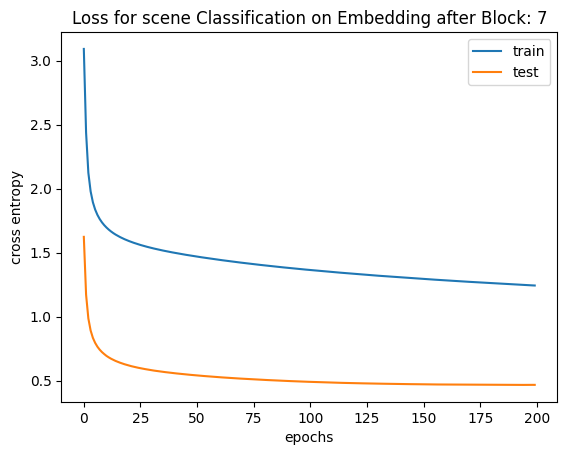

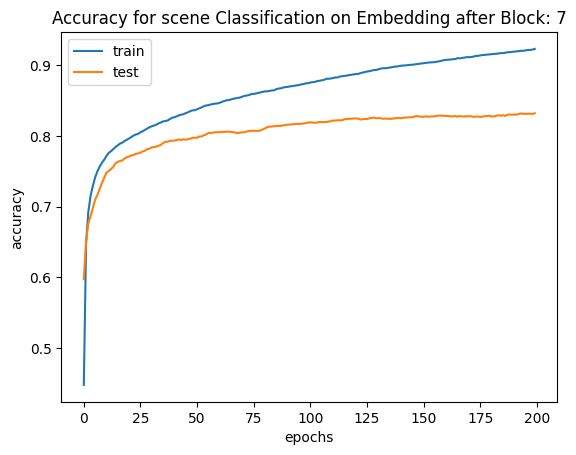

In [213]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [214]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [215]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [216]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [217]:
X_test=train_ready(test_data,col_name)

In [218]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

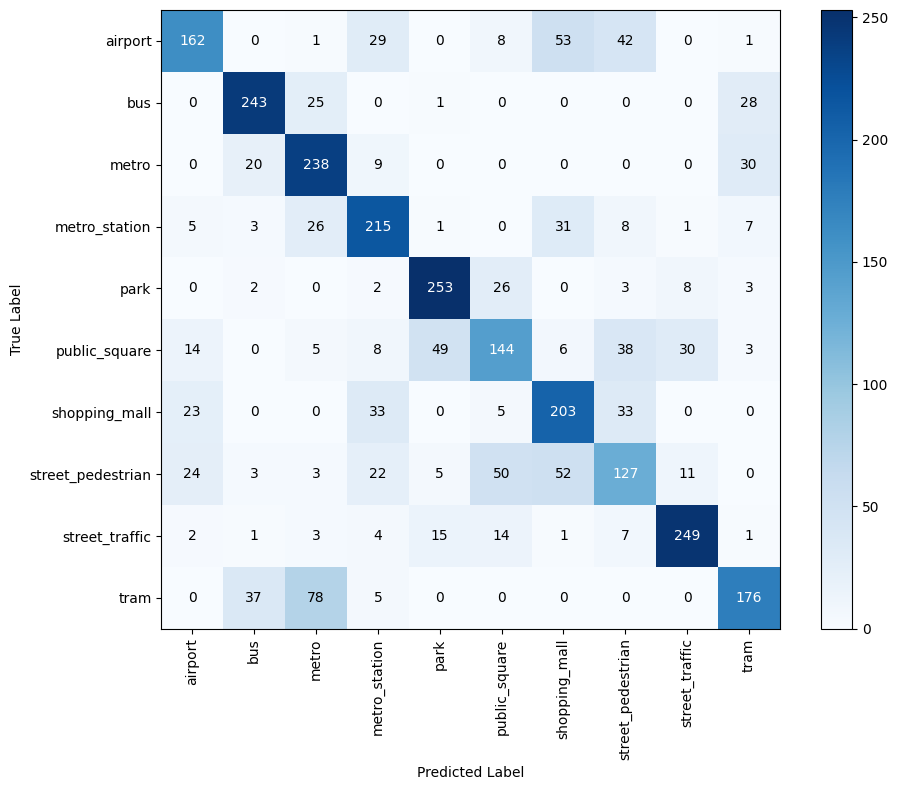

Accuracy: 0.6772


In [219]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-8

In [220]:
Block_number=8

In [221]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [222]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [223]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


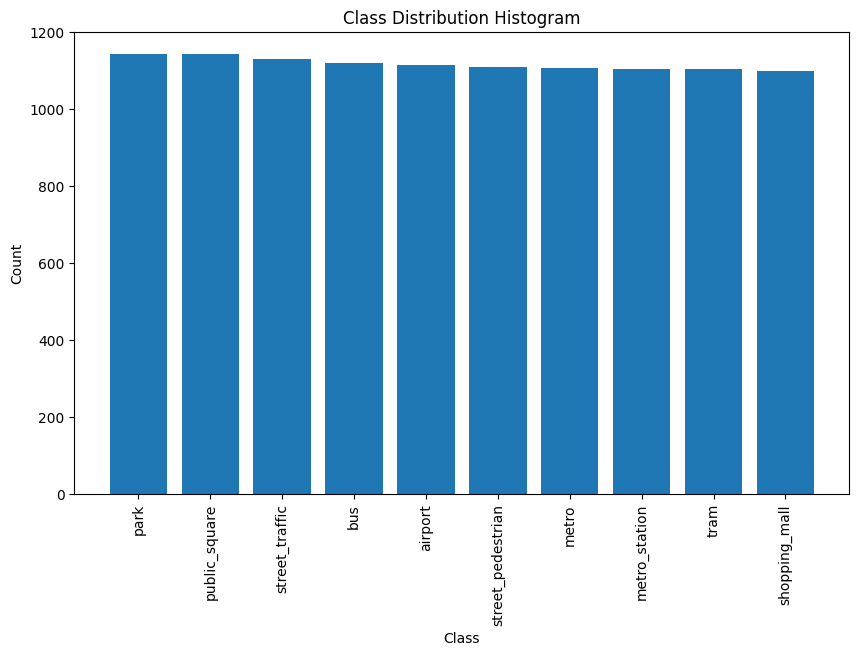

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [224]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


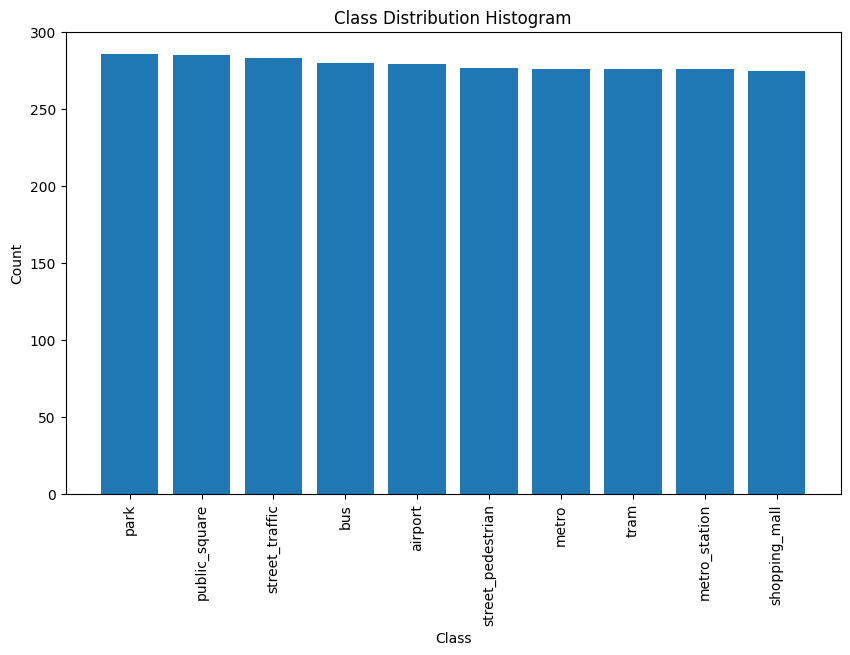

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [225]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [226]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [227]:
X_train_tensor.shape

torch.Size([11169, 768])

In [228]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [229]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 231.58batch/s, acc=0.656, loss=2.6] 


Epoch 0 validation: Cross-entropy=1.46, Accuracy=62.2%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 399.62batch/s, acc=0.734, loss=2.16]


Epoch 1 validation: Cross-entropy=1.03, Accuracy=67.8%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 313.97batch/s, acc=0.766, loss=1.97]


Epoch 2 validation: Cross-entropy=0.87, Accuracy=70.9%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 397.02batch/s, acc=0.781, loss=1.86]


Epoch 3 validation: Cross-entropy=0.79, Accuracy=72.4%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 324.05batch/s, acc=0.781, loss=1.79]


Epoch 4 validation: Cross-entropy=0.73, Accuracy=73.9%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 381.63batch/s, acc=0.797, loss=1.74]


Epoch 5 validation: Cross-entropy=0.69, Accuracy=75.1%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 272.17batch/s, acc=0.812, loss=1.71]


Epoch 6 validation: Cross-entropy=0.66, Accuracy=76.1%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 374.91batch/s, acc=0.812, loss=1.69]


Epoch 7 validation: Cross-entropy=0.64, Accuracy=76.8%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 319.64batch/s, acc=0.812, loss=1.67]


Epoch 8 validation: Cross-entropy=0.62, Accuracy=77.7%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 391.79batch/s, acc=0.812, loss=1.65]


Epoch 9 validation: Cross-entropy=0.61, Accuracy=78.0%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 318.57batch/s, acc=0.812, loss=1.64]


Epoch 10 validation: Cross-entropy=0.60, Accuracy=78.3%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 388.98batch/s, acc=0.781, loss=1.63]


Epoch 11 validation: Cross-entropy=0.59, Accuracy=78.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 324.90batch/s, acc=0.781, loss=1.62]


Epoch 12 validation: Cross-entropy=0.58, Accuracy=78.8%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 275.27batch/s, acc=0.781, loss=1.61]


Epoch 13 validation: Cross-entropy=0.57, Accuracy=79.1%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 397.83batch/s, acc=0.781, loss=1.6] 


Epoch 14 validation: Cross-entropy=0.56, Accuracy=79.5%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 319.54batch/s, acc=0.797, loss=1.59]


Epoch 15 validation: Cross-entropy=0.56, Accuracy=79.7%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 315.82batch/s, acc=0.797, loss=1.59]


Epoch 16 validation: Cross-entropy=0.55, Accuracy=80.0%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 392.71batch/s, acc=0.812, loss=1.58]


Epoch 17 validation: Cross-entropy=0.54, Accuracy=80.0%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 322.02batch/s, acc=0.812, loss=1.58]


Epoch 18 validation: Cross-entropy=0.54, Accuracy=80.2%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 386.61batch/s, acc=0.812, loss=1.57]


Epoch 19 validation: Cross-entropy=0.53, Accuracy=80.5%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 280.78batch/s, acc=0.812, loss=1.57]


Epoch 20 validation: Cross-entropy=0.53, Accuracy=80.7%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 394.07batch/s, acc=0.812, loss=1.56]


Epoch 21 validation: Cross-entropy=0.53, Accuracy=80.6%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 325.78batch/s, acc=0.812, loss=1.56]


Epoch 22 validation: Cross-entropy=0.52, Accuracy=80.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 320.97batch/s, acc=0.812, loss=1.55]


Epoch 23 validation: Cross-entropy=0.52, Accuracy=80.9%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 317.81batch/s, acc=0.812, loss=1.55]


Epoch 24 validation: Cross-entropy=0.52, Accuracy=81.0%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 391.77batch/s, acc=0.812, loss=1.55]


Epoch 25 validation: Cross-entropy=0.51, Accuracy=80.9%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 328.75batch/s, acc=0.828, loss=1.54]


Epoch 26 validation: Cross-entropy=0.51, Accuracy=81.0%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 320.15batch/s, acc=0.828, loss=1.54]


Epoch 27 validation: Cross-entropy=0.51, Accuracy=81.1%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 324.37batch/s, acc=0.828, loss=1.53]


Epoch 28 validation: Cross-entropy=0.50, Accuracy=81.1%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 323.72batch/s, acc=0.828, loss=1.53]


Epoch 29 validation: Cross-entropy=0.50, Accuracy=81.1%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 384.07batch/s, acc=0.828, loss=1.53]


Epoch 30 validation: Cross-entropy=0.50, Accuracy=81.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 321.92batch/s, acc=0.828, loss=1.52]


Epoch 31 validation: Cross-entropy=0.50, Accuracy=81.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 323.24batch/s, acc=0.828, loss=1.52]


Epoch 32 validation: Cross-entropy=0.49, Accuracy=81.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 391.82batch/s, acc=0.828, loss=1.52]


Epoch 33 validation: Cross-entropy=0.49, Accuracy=81.4%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 276.68batch/s, acc=0.828, loss=1.51]


Epoch 34 validation: Cross-entropy=0.49, Accuracy=81.5%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 394.22batch/s, acc=0.828, loss=1.51]


Epoch 35 validation: Cross-entropy=0.49, Accuracy=81.6%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 323.66batch/s, acc=0.828, loss=1.51]


Epoch 36 validation: Cross-entropy=0.49, Accuracy=81.8%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 331.74batch/s, acc=0.828, loss=1.5] 


Epoch 37 validation: Cross-entropy=0.48, Accuracy=81.9%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 388.58batch/s, acc=0.828, loss=1.5] 


Epoch 38 validation: Cross-entropy=0.48, Accuracy=82.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 326.95batch/s, acc=0.828, loss=1.5] 


Epoch 39 validation: Cross-entropy=0.48, Accuracy=82.0%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 390.85batch/s, acc=0.828, loss=1.5] 


Epoch 40 validation: Cross-entropy=0.48, Accuracy=82.1%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 268.89batch/s, acc=0.828, loss=1.49]


Epoch 41 validation: Cross-entropy=0.48, Accuracy=81.9%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 325.49batch/s, acc=0.828, loss=1.49]


Epoch 42 validation: Cross-entropy=0.47, Accuracy=82.0%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 387.45batch/s, acc=0.828, loss=1.49]


Epoch 43 validation: Cross-entropy=0.47, Accuracy=82.0%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 323.43batch/s, acc=0.828, loss=1.49]


Epoch 44 validation: Cross-entropy=0.47, Accuracy=82.2%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 381.02batch/s, acc=0.828, loss=1.48]


Epoch 45 validation: Cross-entropy=0.47, Accuracy=82.3%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 321.84batch/s, acc=0.828, loss=1.48]


Epoch 46 validation: Cross-entropy=0.47, Accuracy=82.3%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 331.01batch/s, acc=0.828, loss=1.48]


Epoch 47 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 310.43batch/s, acc=0.828, loss=1.48]


Epoch 48 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 332.48batch/s, acc=0.828, loss=1.47]


Epoch 49 validation: Cross-entropy=0.46, Accuracy=82.6%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 391.94batch/s, acc=0.828, loss=1.47]


Epoch 50 validation: Cross-entropy=0.46, Accuracy=82.7%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 331.00batch/s, acc=0.828, loss=1.47]


Epoch 51 validation: Cross-entropy=0.46, Accuracy=82.7%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 324.48batch/s, acc=0.828, loss=1.47]


Epoch 52 validation: Cross-entropy=0.46, Accuracy=82.7%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 397.83batch/s, acc=0.828, loss=1.46]


Epoch 53 validation: Cross-entropy=0.46, Accuracy=82.8%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 318.12batch/s, acc=0.844, loss=1.46]


Epoch 54 validation: Cross-entropy=0.46, Accuracy=82.8%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 327.16batch/s, acc=0.844, loss=1.46]


Epoch 55 validation: Cross-entropy=0.46, Accuracy=82.9%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 316.20batch/s, acc=0.844, loss=1.46]


Epoch 56 validation: Cross-entropy=0.46, Accuracy=82.9%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 327.04batch/s, acc=0.844, loss=1.45]


Epoch 57 validation: Cross-entropy=0.45, Accuracy=82.9%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 379.89batch/s, acc=0.844, loss=1.45]


Epoch 58 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 327.07batch/s, acc=0.844, loss=1.45]


Epoch 59 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 361.16batch/s, acc=0.844, loss=1.45]


Epoch 60 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 362.39batch/s, acc=0.844, loss=1.44]


Epoch 61 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 274.34batch/s, acc=0.844, loss=1.44]


Epoch 62 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 390.19batch/s, acc=0.844, loss=1.44]


Epoch 63 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 332.69batch/s, acc=0.844, loss=1.44]


Epoch 64 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 320.87batch/s, acc=0.844, loss=1.43]


Epoch 65 validation: Cross-entropy=0.45, Accuracy=83.2%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 384.27batch/s, acc=0.844, loss=1.43]


Epoch 66 validation: Cross-entropy=0.45, Accuracy=83.2%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 324.00batch/s, acc=0.844, loss=1.43]


Epoch 67 validation: Cross-entropy=0.45, Accuracy=83.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 369.96batch/s, acc=0.859, loss=1.43]


Epoch 68 validation: Cross-entropy=0.44, Accuracy=83.3%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 294.34batch/s, acc=0.859, loss=1.42]


Epoch 69 validation: Cross-entropy=0.44, Accuracy=83.3%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 321.63batch/s, acc=0.859, loss=1.42]


Epoch 70 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 390.06batch/s, acc=0.859, loss=1.42]


Epoch 71 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 321.49batch/s, acc=0.859, loss=1.42]


Epoch 72 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 329.43batch/s, acc=0.859, loss=1.41]


Epoch 73 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 374.45batch/s, acc=0.859, loss=1.41]


Epoch 74 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 319.58batch/s, acc=0.859, loss=1.41]


Epoch 75 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 308.69batch/s, acc=0.859, loss=1.41]


Epoch 76 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 356.57batch/s, acc=0.859, loss=1.4] 


Epoch 77 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 324.15batch/s, acc=0.859, loss=1.4] 


Epoch 78 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 391.61batch/s, acc=0.859, loss=1.4] 


Epoch 79 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 325.97batch/s, acc=0.859, loss=1.4] 


Epoch 80 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 323.88batch/s, acc=0.859, loss=1.4] 


Epoch 81 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 392.37batch/s, acc=0.859, loss=1.39]


Epoch 82 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 272.38batch/s, acc=0.844, loss=1.39]


Epoch 83 validation: Cross-entropy=0.43, Accuracy=83.7%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 333.69batch/s, acc=0.859, loss=1.39]


Epoch 84 validation: Cross-entropy=0.43, Accuracy=83.7%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 372.08batch/s, acc=0.844, loss=1.39]


Epoch 85 validation: Cross-entropy=0.43, Accuracy=83.8%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 326.32batch/s, acc=0.844, loss=1.38]


Epoch 86 validation: Cross-entropy=0.43, Accuracy=83.7%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 386.99batch/s, acc=0.844, loss=1.38]


Epoch 87 validation: Cross-entropy=0.43, Accuracy=83.9%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 319.13batch/s, acc=0.844, loss=1.38]


Epoch 88 validation: Cross-entropy=0.43, Accuracy=83.9%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 327.75batch/s, acc=0.844, loss=1.38]


Epoch 89 validation: Cross-entropy=0.43, Accuracy=84.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 325.19batch/s, acc=0.844, loss=1.37]


Epoch 90 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 324.38batch/s, acc=0.844, loss=1.37]


Epoch 91 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 388.99batch/s, acc=0.844, loss=1.37]


Epoch 92 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 322.57batch/s, acc=0.844, loss=1.37]


Epoch 93 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 313.17batch/s, acc=0.844, loss=1.37]


Epoch 94 validation: Cross-entropy=0.43, Accuracy=84.0%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 385.23batch/s, acc=0.844, loss=1.36]


Epoch 95 validation: Cross-entropy=0.43, Accuracy=84.0%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 318.03batch/s, acc=0.844, loss=1.36]


Epoch 96 validation: Cross-entropy=0.43, Accuracy=84.0%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 269.27batch/s, acc=0.844, loss=1.36]


Epoch 97 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 388.87batch/s, acc=0.844, loss=1.36]


Epoch 98 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 326.90batch/s, acc=0.844, loss=1.36]


Epoch 99 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 347.32batch/s, acc=0.844, loss=1.35]


Epoch 100 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 356.76batch/s, acc=0.844, loss=1.35]


Epoch 101 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 316.78batch/s, acc=0.844, loss=1.35]


Epoch 102 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 385.54batch/s, acc=0.844, loss=1.35]


Epoch 103 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 275.23batch/s, acc=0.844, loss=1.34]


Epoch 104 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 333.30batch/s, acc=0.844, loss=1.34]


Epoch 105 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 363.71batch/s, acc=0.859, loss=1.34]


Epoch 106 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 322.07batch/s, acc=0.859, loss=1.34]


Epoch 107 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 388.50batch/s, acc=0.875, loss=1.33]


Epoch 108 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 314.61batch/s, acc=0.875, loss=1.33]


Epoch 109 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 328.69batch/s, acc=0.875, loss=1.33]


Epoch 110 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 316.90batch/s, acc=0.875, loss=1.33]


Epoch 111 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 312.63batch/s, acc=0.875, loss=1.33]


Epoch 112 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 366.83batch/s, acc=0.875, loss=1.32]


Epoch 113 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 316.90batch/s, acc=0.875, loss=1.32]


Epoch 114 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 309.46batch/s, acc=0.875, loss=1.32]


Epoch 115 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 389.21batch/s, acc=0.875, loss=1.32]


Epoch 116 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 326.77batch/s, acc=0.875, loss=1.32]


Epoch 117 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 276.96batch/s, acc=0.875, loss=1.31]


Epoch 118 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 372.61batch/s, acc=0.875, loss=1.31]


Epoch 119 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 323.59batch/s, acc=0.875, loss=1.31]


Epoch 120 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 392.90batch/s, acc=0.875, loss=1.31]


Epoch 121 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 327.95batch/s, acc=0.875, loss=1.31]


Epoch 122 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 315.61batch/s, acc=0.875, loss=1.3] 


Epoch 123 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 376.33batch/s, acc=0.891, loss=1.3] 


Epoch 124 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 275.45batch/s, acc=0.891, loss=1.3] 


Epoch 125 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 317.78batch/s, acc=0.891, loss=1.3] 


Epoch 126 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 385.53batch/s, acc=0.891, loss=1.3] 


Epoch 127 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 319.74batch/s, acc=0.891, loss=1.29]


Epoch 128 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 383.41batch/s, acc=0.891, loss=1.29]


Epoch 129 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 318.49batch/s, acc=0.891, loss=1.29]


Epoch 130 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 290.69batch/s, acc=0.891, loss=1.29]


Epoch 131 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 303.69batch/s, acc=0.891, loss=1.29]


Epoch 132 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 288.79batch/s, acc=0.891, loss=1.28]


Epoch 133 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 244.76batch/s, acc=0.891, loss=1.28]


Epoch 134 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 290.32batch/s, acc=0.891, loss=1.28]


Epoch 135 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 214.46batch/s, acc=0.891, loss=1.28]


Epoch 136 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 298.16batch/s, acc=0.891, loss=1.28]


Epoch 137 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 307.27batch/s, acc=0.891, loss=1.28]


Epoch 138 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 353.44batch/s, acc=0.891, loss=1.27]


Epoch 139 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 317.85batch/s, acc=0.891, loss=1.27]


Epoch 140 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 381.75batch/s, acc=0.891, loss=1.27]


Epoch 141 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 384.34batch/s, acc=0.891, loss=1.27]


Epoch 142 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 316.10batch/s, acc=0.891, loss=1.27]


Epoch 143 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 374.99batch/s, acc=0.891, loss=1.26]


Epoch 144 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 270.40batch/s, acc=0.891, loss=1.26]


Epoch 145 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 387.71batch/s, acc=0.891, loss=1.26]


Epoch 146 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 308.22batch/s, acc=0.891, loss=1.26]


Epoch 147 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 374.21batch/s, acc=0.891, loss=1.26]


Epoch 148 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 312.99batch/s, acc=0.891, loss=1.26]


Epoch 149 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 377.32batch/s, acc=0.891, loss=1.25]


Epoch 150 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 312.96batch/s, acc=0.891, loss=1.25]


Epoch 151 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 312.34batch/s, acc=0.891, loss=1.25]


Epoch 152 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 386.12batch/s, acc=0.891, loss=1.25]


Epoch 153 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 260.75batch/s, acc=0.891, loss=1.25]


Epoch 154 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 310.47batch/s, acc=0.891, loss=1.25]


Epoch 155 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 380.67batch/s, acc=0.891, loss=1.25]


Epoch 156 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 309.01batch/s, acc=0.891, loss=1.24]


Epoch 157 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 358.32batch/s, acc=0.891, loss=1.24]


Epoch 158 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 341.42batch/s, acc=0.891, loss=1.24]


Epoch 159 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 315.14batch/s, acc=0.891, loss=1.24]


Epoch 160 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 324.54batch/s, acc=0.891, loss=1.24]


Epoch 161 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 332.99batch/s, acc=0.891, loss=1.23]


Epoch 162 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 312.65batch/s, acc=0.891, loss=1.23]


Epoch 163 validation: Cross-entropy=0.43, Accuracy=84.6%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 387.38batch/s, acc=0.891, loss=1.23]


Epoch 164 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 321.86batch/s, acc=0.891, loss=1.23]


Epoch 165 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 387.84batch/s, acc=0.891, loss=1.23]


Epoch 166 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 328.92batch/s, acc=0.891, loss=1.23]


Epoch 167 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 261.67batch/s, acc=0.891, loss=1.22]


Epoch 168 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 388.82batch/s, acc=0.891, loss=1.22]


Epoch 169 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 316.14batch/s, acc=0.891, loss=1.22]


Epoch 170 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 297.58batch/s, acc=0.891, loss=1.22]


Epoch 171 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 381.45batch/s, acc=0.891, loss=1.22]


Epoch 172 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 329.16batch/s, acc=0.891, loss=1.22]


Epoch 173 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 335.03batch/s, acc=0.906, loss=1.21]


Epoch 174 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 311.69batch/s, acc=0.906, loss=1.21]


Epoch 175 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 324.54batch/s, acc=0.906, loss=1.21]


Epoch 176 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 392.47batch/s, acc=0.906, loss=1.21]


Epoch 177 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 317.17batch/s, acc=0.906, loss=1.21]


Epoch 178 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 314.73batch/s, acc=0.906, loss=1.21]


Epoch 179 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 375.96batch/s, acc=0.906, loss=1.2] 


Epoch 180 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 320.62batch/s, acc=0.906, loss=1.2] 


Epoch 181 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 304.64batch/s, acc=0.906, loss=1.2] 


Epoch 182 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 349.06batch/s, acc=0.906, loss=1.2] 


Epoch 183 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 318.29batch/s, acc=0.906, loss=1.2] 


Epoch 184 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 381.82batch/s, acc=0.906, loss=1.2] 


Epoch 185 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 316.18batch/s, acc=0.906, loss=1.19]


Epoch 186 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 322.27batch/s, acc=0.906, loss=1.19]


Epoch 187 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 378.53batch/s, acc=0.906, loss=1.19]


Epoch 188 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 267.96batch/s, acc=0.906, loss=1.19]


Epoch 189 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 394.99batch/s, acc=0.906, loss=1.19]


Epoch 190 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 314.92batch/s, acc=0.906, loss=1.19]


Epoch 191 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 315.49batch/s, acc=0.906, loss=1.18]


Epoch 192 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 388.17batch/s, acc=0.906, loss=1.18]


Epoch 193 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 326.48batch/s, acc=0.922, loss=1.18]


Epoch 194 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 342.51batch/s, acc=0.906, loss=1.18]


Epoch 195 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 299.69batch/s, acc=0.922, loss=1.18]


Epoch 196 validation: Cross-entropy=0.44, Accuracy=84.6%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 320.15batch/s, acc=0.906, loss=1.18]


Epoch 197 validation: Cross-entropy=0.44, Accuracy=84.7%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 380.69batch/s, acc=0.922, loss=1.18]


Epoch 198 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 332.36batch/s, acc=0.922, loss=1.17]


Epoch 199 validation: Cross-entropy=0.45, Accuracy=84.6%


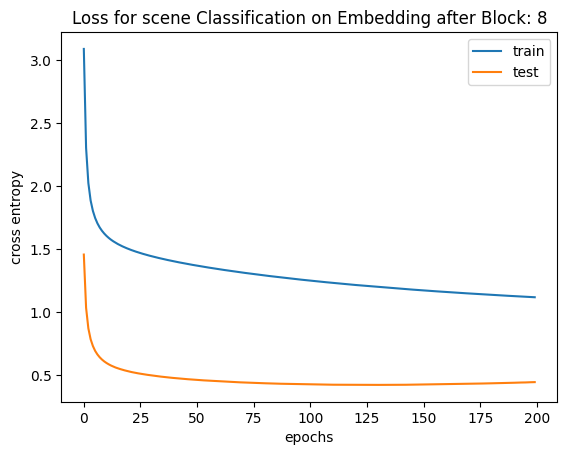

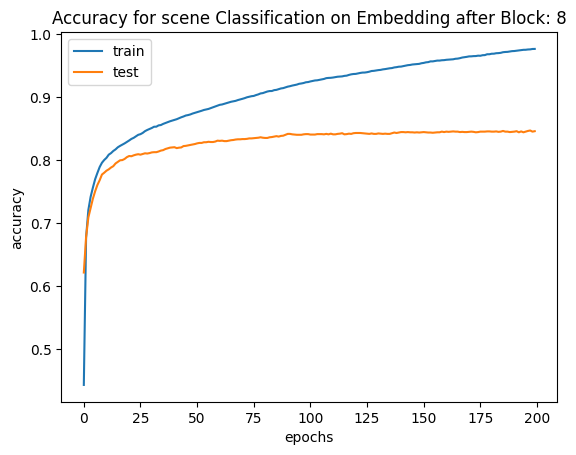

In [230]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [231]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [232]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [233]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [234]:
X_test=train_ready(test_data,col_name)

In [235]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

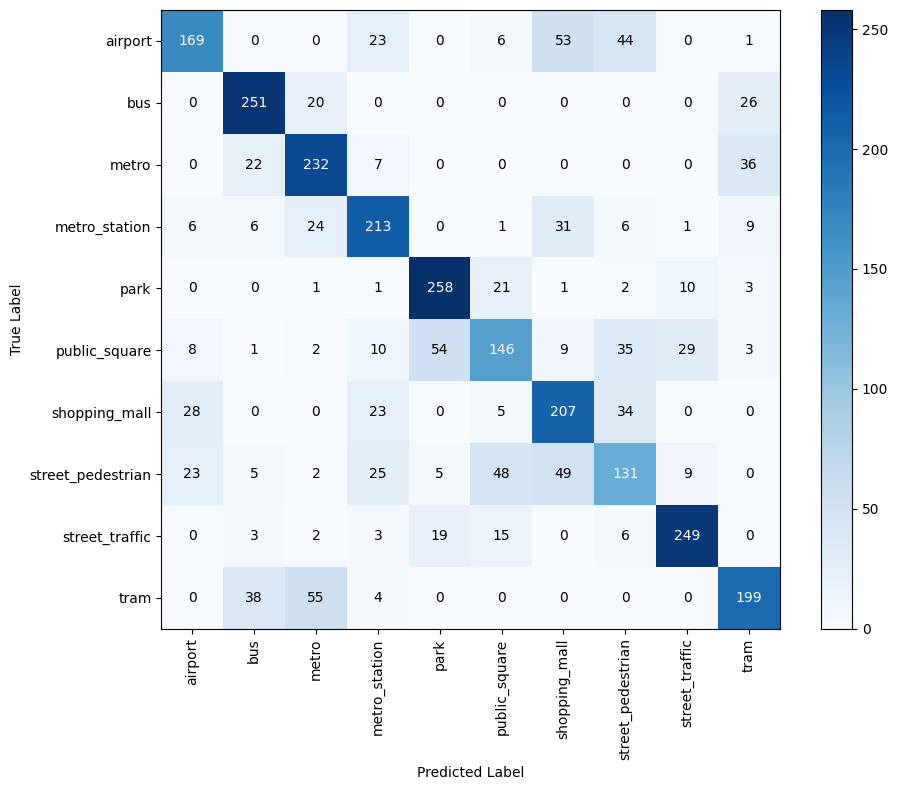

Accuracy: 0.6924


In [236]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-9

In [237]:
Block_number=9

In [238]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [239]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [240]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


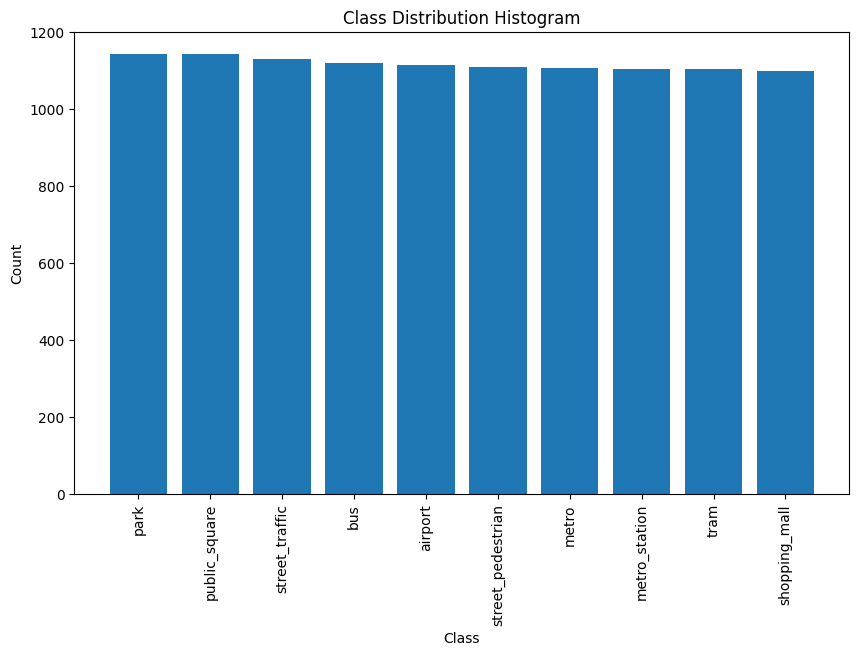

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [241]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


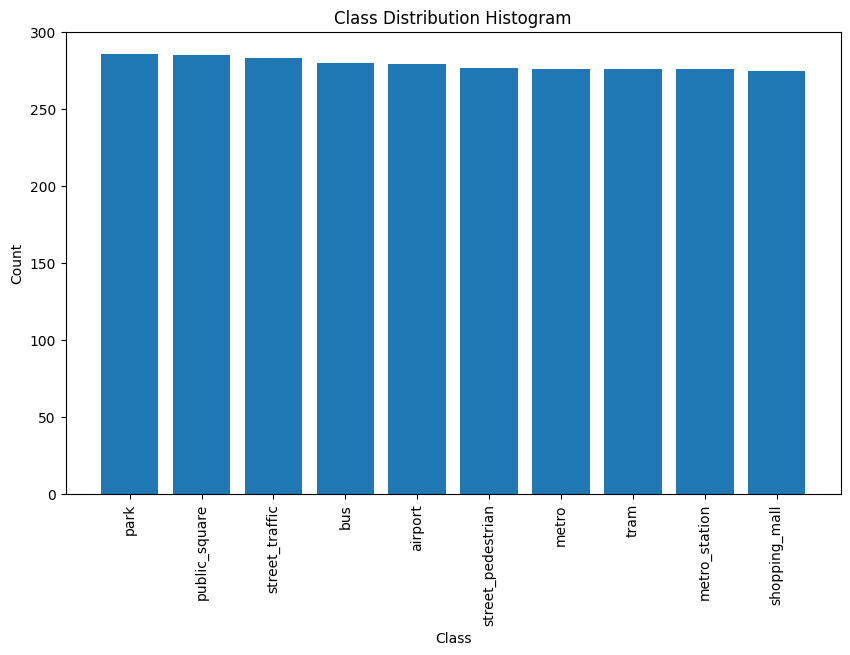

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [242]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [243]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [244]:
X_train_tensor.shape

torch.Size([11169, 768])

In [245]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [246]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 337.50batch/s, acc=0.625, loss=2.71]


Epoch 0 validation: Cross-entropy=1.50, Accuracy=63.8%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 285.52batch/s, acc=0.766, loss=2.18]


Epoch 1 validation: Cross-entropy=0.97, Accuracy=70.6%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 278.58batch/s, acc=0.812, loss=1.97]


Epoch 2 validation: Cross-entropy=0.80, Accuracy=73.2%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 290.39batch/s, acc=0.797, loss=1.86]


Epoch 3 validation: Cross-entropy=0.72, Accuracy=74.4%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 280.30batch/s, acc=0.797, loss=1.79]


Epoch 4 validation: Cross-entropy=0.67, Accuracy=76.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 223.00batch/s, acc=0.812, loss=1.75]


Epoch 5 validation: Cross-entropy=0.64, Accuracy=77.2%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 332.93batch/s, acc=0.812, loss=1.72]


Epoch 6 validation: Cross-entropy=0.61, Accuracy=77.8%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 314.28batch/s, acc=0.812, loss=1.7] 


Epoch 7 validation: Cross-entropy=0.59, Accuracy=78.6%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 378.81batch/s, acc=0.828, loss=1.68]


Epoch 8 validation: Cross-entropy=0.58, Accuracy=78.9%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 309.15batch/s, acc=0.828, loss=1.66]


Epoch 9 validation: Cross-entropy=0.56, Accuracy=79.3%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 375.29batch/s, acc=0.828, loss=1.65]


Epoch 10 validation: Cross-entropy=0.55, Accuracy=79.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 329.35batch/s, acc=0.828, loss=1.63]


Epoch 11 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 295.48batch/s, acc=0.828, loss=1.62]


Epoch 12 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 376.22batch/s, acc=0.828, loss=1.61]


Epoch 13 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 311.95batch/s, acc=0.828, loss=1.61]


Epoch 14 validation: Cross-entropy=0.52, Accuracy=80.3%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 304.16batch/s, acc=0.828, loss=1.6] 


Epoch 15 validation: Cross-entropy=0.51, Accuracy=80.6%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 377.99batch/s, acc=0.812, loss=1.59]


Epoch 16 validation: Cross-entropy=0.51, Accuracy=80.6%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 315.28batch/s, acc=0.812, loss=1.58]


Epoch 17 validation: Cross-entropy=0.50, Accuracy=80.7%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 311.69batch/s, acc=0.812, loss=1.58]


Epoch 18 validation: Cross-entropy=0.50, Accuracy=81.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 312.70batch/s, acc=0.812, loss=1.57]


Epoch 19 validation: Cross-entropy=0.49, Accuracy=81.1%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 309.48batch/s, acc=0.812, loss=1.56]


Epoch 20 validation: Cross-entropy=0.49, Accuracy=81.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 317.66batch/s, acc=0.812, loss=1.56]


Epoch 21 validation: Cross-entropy=0.49, Accuracy=81.3%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 383.56batch/s, acc=0.812, loss=1.55]


Epoch 22 validation: Cross-entropy=0.48, Accuracy=81.4%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 315.16batch/s, acc=0.812, loss=1.55]


Epoch 23 validation: Cross-entropy=0.48, Accuracy=81.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 313.57batch/s, acc=0.812, loss=1.55]


Epoch 24 validation: Cross-entropy=0.48, Accuracy=81.6%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 379.67batch/s, acc=0.812, loss=1.54]


Epoch 25 validation: Cross-entropy=0.47, Accuracy=81.7%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 277.09batch/s, acc=0.812, loss=1.54]


Epoch 26 validation: Cross-entropy=0.47, Accuracy=81.8%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 331.40batch/s, acc=0.828, loss=1.53]


Epoch 27 validation: Cross-entropy=0.47, Accuracy=81.9%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 381.96batch/s, acc=0.828, loss=1.53]


Epoch 28 validation: Cross-entropy=0.46, Accuracy=82.0%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 319.64batch/s, acc=0.828, loss=1.52]


Epoch 29 validation: Cross-entropy=0.46, Accuracy=82.0%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 386.16batch/s, acc=0.828, loss=1.52]


Epoch 30 validation: Cross-entropy=0.46, Accuracy=82.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 320.87batch/s, acc=0.828, loss=1.51]


Epoch 31 validation: Cross-entropy=0.46, Accuracy=82.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 328.80batch/s, acc=0.828, loss=1.51]


Epoch 32 validation: Cross-entropy=0.46, Accuracy=82.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 313.99batch/s, acc=0.828, loss=1.5] 


Epoch 33 validation: Cross-entropy=0.45, Accuracy=82.6%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 323.23batch/s, acc=0.828, loss=1.5] 


Epoch 34 validation: Cross-entropy=0.45, Accuracy=82.6%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 353.84batch/s, acc=0.828, loss=1.5] 


Epoch 35 validation: Cross-entropy=0.45, Accuracy=82.6%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 347.16batch/s, acc=0.828, loss=1.49]


Epoch 36 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 297.37batch/s, acc=0.828, loss=1.49]


Epoch 37 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 388.56batch/s, acc=0.828, loss=1.48]


Epoch 38 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 311.06batch/s, acc=0.828, loss=1.48]


Epoch 39 validation: Cross-entropy=0.44, Accuracy=83.1%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 269.01batch/s, acc=0.828, loss=1.48]


Epoch 40 validation: Cross-entropy=0.44, Accuracy=83.2%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 382.42batch/s, acc=0.828, loss=1.47]


Epoch 41 validation: Cross-entropy=0.44, Accuracy=83.3%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 319.02batch/s, acc=0.828, loss=1.47]


Epoch 42 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 312.96batch/s, acc=0.828, loss=1.47]


Epoch 43 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 393.78batch/s, acc=0.828, loss=1.46]


Epoch 44 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 316.01batch/s, acc=0.828, loss=1.46]


Epoch 45 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 327.09batch/s, acc=0.828, loss=1.45]


Epoch 46 validation: Cross-entropy=0.43, Accuracy=83.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 311.45batch/s, acc=0.828, loss=1.45]


Epoch 47 validation: Cross-entropy=0.43, Accuracy=83.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 335.47batch/s, acc=0.828, loss=1.45]


Epoch 48 validation: Cross-entropy=0.43, Accuracy=83.9%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 377.42batch/s, acc=0.828, loss=1.45]


Epoch 49 validation: Cross-entropy=0.43, Accuracy=84.0%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 322.50batch/s, acc=0.828, loss=1.44]


Epoch 50 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 379.60batch/s, acc=0.828, loss=1.44]


Epoch 51 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 315.37batch/s, acc=0.828, loss=1.44]


Epoch 52 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 310.26batch/s, acc=0.828, loss=1.43]


Epoch 53 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 314.79batch/s, acc=0.828, loss=1.43]


Epoch 54 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 305.23batch/s, acc=0.828, loss=1.43]


Epoch 55 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 319.20batch/s, acc=0.828, loss=1.42]


Epoch 56 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 383.92batch/s, acc=0.828, loss=1.42]


Epoch 57 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 319.93batch/s, acc=0.828, loss=1.42]


Epoch 58 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 313.51batch/s, acc=0.844, loss=1.41]


Epoch 59 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 401.12batch/s, acc=0.844, loss=1.41]


Epoch 60 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 264.73batch/s, acc=0.844, loss=1.41]


Epoch 61 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 388.59batch/s, acc=0.844, loss=1.41]


Epoch 62 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 319.82batch/s, acc=0.844, loss=1.4] 


Epoch 63 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 354.52batch/s, acc=0.844, loss=1.4] 


Epoch 64 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 352.39batch/s, acc=0.844, loss=1.4] 


Epoch 65 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 317.21batch/s, acc=0.844, loss=1.39]


Epoch 66 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 377.63batch/s, acc=0.844, loss=1.39]


Epoch 67 validation: Cross-entropy=0.42, Accuracy=84.2%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 272.21batch/s, acc=0.844, loss=1.39]


Epoch 68 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 319.04batch/s, acc=0.844, loss=1.39]


Epoch 69 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 390.48batch/s, acc=0.844, loss=1.38]


Epoch 70 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 319.16batch/s, acc=0.859, loss=1.38]


Epoch 71 validation: Cross-entropy=0.42, Accuracy=84.6%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 309.41batch/s, acc=0.859, loss=1.38]


Epoch 72 validation: Cross-entropy=0.41, Accuracy=84.5%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 381.85batch/s, acc=0.875, loss=1.37]


Epoch 73 validation: Cross-entropy=0.41, Accuracy=84.6%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 318.61batch/s, acc=0.875, loss=1.37]


Epoch 74 validation: Cross-entropy=0.41, Accuracy=84.7%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 301.67batch/s, acc=0.875, loss=1.37]


Epoch 75 validation: Cross-entropy=0.41, Accuracy=84.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 346.96batch/s, acc=0.875, loss=1.37]


Epoch 76 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 313.14batch/s, acc=0.875, loss=1.36]


Epoch 77 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 391.37batch/s, acc=0.875, loss=1.36]


Epoch 78 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 319.28batch/s, acc=0.875, loss=1.36]


Epoch 79 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 333.62batch/s, acc=0.875, loss=1.35]


Epoch 80 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 392.20batch/s, acc=0.875, loss=1.35]


Epoch 81 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 271.79batch/s, acc=0.875, loss=1.35]


Epoch 82 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 384.41batch/s, acc=0.875, loss=1.34]


Epoch 83 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 339.52batch/s, acc=0.875, loss=1.34]


Epoch 84 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 317.44batch/s, acc=0.875, loss=1.34]


Epoch 85 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 389.90batch/s, acc=0.875, loss=1.34]


Epoch 86 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 318.17batch/s, acc=0.875, loss=1.33]


Epoch 87 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 395.91batch/s, acc=0.875, loss=1.33]


Epoch 88 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 277.62batch/s, acc=0.875, loss=1.33]


Epoch 89 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 324.21batch/s, acc=0.875, loss=1.33]


Epoch 90 validation: Cross-entropy=0.41, Accuracy=84.8%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 328.93batch/s, acc=0.891, loss=1.32]


Epoch 91 validation: Cross-entropy=0.41, Accuracy=84.8%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 370.33batch/s, acc=0.891, loss=1.32]


Epoch 92 validation: Cross-entropy=0.41, Accuracy=84.8%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 317.50batch/s, acc=0.891, loss=1.32]


Epoch 93 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 376.64batch/s, acc=0.891, loss=1.31]


Epoch 94 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 318.38batch/s, acc=0.891, loss=1.31]


Epoch 95 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 312.41batch/s, acc=0.891, loss=1.31]


Epoch 96 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 312.00batch/s, acc=0.891, loss=1.31]


Epoch 97 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 325.99batch/s, acc=0.891, loss=1.3] 


Epoch 98 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 394.39batch/s, acc=0.891, loss=1.3] 


Epoch 99 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 326.03batch/s, acc=0.891, loss=1.3] 


Epoch 100 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 319.34batch/s, acc=0.891, loss=1.3] 


Epoch 101 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 386.58batch/s, acc=0.891, loss=1.29]


Epoch 102 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 268.66batch/s, acc=0.891, loss=1.29]


Epoch 103 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 384.39batch/s, acc=0.891, loss=1.29]


Epoch 104 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 315.77batch/s, acc=0.891, loss=1.28]


Epoch 105 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 324.49batch/s, acc=0.891, loss=1.28]


Epoch 106 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 367.69batch/s, acc=0.891, loss=1.28]


Epoch 107 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 323.37batch/s, acc=0.891, loss=1.28]


Epoch 108 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 390.98batch/s, acc=0.891, loss=1.27]


Epoch 109 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 275.08batch/s, acc=0.891, loss=1.27]


Epoch 110 validation: Cross-entropy=0.41, Accuracy=85.1%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 312.39batch/s, acc=0.891, loss=1.27]


Epoch 111 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 389.23batch/s, acc=0.891, loss=1.26]


Epoch 112 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 317.65batch/s, acc=0.891, loss=1.26]


Epoch 113 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 339.26batch/s, acc=0.891, loss=1.26]


Epoch 114 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 360.91batch/s, acc=0.891, loss=1.26]


Epoch 115 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 321.76batch/s, acc=0.906, loss=1.25]


Epoch 116 validation: Cross-entropy=0.41, Accuracy=85.3%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 315.98batch/s, acc=0.906, loss=1.25]


Epoch 117 validation: Cross-entropy=0.41, Accuracy=85.3%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 310.38batch/s, acc=0.906, loss=1.25]


Epoch 118 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 320.95batch/s, acc=0.906, loss=1.25]


Epoch 119 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 391.48batch/s, acc=0.906, loss=1.24]


Epoch 120 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 317.27batch/s, acc=0.906, loss=1.24]


Epoch 121 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 335.99batch/s, acc=0.906, loss=1.24]


Epoch 122 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 372.79batch/s, acc=0.906, loss=1.23]


Epoch 123 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 270.34batch/s, acc=0.906, loss=1.23]


Epoch 124 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 384.37batch/s, acc=0.906, loss=1.23]


Epoch 125 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 316.14batch/s, acc=0.906, loss=1.22]


Epoch 126 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 318.76batch/s, acc=0.906, loss=1.22]


Epoch 127 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 384.44batch/s, acc=0.906, loss=1.22]


Epoch 128 validation: Cross-entropy=0.41, Accuracy=85.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 320.40batch/s, acc=0.906, loss=1.22]


Epoch 129 validation: Cross-entropy=0.41, Accuracy=85.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 318.95batch/s, acc=0.906, loss=1.21]


Epoch 130 validation: Cross-entropy=0.41, Accuracy=85.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 326.59batch/s, acc=0.906, loss=1.21]


Epoch 131 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 312.94batch/s, acc=0.922, loss=1.21]


Epoch 132 validation: Cross-entropy=0.41, Accuracy=85.3%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 321.87batch/s, acc=0.922, loss=1.21]


Epoch 133 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 377.18batch/s, acc=0.922, loss=1.2] 


Epoch 134 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 321.95batch/s, acc=0.922, loss=1.2] 


Epoch 135 validation: Cross-entropy=0.41, Accuracy=85.2%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 378.41batch/s, acc=0.922, loss=1.2] 


Epoch 136 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 324.35batch/s, acc=0.922, loss=1.19]


Epoch 137 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 271.27batch/s, acc=0.922, loss=1.19]


Epoch 138 validation: Cross-entropy=0.41, Accuracy=85.4%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 367.73batch/s, acc=0.938, loss=1.19]


Epoch 139 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 319.70batch/s, acc=0.938, loss=1.19]


Epoch 140 validation: Cross-entropy=0.42, Accuracy=85.4%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 382.52batch/s, acc=0.938, loss=1.18]


Epoch 141 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 319.67batch/s, acc=0.953, loss=1.18]


Epoch 142 validation: Cross-entropy=0.42, Accuracy=85.4%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 332.80batch/s, acc=0.953, loss=1.18]


Epoch 143 validation: Cross-entropy=0.42, Accuracy=85.4%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 394.76batch/s, acc=0.953, loss=1.18]


Epoch 144 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 280.84batch/s, acc=0.953, loss=1.17]


Epoch 145 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 305.79batch/s, acc=0.953, loss=1.17]


Epoch 146 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 390.08batch/s, acc=0.953, loss=1.17]


Epoch 147 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 313.59batch/s, acc=0.953, loss=1.17]


Epoch 148 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 313.96batch/s, acc=0.953, loss=1.16]


Epoch 149 validation: Cross-entropy=0.42, Accuracy=85.4%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 373.48batch/s, acc=0.953, loss=1.16]


Epoch 150 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 310.01batch/s, acc=0.953, loss=1.16]


Epoch 151 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 331.97batch/s, acc=0.953, loss=1.16]


Epoch 152 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 298.55batch/s, acc=0.953, loss=1.15]


Epoch 153 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 320.40batch/s, acc=0.953, loss=1.15]


Epoch 154 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 379.76batch/s, acc=0.953, loss=1.15]


Epoch 155 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 310.96batch/s, acc=0.953, loss=1.15]


Epoch 156 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 330.26batch/s, acc=0.953, loss=1.14]


Epoch 157 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 368.41batch/s, acc=0.953, loss=1.14]


Epoch 158 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 303.52batch/s, acc=0.953, loss=1.14]


Epoch 159 validation: Cross-entropy=0.42, Accuracy=85.5%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 285.98batch/s, acc=0.953, loss=1.14]


Epoch 160 validation: Cross-entropy=0.42, Accuracy=85.6%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 380.68batch/s, acc=0.969, loss=1.14]


Epoch 161 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 316.95batch/s, acc=0.969, loss=1.13]


Epoch 162 validation: Cross-entropy=0.43, Accuracy=85.7%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 380.03batch/s, acc=0.969, loss=1.13]


Epoch 163 validation: Cross-entropy=0.43, Accuracy=85.6%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 323.09batch/s, acc=0.969, loss=1.13]


Epoch 164 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 316.48batch/s, acc=0.969, loss=1.13]


Epoch 165 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 386.10batch/s, acc=0.984, loss=1.13]


Epoch 166 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 270.54batch/s, acc=0.984, loss=1.12]


Epoch 167 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 390.46batch/s, acc=0.984, loss=1.12]


Epoch 168 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 318.36batch/s, acc=0.984, loss=1.12]


Epoch 169 validation: Cross-entropy=0.43, Accuracy=85.4%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 315.21batch/s, acc=0.984, loss=1.12]


Epoch 170 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 373.40batch/s, acc=0.984, loss=1.12]


Epoch 171 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 312.52batch/s, acc=0.984, loss=1.12]


Epoch 172 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 314.84batch/s, acc=0.984, loss=1.11]


Epoch 173 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 316.21batch/s, acc=0.984, loss=1.11]


Epoch 174 validation: Cross-entropy=0.43, Accuracy=85.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 315.28batch/s, acc=0.984, loss=1.11]


Epoch 175 validation: Cross-entropy=0.43, Accuracy=85.6%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 375.93batch/s, acc=0.984, loss=1.11]


Epoch 176 validation: Cross-entropy=0.43, Accuracy=85.6%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 314.70batch/s, acc=0.984, loss=1.11]


Epoch 177 validation: Cross-entropy=0.44, Accuracy=85.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 321.19batch/s, acc=0.984, loss=1.11]


Epoch 178 validation: Cross-entropy=0.44, Accuracy=85.5%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 379.20batch/s, acc=0.984, loss=1.11]


Epoch 179 validation: Cross-entropy=0.44, Accuracy=85.5%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 309.43batch/s, acc=0.984, loss=1.1] 


Epoch 180 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 267.28batch/s, acc=0.984, loss=1.1] 


Epoch 181 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 392.33batch/s, acc=0.984, loss=1.1] 


Epoch 182 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 324.33batch/s, acc=0.984, loss=1.1] 


Epoch 183 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 390.47batch/s, acc=0.984, loss=1.1] 


Epoch 184 validation: Cross-entropy=0.44, Accuracy=85.7%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 319.07batch/s, acc=0.984, loss=1.1] 


Epoch 185 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 314.64batch/s, acc=0.984, loss=1.09]


Epoch 186 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 393.23batch/s, acc=0.984, loss=1.09]


Epoch 187 validation: Cross-entropy=0.44, Accuracy=85.7%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 270.10batch/s, acc=0.984, loss=1.09]


Epoch 188 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 321.75batch/s, acc=0.984, loss=1.09]


Epoch 189 validation: Cross-entropy=0.44, Accuracy=85.7%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 389.33batch/s, acc=0.984, loss=1.09]


Epoch 190 validation: Cross-entropy=0.45, Accuracy=85.8%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 317.36batch/s, acc=0.984, loss=1.09]


Epoch 191 validation: Cross-entropy=0.45, Accuracy=85.7%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 324.72batch/s, acc=0.984, loss=1.09]


Epoch 192 validation: Cross-entropy=0.45, Accuracy=85.7%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 394.41batch/s, acc=1, loss=1.09]    


Epoch 193 validation: Cross-entropy=0.45, Accuracy=85.8%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 323.31batch/s, acc=1, loss=1.09]    


Epoch 194 validation: Cross-entropy=0.45, Accuracy=85.7%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 269.43batch/s, acc=1, loss=1.08]    


Epoch 195 validation: Cross-entropy=0.45, Accuracy=85.7%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 383.76batch/s, acc=1, loss=1.08]    


Epoch 196 validation: Cross-entropy=0.45, Accuracy=85.7%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 315.45batch/s, acc=1, loss=1.08]    


Epoch 197 validation: Cross-entropy=0.45, Accuracy=85.7%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 381.90batch/s, acc=1, loss=1.08]    


Epoch 198 validation: Cross-entropy=0.45, Accuracy=85.8%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 320.29batch/s, acc=1, loss=1.08]    


Epoch 199 validation: Cross-entropy=0.45, Accuracy=85.8%


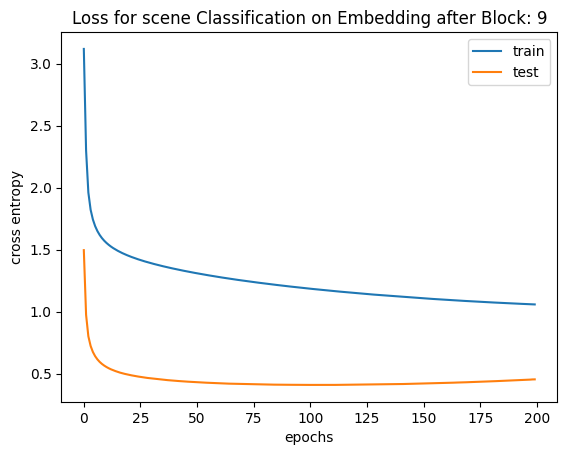

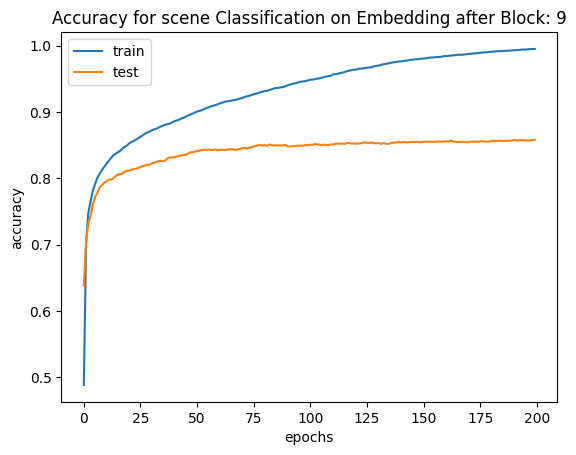

In [247]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [248]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [249]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [250]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [251]:
X_test=train_ready(test_data,col_name)

In [252]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

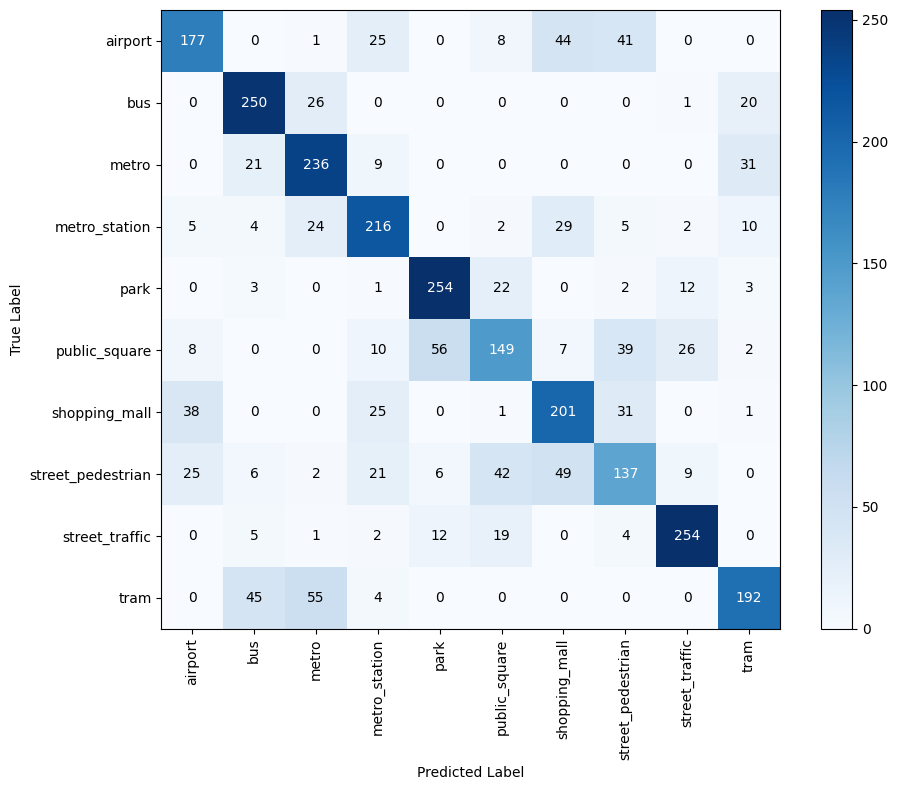

Accuracy: 0.6961


In [253]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-10

In [254]:
Block_number=10

In [255]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [256]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [257]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


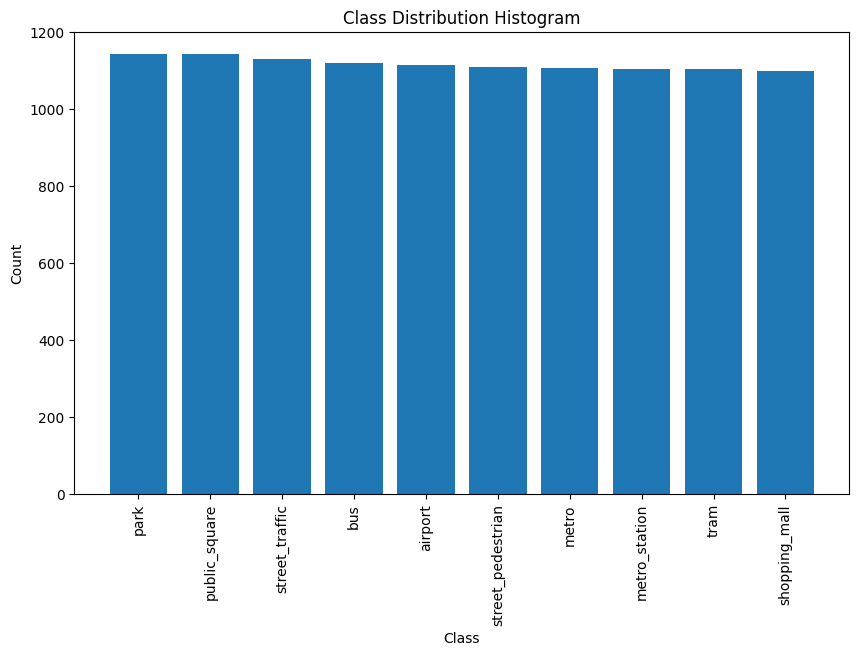

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [258]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


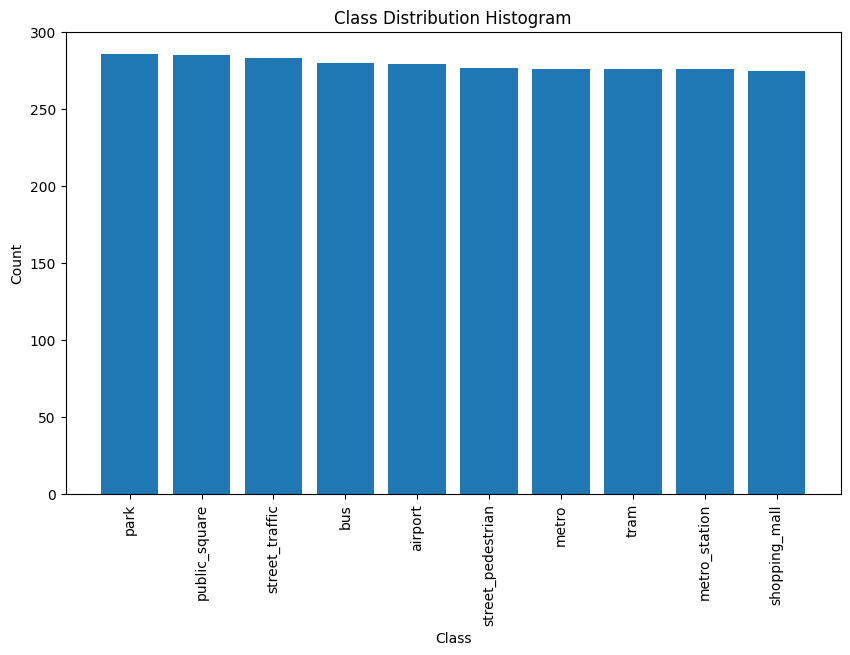

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [259]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [260]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [261]:
X_train_tensor.shape

torch.Size([11169, 768])

In [262]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [263]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 181.92batch/s, acc=0.766, loss=2.57]


Epoch 0 validation: Cross-entropy=1.31, Accuracy=70.4%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 219.74batch/s, acc=0.75, loss=2.1]  


Epoch 1 validation: Cross-entropy=0.86, Accuracy=74.2%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 319.56batch/s, acc=0.797, loss=1.93]


Epoch 2 validation: Cross-entropy=0.72, Accuracy=76.5%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 268.05batch/s, acc=0.812, loss=1.84]


Epoch 3 validation: Cross-entropy=0.65, Accuracy=77.9%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 279.92batch/s, acc=0.828, loss=1.78]


Epoch 4 validation: Cross-entropy=0.61, Accuracy=78.8%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 289.52batch/s, acc=0.828, loss=1.75]


Epoch 5 validation: Cross-entropy=0.57, Accuracy=79.4%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 343.47batch/s, acc=0.844, loss=1.72]


Epoch 6 validation: Cross-entropy=0.55, Accuracy=80.1%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 369.65batch/s, acc=0.844, loss=1.7] 


Epoch 7 validation: Cross-entropy=0.53, Accuracy=80.7%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 289.88batch/s, acc=0.828, loss=1.68]


Epoch 8 validation: Cross-entropy=0.52, Accuracy=81.3%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 353.63batch/s, acc=0.828, loss=1.67]


Epoch 9 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 216.22batch/s, acc=0.828, loss=1.66]


Epoch 10 validation: Cross-entropy=0.49, Accuracy=81.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 310.08batch/s, acc=0.828, loss=1.65]


Epoch 11 validation: Cross-entropy=0.48, Accuracy=81.7%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 262.14batch/s, acc=0.828, loss=1.64]


Epoch 12 validation: Cross-entropy=0.48, Accuracy=81.8%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 292.95batch/s, acc=0.828, loss=1.64]


Epoch 13 validation: Cross-entropy=0.47, Accuracy=82.2%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 278.60batch/s, acc=0.828, loss=1.63]


Epoch 14 validation: Cross-entropy=0.46, Accuracy=82.7%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 273.26batch/s, acc=0.828, loss=1.63]


Epoch 15 validation: Cross-entropy=0.46, Accuracy=83.0%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 267.22batch/s, acc=0.828, loss=1.62]


Epoch 16 validation: Cross-entropy=0.45, Accuracy=82.9%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 310.02batch/s, acc=0.828, loss=1.62]


Epoch 17 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 277.71batch/s, acc=0.828, loss=1.61]


Epoch 18 validation: Cross-entropy=0.45, Accuracy=83.2%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 326.03batch/s, acc=0.828, loss=1.61]


Epoch 19 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 275.92batch/s, acc=0.828, loss=1.6] 


Epoch 20 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 339.96batch/s, acc=0.828, loss=1.6] 


Epoch 21 validation: Cross-entropy=0.43, Accuracy=83.6%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 235.15batch/s, acc=0.828, loss=1.59]


Epoch 22 validation: Cross-entropy=0.43, Accuracy=83.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 331.63batch/s, acc=0.828, loss=1.59]


Epoch 23 validation: Cross-entropy=0.43, Accuracy=83.9%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 280.82batch/s, acc=0.828, loss=1.59]


Epoch 24 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 336.87batch/s, acc=0.828, loss=1.58]


Epoch 25 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 275.74batch/s, acc=0.828, loss=1.58]


Epoch 26 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 312.17batch/s, acc=0.828, loss=1.58]


Epoch 27 validation: Cross-entropy=0.42, Accuracy=84.4%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 234.87batch/s, acc=0.828, loss=1.58]


Epoch 28 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 336.79batch/s, acc=0.828, loss=1.58]


Epoch 29 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 284.31batch/s, acc=0.828, loss=1.58]


Epoch 30 validation: Cross-entropy=0.41, Accuracy=84.5%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 346.32batch/s, acc=0.828, loss=1.57]


Epoch 31 validation: Cross-entropy=0.41, Accuracy=84.6%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 268.24batch/s, acc=0.844, loss=1.57]


Epoch 32 validation: Cross-entropy=0.41, Accuracy=84.4%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 325.23batch/s, acc=0.844, loss=1.57]


Epoch 33 validation: Cross-entropy=0.41, Accuracy=84.6%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 246.93batch/s, acc=0.844, loss=1.57]


Epoch 34 validation: Cross-entropy=0.41, Accuracy=84.7%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 337.60batch/s, acc=0.844, loss=1.57]


Epoch 35 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 293.96batch/s, acc=0.844, loss=1.58]


Epoch 36 validation: Cross-entropy=0.40, Accuracy=85.0%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 330.58batch/s, acc=0.844, loss=1.58]


Epoch 37 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 350.84batch/s, acc=0.844, loss=1.58]


Epoch 38 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 280.84batch/s, acc=0.844, loss=1.59]


Epoch 39 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 289.67batch/s, acc=0.844, loss=1.6] 


Epoch 40 validation: Cross-entropy=0.40, Accuracy=85.0%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 287.11batch/s, acc=0.844, loss=1.61] 


Epoch 41 validation: Cross-entropy=0.40, Accuracy=85.2%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 338.06batch/s, acc=0.859, loss=1.62] 


Epoch 42 validation: Cross-entropy=0.40, Accuracy=85.5%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 292.80batch/s, acc=0.859, loss=1.63] 


Epoch 43 validation: Cross-entropy=0.40, Accuracy=85.4%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 336.37batch/s, acc=0.859, loss=1.64] 


Epoch 44 validation: Cross-entropy=0.40, Accuracy=85.6%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 286.11batch/s, acc=0.859, loss=1.64] 


Epoch 45 validation: Cross-entropy=0.40, Accuracy=85.4%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 277.82batch/s, acc=0.859, loss=1.64] 


Epoch 46 validation: Cross-entropy=0.40, Accuracy=85.5%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 287.66batch/s, acc=0.859, loss=1.64] 


Epoch 47 validation: Cross-entropy=0.40, Accuracy=85.4%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 340.59batch/s, acc=0.859, loss=1.63] 


Epoch 48 validation: Cross-entropy=0.40, Accuracy=85.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 295.13batch/s, acc=0.859, loss=1.62] 


Epoch 49 validation: Cross-entropy=0.40, Accuracy=85.5%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 352.61batch/s, acc=0.875, loss=1.61] 


Epoch 50 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 341.14batch/s, acc=0.875, loss=1.6]  


Epoch 51 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 241.27batch/s, acc=0.875, loss=1.59] 


Epoch 52 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 348.50batch/s, acc=0.875, loss=1.58] 


Epoch 53 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 281.05batch/s, acc=0.875, loss=1.57] 


Epoch 54 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 349.67batch/s, acc=0.875, loss=1.56] 


Epoch 55 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 288.03batch/s, acc=0.875, loss=1.55] 


Epoch 56 validation: Cross-entropy=0.39, Accuracy=85.4%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 332.72batch/s, acc=0.875, loss=1.54] 


Epoch 57 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 243.03batch/s, acc=0.875, loss=1.53] 


Epoch 58 validation: Cross-entropy=0.38, Accuracy=85.5%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 346.21batch/s, acc=0.875, loss=1.52] 


Epoch 59 validation: Cross-entropy=0.38, Accuracy=85.6%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 270.39batch/s, acc=0.891, loss=1.51] 


Epoch 60 validation: Cross-entropy=0.38, Accuracy=85.6%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 356.74batch/s, acc=0.891, loss=1.5]  


Epoch 61 validation: Cross-entropy=0.38, Accuracy=85.5%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 292.29batch/s, acc=0.906, loss=1.5]  


Epoch 62 validation: Cross-entropy=0.38, Accuracy=85.5%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 335.38batch/s, acc=0.906, loss=1.49] 


Epoch 63 validation: Cross-entropy=0.38, Accuracy=85.5%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 278.42batch/s, acc=0.906, loss=1.48] 


Epoch 64 validation: Cross-entropy=0.38, Accuracy=85.6%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 289.09batch/s, acc=0.906, loss=1.48] 


Epoch 65 validation: Cross-entropy=0.38, Accuracy=85.7%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 338.67batch/s, acc=0.906, loss=1.47] 


Epoch 66 validation: Cross-entropy=0.38, Accuracy=85.8%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 286.17batch/s, acc=0.906, loss=1.46] 


Epoch 67 validation: Cross-entropy=0.38, Accuracy=85.8%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 332.45batch/s, acc=0.906, loss=1.46] 


Epoch 68 validation: Cross-entropy=0.38, Accuracy=85.8%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 274.05batch/s, acc=0.906, loss=1.45] 


Epoch 69 validation: Cross-entropy=0.38, Accuracy=85.8%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 282.76batch/s, acc=0.906, loss=1.45] 


Epoch 70 validation: Cross-entropy=0.38, Accuracy=85.8%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 274.40batch/s, acc=0.906, loss=1.44] 


Epoch 71 validation: Cross-entropy=0.37, Accuracy=85.8%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 355.87batch/s, acc=0.906, loss=1.44] 


Epoch 72 validation: Cross-entropy=0.37, Accuracy=85.8%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 282.05batch/s, acc=0.906, loss=1.43] 


Epoch 73 validation: Cross-entropy=0.37, Accuracy=85.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 337.17batch/s, acc=0.906, loss=1.43] 


Epoch 74 validation: Cross-entropy=0.37, Accuracy=85.6%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 285.34batch/s, acc=0.906, loss=1.42] 


Epoch 75 validation: Cross-entropy=0.37, Accuracy=85.7%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 280.78batch/s, acc=0.906, loss=1.42] 


Epoch 76 validation: Cross-entropy=0.37, Accuracy=85.7%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 287.55batch/s, acc=0.906, loss=1.41] 


Epoch 77 validation: Cross-entropy=0.37, Accuracy=85.8%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 331.31batch/s, acc=0.906, loss=1.41] 


Epoch 78 validation: Cross-entropy=0.37, Accuracy=85.8%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 303.95batch/s, acc=0.906, loss=1.4]  


Epoch 79 validation: Cross-entropy=0.37, Accuracy=85.9%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 321.24batch/s, acc=0.906, loss=1.4]  


Epoch 80 validation: Cross-entropy=0.37, Accuracy=85.9%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 329.02batch/s, acc=0.906, loss=1.39] 


Epoch 81 validation: Cross-entropy=0.37, Accuracy=85.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 247.17batch/s, acc=0.906, loss=1.39] 


Epoch 82 validation: Cross-entropy=0.37, Accuracy=85.9%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 334.90batch/s, acc=0.906, loss=1.38] 


Epoch 83 validation: Cross-entropy=0.37, Accuracy=85.9%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 280.43batch/s, acc=0.906, loss=1.38] 


Epoch 84 validation: Cross-entropy=0.37, Accuracy=86.0%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 338.81batch/s, acc=0.906, loss=1.37] 


Epoch 85 validation: Cross-entropy=0.37, Accuracy=86.1%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 290.40batch/s, acc=0.906, loss=1.37] 


Epoch 86 validation: Cross-entropy=0.37, Accuracy=86.0%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 331.29batch/s, acc=0.906, loss=1.37] 


Epoch 87 validation: Cross-entropy=0.37, Accuracy=86.1%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 232.19batch/s, acc=0.906, loss=1.36] 


Epoch 88 validation: Cross-entropy=0.37, Accuracy=86.1%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 347.82batch/s, acc=0.906, loss=1.36] 


Epoch 89 validation: Cross-entropy=0.37, Accuracy=86.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 267.97batch/s, acc=0.906, loss=1.35] 


Epoch 90 validation: Cross-entropy=0.37, Accuracy=86.1%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 323.06batch/s, acc=0.906, loss=1.35] 


Epoch 91 validation: Cross-entropy=0.37, Accuracy=86.0%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 278.75batch/s, acc=0.906, loss=1.34] 


Epoch 92 validation: Cross-entropy=0.37, Accuracy=86.0%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 326.71batch/s, acc=0.906, loss=1.34] 


Epoch 93 validation: Cross-entropy=0.37, Accuracy=86.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 226.29batch/s, acc=0.906, loss=1.33] 


Epoch 94 validation: Cross-entropy=0.37, Accuracy=86.2%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 304.60batch/s, acc=0.906, loss=1.33] 


Epoch 95 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 254.71batch/s, acc=0.906, loss=1.32] 


Epoch 96 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 352.76batch/s, acc=0.906, loss=1.32] 


Epoch 97 validation: Cross-entropy=0.37, Accuracy=86.2%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 394.09batch/s, acc=0.906, loss=1.32] 


Epoch 98 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 308.94batch/s, acc=0.906, loss=1.31] 


Epoch 99 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 309.85batch/s, acc=0.922, loss=1.31] 


Epoch 100 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 304.44batch/s, acc=0.922, loss=1.3]  


Epoch 101 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 371.83batch/s, acc=0.922, loss=1.3]  


Epoch 102 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 311.92batch/s, acc=0.922, loss=1.3]  


Epoch 103 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 366.55batch/s, acc=0.922, loss=1.29] 


Epoch 104 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 313.23batch/s, acc=0.922, loss=1.29] 


Epoch 105 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 373.80batch/s, acc=0.922, loss=1.28] 


Epoch 106 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 373.65batch/s, acc=0.922, loss=1.28] 


Epoch 107 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 305.26batch/s, acc=0.922, loss=1.28] 


Epoch 108 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 318.48batch/s, acc=0.922, loss=1.27] 


Epoch 109 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 306.24batch/s, acc=0.922, loss=1.27] 


Epoch 110 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 375.50batch/s, acc=0.922, loss=1.26] 


Epoch 111 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 311.06batch/s, acc=0.922, loss=1.26] 


Epoch 112 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 383.15batch/s, acc=0.922, loss=1.26] 


Epoch 113 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 319.80batch/s, acc=0.922, loss=1.25] 


Epoch 114 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 372.04batch/s, acc=0.922, loss=1.25] 


Epoch 115 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 274.69batch/s, acc=0.922, loss=1.25] 


Epoch 116 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 363.21batch/s, acc=0.922, loss=1.24] 


Epoch 117 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 372.58batch/s, acc=0.938, loss=1.24] 


Epoch 118 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 319.59batch/s, acc=0.922, loss=1.24] 


Epoch 119 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 392.83batch/s, acc=0.953, loss=1.23] 


Epoch 120 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 309.47batch/s, acc=0.953, loss=1.23] 


Epoch 121 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 375.11batch/s, acc=0.953, loss=1.22] 


Epoch 122 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 262.19batch/s, acc=0.953, loss=1.22] 


Epoch 123 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 373.72batch/s, acc=0.953, loss=1.22] 


Epoch 124 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 324.07batch/s, acc=0.953, loss=1.21] 


Epoch 125 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 375.92batch/s, acc=0.953, loss=1.21] 


Epoch 126 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 394.25batch/s, acc=0.953, loss=1.21] 


Epoch 127 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 320.48batch/s, acc=0.953, loss=1.2]  


Epoch 128 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 388.09batch/s, acc=0.953, loss=1.2]  


Epoch 129 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 271.81batch/s, acc=0.953, loss=1.2]  


Epoch 130 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 377.85batch/s, acc=0.953, loss=1.2]  


Epoch 131 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 313.43batch/s, acc=0.953, loss=1.19] 


Epoch 132 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 384.88batch/s, acc=0.953, loss=1.19] 


Epoch 133 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 328.31batch/s, acc=0.953, loss=1.19] 


Epoch 134 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 377.50batch/s, acc=0.953, loss=1.19] 


Epoch 135 validation: Cross-entropy=0.38, Accuracy=86.9%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 344.58batch/s, acc=0.953, loss=1.18] 


Epoch 136 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 293.32batch/s, acc=0.953, loss=1.18] 


Epoch 137 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 379.34batch/s, acc=0.953, loss=1.18] 


Epoch 138 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 318.34batch/s, acc=0.969, loss=1.17] 


Epoch 139 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 371.85batch/s, acc=0.969, loss=1.17] 


Epoch 140 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 312.62batch/s, acc=0.984, loss=1.17] 


Epoch 141 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 381.35batch/s, acc=0.984, loss=1.17] 


Epoch 142 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 314.90batch/s, acc=0.984, loss=1.16] 


Epoch 143 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 320.45batch/s, acc=0.984, loss=1.16] 


Epoch 144 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 316.07batch/s, acc=0.984, loss=1.16] 


Epoch 145 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 365.61batch/s, acc=0.984, loss=1.16] 


Epoch 146 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 316.04batch/s, acc=0.984, loss=1.15] 


Epoch 147 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 388.79batch/s, acc=0.984, loss=1.15] 


Epoch 148 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 323.37batch/s, acc=0.984, loss=1.15] 


Epoch 149 validation: Cross-entropy=0.38, Accuracy=86.9%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 385.21batch/s, acc=0.984, loss=1.15] 


Epoch 150 validation: Cross-entropy=0.38, Accuracy=86.9%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 273.32batch/s, acc=0.984, loss=1.15] 


Epoch 151 validation: Cross-entropy=0.38, Accuracy=86.9%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 313.81batch/s, acc=0.984, loss=1.14] 


Epoch 152 validation: Cross-entropy=0.38, Accuracy=87.0%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 383.14batch/s, acc=0.984, loss=1.14] 


Epoch 153 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 324.84batch/s, acc=0.984, loss=1.14] 


Epoch 154 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 380.34batch/s, acc=0.984, loss=1.14] 


Epoch 155 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 323.30batch/s, acc=0.984, loss=1.14] 


Epoch 156 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 383.23batch/s, acc=0.984, loss=1.13] 


Epoch 157 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 267.96batch/s, acc=0.984, loss=1.13] 


Epoch 158 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 373.47batch/s, acc=0.984, loss=1.13] 


Epoch 159 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 326.95batch/s, acc=0.984, loss=1.13] 


Epoch 160 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 325.04batch/s, acc=0.984, loss=1.13] 


Epoch 161 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 383.34batch/s, acc=0.984, loss=1.12] 


Epoch 162 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 319.82batch/s, acc=0.984, loss=1.12] 


Epoch 163 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 378.53batch/s, acc=0.984, loss=1.12] 


Epoch 164 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 279.07batch/s, acc=0.984, loss=1.12] 


Epoch 165 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 379.53batch/s, acc=0.984, loss=1.12] 


Epoch 166 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 314.72batch/s, acc=0.984, loss=1.12] 


Epoch 167 validation: Cross-entropy=0.39, Accuracy=86.8%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 317.19batch/s, acc=1, loss=1.11]     


Epoch 168 validation: Cross-entropy=0.39, Accuracy=86.9%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 340.28batch/s, acc=0.984, loss=1.11] 


Epoch 169 validation: Cross-entropy=0.39, Accuracy=86.8%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 347.40batch/s, acc=1, loss=1.11]     


Epoch 170 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 313.15batch/s, acc=1, loss=1.11]     


Epoch 171 validation: Cross-entropy=0.40, Accuracy=86.8%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 327.84batch/s, acc=1, loss=1.11]     


Epoch 172 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 311.28batch/s, acc=1, loss=1.11]     


Epoch 173 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 317.59batch/s, acc=1, loss=1.11]     


Epoch 174 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 384.07batch/s, acc=1, loss=1.1]      


Epoch 175 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 313.28batch/s, acc=1, loss=1.1]      


Epoch 176 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 323.27batch/s, acc=1, loss=1.1]      


Epoch 177 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 389.24batch/s, acc=1, loss=1.1]      


Epoch 178 validation: Cross-entropy=0.40, Accuracy=86.8%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 267.74batch/s, acc=1, loss=1.1]      


Epoch 179 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 373.05batch/s, acc=1, loss=1.1]      


Epoch 180 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 309.06batch/s, acc=1, loss=1.1]      


Epoch 181 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 318.61batch/s, acc=1, loss=1.09]     


Epoch 182 validation: Cross-entropy=0.40, Accuracy=86.9%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 380.87batch/s, acc=1, loss=1.09]     


Epoch 183 validation: Cross-entropy=0.41, Accuracy=86.8%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 320.36batch/s, acc=1, loss=1.09]     


Epoch 184 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 370.12batch/s, acc=1, loss=1.09]     


Epoch 185 validation: Cross-entropy=0.41, Accuracy=86.8%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 280.19batch/s, acc=1, loss=1.09]     


Epoch 186 validation: Cross-entropy=0.41, Accuracy=86.8%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 327.55batch/s, acc=1, loss=1.09]     


Epoch 187 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 391.48batch/s, acc=1, loss=1.09]     


Epoch 188 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 319.98batch/s, acc=1, loss=1.09]     


Epoch 189 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 391.09batch/s, acc=1, loss=1.09]     


Epoch 190 validation: Cross-entropy=0.41, Accuracy=86.9%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 316.82batch/s, acc=1, loss=1.08]     


Epoch 191 validation: Cross-entropy=0.41, Accuracy=86.9%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 329.74batch/s, acc=1, loss=1.08]     


Epoch 192 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 313.53batch/s, acc=1, loss=1.08]     


Epoch 193 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 311.52batch/s, acc=1, loss=1.08]     


Epoch 194 validation: Cross-entropy=0.41, Accuracy=86.9%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 382.59batch/s, acc=1, loss=1.08]     


Epoch 195 validation: Cross-entropy=0.41, Accuracy=86.9%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 319.28batch/s, acc=1, loss=1.08]     


Epoch 196 validation: Cross-entropy=0.41, Accuracy=87.0%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 308.55batch/s, acc=1, loss=1.08]     


Epoch 197 validation: Cross-entropy=0.41, Accuracy=87.1%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 387.96batch/s, acc=1, loss=1.08]     


Epoch 198 validation: Cross-entropy=0.42, Accuracy=87.0%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 314.64batch/s, acc=1, loss=1.08]     


Epoch 199 validation: Cross-entropy=0.42, Accuracy=87.0%


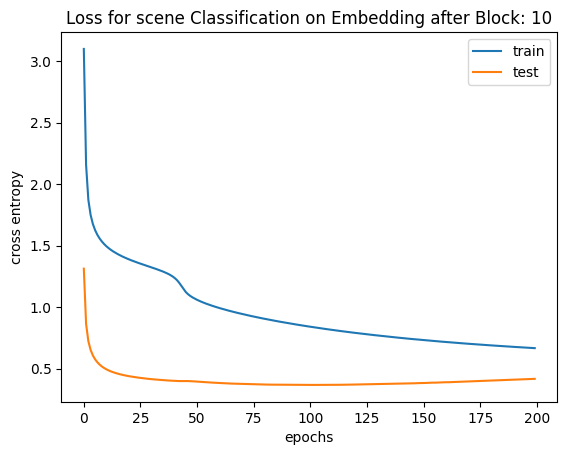

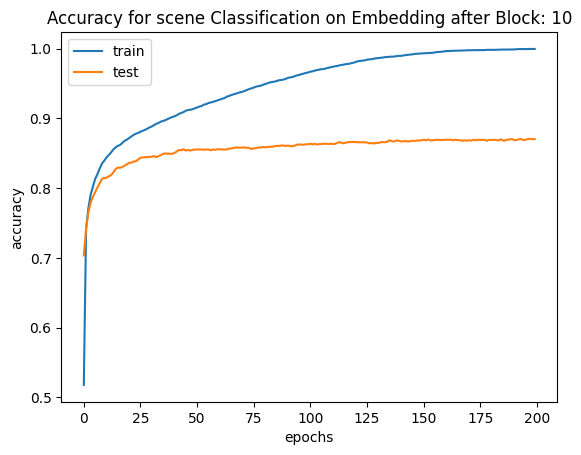

In [264]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [265]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [266]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [267]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [268]:
X_test=train_ready(test_data,col_name)

In [269]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

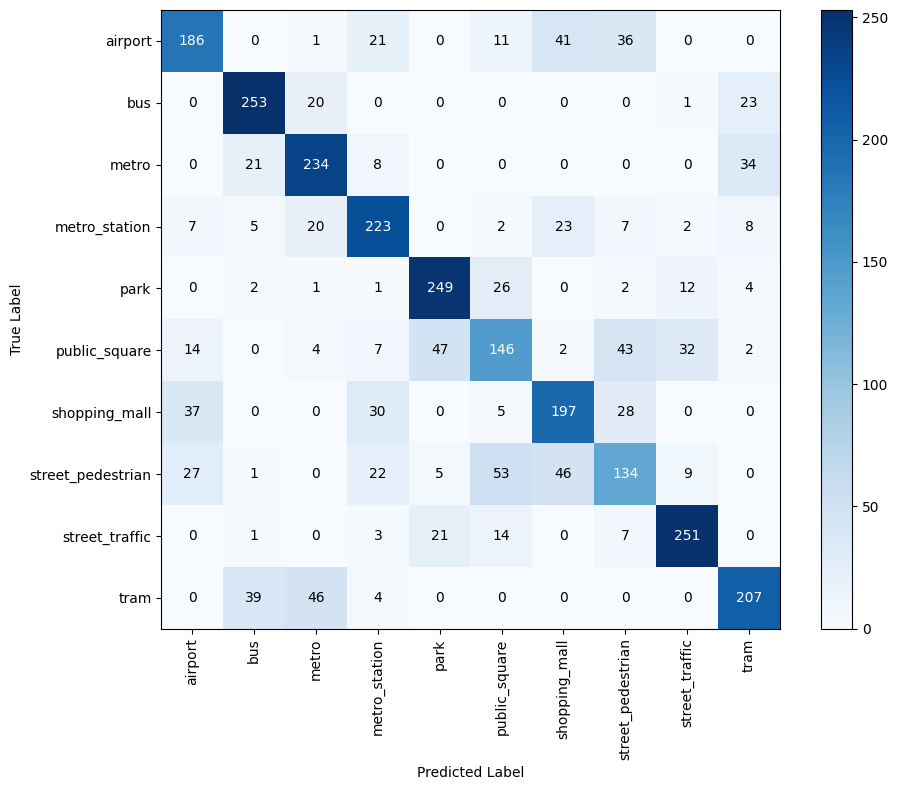

Accuracy: 0.7008


In [270]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-11

In [271]:
Block_number=11

In [272]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [273]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [274]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


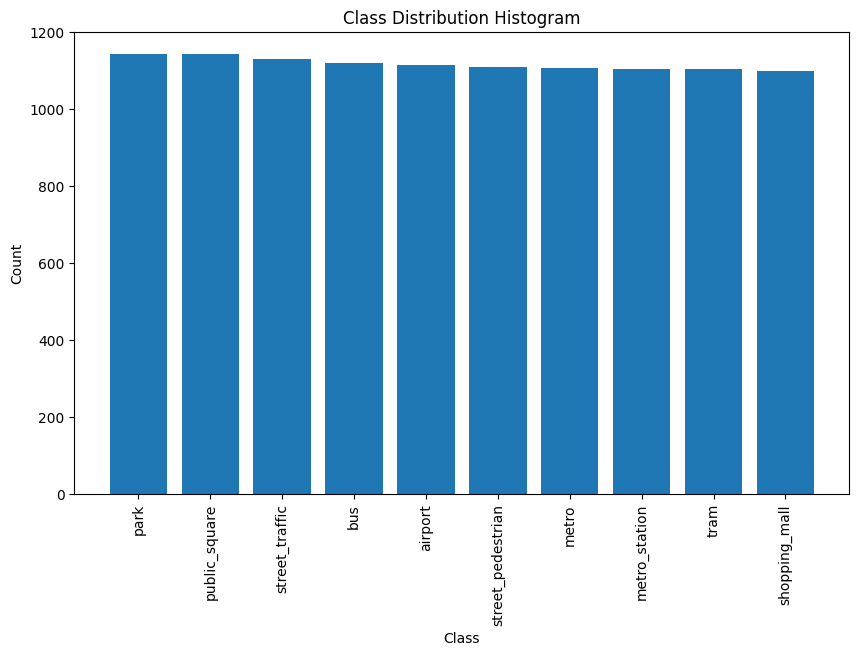

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [275]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


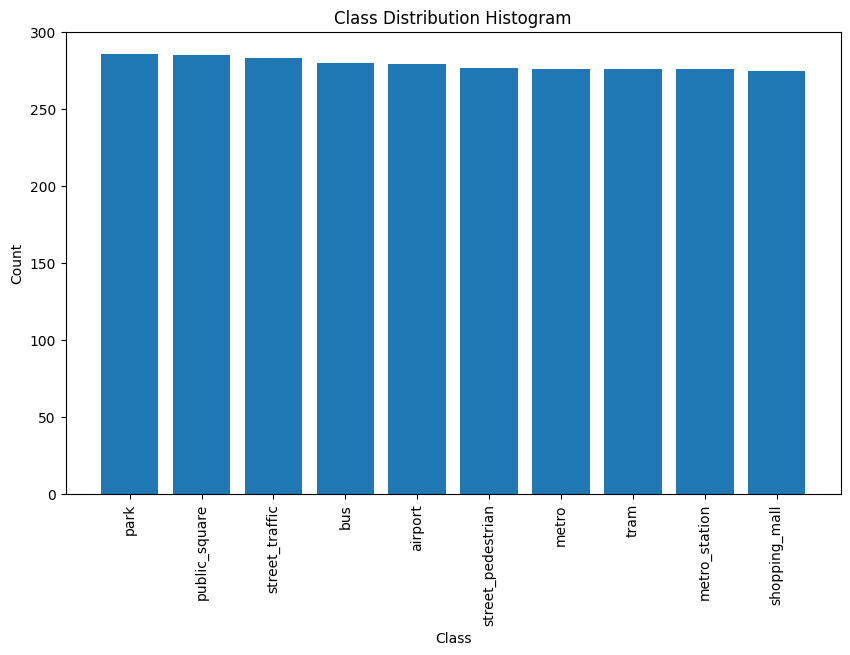

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [276]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [277]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [278]:
X_train_tensor.shape

torch.Size([11169, 768])

In [279]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [280]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 288.97batch/s, acc=0.781, loss=2.41]


Epoch 0 validation: Cross-entropy=1.03, Accuracy=76.4%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 303.49batch/s, acc=0.797, loss=2.08]


Epoch 1 validation: Cross-entropy=0.68, Accuracy=79.7%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 384.44batch/s, acc=0.812, loss=1.98]


Epoch 2 validation: Cross-entropy=0.58, Accuracy=81.4%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 309.86batch/s, acc=0.844, loss=1.93]


Epoch 3 validation: Cross-entropy=0.53, Accuracy=82.7%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 384.01batch/s, acc=0.828, loss=1.89]


Epoch 4 validation: Cross-entropy=0.50, Accuracy=83.8%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 347.40batch/s, acc=0.828, loss=1.87]


Epoch 5 validation: Cross-entropy=0.47, Accuracy=84.4%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 300.43batch/s, acc=0.828, loss=1.85]


Epoch 6 validation: Cross-entropy=0.46, Accuracy=84.9%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 377.70batch/s, acc=0.828, loss=1.83]


Epoch 7 validation: Cross-entropy=0.45, Accuracy=85.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 320.18batch/s, acc=0.812, loss=1.81] 


Epoch 8 validation: Cross-entropy=0.44, Accuracy=85.4%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 373.06batch/s, acc=0.812, loss=1.79] 


Epoch 9 validation: Cross-entropy=0.43, Accuracy=85.4%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 311.28batch/s, acc=0.812, loss=1.77] 


Epoch 10 validation: Cross-entropy=0.42, Accuracy=85.7%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 376.03batch/s, acc=0.812, loss=1.75] 


Epoch 11 validation: Cross-entropy=0.42, Accuracy=85.8%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 339.81batch/s, acc=0.828, loss=1.73] 


Epoch 12 validation: Cross-entropy=0.41, Accuracy=85.8%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 250.98batch/s, acc=0.828, loss=1.72] 


Epoch 13 validation: Cross-entropy=0.41, Accuracy=86.0%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 294.61batch/s, acc=0.828, loss=1.7]  


Epoch 14 validation: Cross-entropy=0.40, Accuracy=86.3%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 377.89batch/s, acc=0.828, loss=1.69] 


Epoch 15 validation: Cross-entropy=0.40, Accuracy=86.4%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 309.32batch/s, acc=0.828, loss=1.67] 


Epoch 16 validation: Cross-entropy=0.39, Accuracy=86.5%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 356.65batch/s, acc=0.828, loss=1.66] 


Epoch 17 validation: Cross-entropy=0.39, Accuracy=86.7%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 227.82batch/s, acc=0.828, loss=1.65] 


Epoch 18 validation: Cross-entropy=0.39, Accuracy=86.5%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 212.01batch/s, acc=0.828, loss=1.64] 


Epoch 19 validation: Cross-entropy=0.38, Accuracy=86.6%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 324.13batch/s, acc=0.828, loss=1.63] 


Epoch 20 validation: Cross-entropy=0.38, Accuracy=86.8%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 277.22batch/s, acc=0.844, loss=1.62] 


Epoch 21 validation: Cross-entropy=0.38, Accuracy=87.1%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 348.73batch/s, acc=0.844, loss=1.61] 


Epoch 22 validation: Cross-entropy=0.38, Accuracy=87.1%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 274.65batch/s, acc=0.844, loss=1.6]  


Epoch 23 validation: Cross-entropy=0.37, Accuracy=87.1%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 342.89batch/s, acc=0.844, loss=1.59] 


Epoch 24 validation: Cross-entropy=0.37, Accuracy=87.3%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 305.38batch/s, acc=0.844, loss=1.58] 


Epoch 25 validation: Cross-entropy=0.37, Accuracy=87.1%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 256.98batch/s, acc=0.844, loss=1.58] 


Epoch 26 validation: Cross-entropy=0.37, Accuracy=87.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 341.16batch/s, acc=0.844, loss=1.57] 


Epoch 27 validation: Cross-entropy=0.37, Accuracy=87.4%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 277.30batch/s, acc=0.844, loss=1.56] 


Epoch 28 validation: Cross-entropy=0.36, Accuracy=87.5%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 331.94batch/s, acc=0.844, loss=1.55] 


Epoch 29 validation: Cross-entropy=0.36, Accuracy=87.5%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 326.89batch/s, acc=0.844, loss=1.55] 


Epoch 30 validation: Cross-entropy=0.36, Accuracy=87.5%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 297.57batch/s, acc=0.844, loss=1.54] 


Epoch 31 validation: Cross-entropy=0.36, Accuracy=87.6%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 301.58batch/s, acc=0.844, loss=1.54] 


Epoch 32 validation: Cross-entropy=0.36, Accuracy=87.8%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 319.58batch/s, acc=0.844, loss=1.53] 


Epoch 33 validation: Cross-entropy=0.36, Accuracy=87.8%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 314.14batch/s, acc=0.844, loss=1.52] 


Epoch 34 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 382.18batch/s, acc=0.844, loss=1.52] 


Epoch 35 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 274.04batch/s, acc=0.859, loss=1.51] 


Epoch 36 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 305.50batch/s, acc=0.859, loss=1.5]  


Epoch 37 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 395.98batch/s, acc=0.859, loss=1.5]  


Epoch 38 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 233.13batch/s, acc=0.859, loss=1.49] 


Epoch 39 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 268.55batch/s, acc=0.859, loss=1.49] 


Epoch 40 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 317.53batch/s, acc=0.859, loss=1.48] 


Epoch 41 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 255.24batch/s, acc=0.859, loss=1.47] 


Epoch 42 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 277.51batch/s, acc=0.859, loss=1.47] 


Epoch 43 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 323.46batch/s, acc=0.859, loss=1.46] 


Epoch 44 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 251.60batch/s, acc=0.859, loss=1.46] 


Epoch 45 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 395.87batch/s, acc=0.859, loss=1.45] 


Epoch 46 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 314.09batch/s, acc=0.859, loss=1.45] 


Epoch 47 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 373.10batch/s, acc=0.859, loss=1.44] 


Epoch 48 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 324.01batch/s, acc=0.859, loss=1.44] 


Epoch 49 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 362.03batch/s, acc=0.859, loss=1.43] 


Epoch 50 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 341.81batch/s, acc=0.859, loss=1.43] 


Epoch 51 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 279.61batch/s, acc=0.859, loss=1.42] 


Epoch 52 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 375.25batch/s, acc=0.859, loss=1.42] 


Epoch 53 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 319.93batch/s, acc=0.859, loss=1.41] 


Epoch 54 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 278.92batch/s, acc=0.875, loss=1.4]  


Epoch 55 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 388.91batch/s, acc=0.875, loss=1.4]  


Epoch 56 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 324.96batch/s, acc=0.875, loss=1.39] 


Epoch 57 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 313.75batch/s, acc=0.875, loss=1.39] 


Epoch 58 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 331.39batch/s, acc=0.875, loss=1.38] 


Epoch 59 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 297.80batch/s, acc=0.875, loss=1.38] 


Epoch 60 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 326.65batch/s, acc=0.875, loss=1.37] 


Epoch 61 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 391.49batch/s, acc=0.891, loss=1.37] 


Epoch 62 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 314.98batch/s, acc=0.891, loss=1.36] 


Epoch 63 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 393.01batch/s, acc=0.906, loss=1.36] 


Epoch 64 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 320.08batch/s, acc=0.906, loss=1.35] 


Epoch 65 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 268.23batch/s, acc=0.906, loss=1.35] 


Epoch 66 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 389.55batch/s, acc=0.906, loss=1.34] 


Epoch 67 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 325.90batch/s, acc=0.906, loss=1.34] 


Epoch 68 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 396.59batch/s, acc=0.906, loss=1.33] 


Epoch 69 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 324.01batch/s, acc=0.906, loss=1.33] 


Epoch 70 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 359.84batch/s, acc=0.906, loss=1.32] 


Epoch 71 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 359.17batch/s, acc=0.906, loss=1.32] 


Epoch 72 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 281.62batch/s, acc=0.906, loss=1.31] 


Epoch 73 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 396.63batch/s, acc=0.906, loss=1.31] 


Epoch 74 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 330.03batch/s, acc=0.922, loss=1.3]  


Epoch 75 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 327.82batch/s, acc=0.938, loss=1.3]  


Epoch 76 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 393.54batch/s, acc=0.938, loss=1.3]  


Epoch 77 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 329.99batch/s, acc=0.938, loss=1.29] 


Epoch 78 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 342.58batch/s, acc=0.938, loss=1.29] 


Epoch 79 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 333.99batch/s, acc=0.938, loss=1.28] 


Epoch 80 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 314.35batch/s, acc=0.938, loss=1.28] 


Epoch 81 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 372.47batch/s, acc=0.938, loss=1.28] 


Epoch 82 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 360.86batch/s, acc=0.938, loss=1.27] 


Epoch 83 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 325.95batch/s, acc=0.938, loss=1.27] 


Epoch 84 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 401.37batch/s, acc=0.953, loss=1.26] 


Epoch 85 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 332.57batch/s, acc=0.953, loss=1.26] 


Epoch 86 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 355.71batch/s, acc=0.953, loss=1.25] 


Epoch 87 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 297.53batch/s, acc=0.953, loss=1.25] 


Epoch 88 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 355.24batch/s, acc=0.953, loss=1.25] 


Epoch 89 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 362.44batch/s, acc=0.969, loss=1.24] 


Epoch 90 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 336.78batch/s, acc=0.969, loss=1.24] 


Epoch 91 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 399.22batch/s, acc=0.969, loss=1.24] 


Epoch 92 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 325.86batch/s, acc=0.969, loss=1.23] 


Epoch 93 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 410.03batch/s, acc=0.969, loss=1.23] 


Epoch 94 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 275.13batch/s, acc=0.969, loss=1.22] 


Epoch 95 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 331.89batch/s, acc=0.969, loss=1.22] 


Epoch 96 validation: Cross-entropy=0.35, Accuracy=88.5%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 370.30batch/s, acc=0.969, loss=1.22] 


Epoch 97 validation: Cross-entropy=0.35, Accuracy=88.5%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 326.30batch/s, acc=0.984, loss=1.21] 


Epoch 98 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 394.80batch/s, acc=0.984, loss=1.21] 


Epoch 99 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 328.34batch/s, acc=0.984, loss=1.21] 


Epoch 100 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 317.87batch/s, acc=0.984, loss=1.2]  


Epoch 101 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 324.54batch/s, acc=0.984, loss=1.2]  


Epoch 102 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 306.79batch/s, acc=0.984, loss=1.19] 


Epoch 103 validation: Cross-entropy=0.35, Accuracy=88.6%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 334.79batch/s, acc=0.984, loss=1.19] 


Epoch 104 validation: Cross-entropy=0.35, Accuracy=88.3%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 381.24batch/s, acc=0.984, loss=1.19] 


Epoch 105 validation: Cross-entropy=0.35, Accuracy=88.5%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 319.72batch/s, acc=0.984, loss=1.18] 


Epoch 106 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 394.56batch/s, acc=0.984, loss=1.18] 


Epoch 107 validation: Cross-entropy=0.35, Accuracy=88.5%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 320.67batch/s, acc=0.984, loss=1.18] 


Epoch 108 validation: Cross-entropy=0.35, Accuracy=88.5%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 274.42batch/s, acc=0.984, loss=1.17] 


Epoch 109 validation: Cross-entropy=0.35, Accuracy=88.5%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 396.39batch/s, acc=0.984, loss=1.17] 


Epoch 110 validation: Cross-entropy=0.35, Accuracy=88.3%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 335.42batch/s, acc=0.984, loss=1.17] 


Epoch 111 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 395.58batch/s, acc=0.984, loss=1.16] 


Epoch 112 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 320.75batch/s, acc=0.984, loss=1.16] 


Epoch 113 validation: Cross-entropy=0.35, Accuracy=88.4%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 336.01batch/s, acc=0.984, loss=1.16] 


Epoch 114 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 343.04batch/s, acc=0.984, loss=1.15] 


Epoch 115 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 221.05batch/s, acc=0.984, loss=1.15] 


Epoch 116 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 363.69batch/s, acc=0.984, loss=1.15] 


Epoch 117 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 290.46batch/s, acc=0.984, loss=1.14] 


Epoch 118 validation: Cross-entropy=0.36, Accuracy=88.4%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 383.65batch/s, acc=0.984, loss=1.14] 


Epoch 119 validation: Cross-entropy=0.36, Accuracy=88.4%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 360.67batch/s, acc=0.984, loss=1.14] 


Epoch 120 validation: Cross-entropy=0.36, Accuracy=88.4%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 344.47batch/s, acc=0.984, loss=1.14] 


Epoch 121 validation: Cross-entropy=0.36, Accuracy=88.4%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 293.79batch/s, acc=0.984, loss=1.13] 


Epoch 122 validation: Cross-entropy=0.36, Accuracy=88.4%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 279.61batch/s, acc=0.984, loss=1.13] 


Epoch 123 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 352.41batch/s, acc=1, loss=1.13]     


Epoch 124 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 323.67batch/s, acc=1, loss=1.12]     


Epoch 125 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 378.78batch/s, acc=1, loss=1.12]     


Epoch 126 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 314.57batch/s, acc=1, loss=1.12]     


Epoch 127 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 350.58batch/s, acc=1, loss=1.12]     


Epoch 128 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 266.27batch/s, acc=1, loss=1.11]     


Epoch 129 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 278.99batch/s, acc=1, loss=1.11]     


Epoch 130 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 304.65batch/s, acc=1, loss=1.11]     


Epoch 131 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 348.38batch/s, acc=1, loss=1.11]     


Epoch 132 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 318.15batch/s, acc=1, loss=1.1]      


Epoch 133 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 307.27batch/s, acc=1, loss=1.1]      


Epoch 134 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 310.04batch/s, acc=1, loss=1.1]      


Epoch 135 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 252.51batch/s, acc=1, loss=1.1]      


Epoch 136 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 379.71batch/s, acc=1, loss=1.09]     


Epoch 137 validation: Cross-entropy=0.37, Accuracy=88.3%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 272.05batch/s, acc=1, loss=1.09]     


Epoch 138 validation: Cross-entropy=0.37, Accuracy=88.4%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 353.50batch/s, acc=1, loss=1.09]     


Epoch 139 validation: Cross-entropy=0.38, Accuracy=88.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 294.47batch/s, acc=1, loss=1.09]     


Epoch 140 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 343.25batch/s, acc=1, loss=1.09]     


Epoch 141 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 229.81batch/s, acc=1, loss=1.09]     


Epoch 142 validation: Cross-entropy=0.38, Accuracy=88.2%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 298.71batch/s, acc=1, loss=1.08]     


Epoch 143 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 241.37batch/s, acc=1, loss=1.08]     


Epoch 144 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 276.33batch/s, acc=1, loss=1.08]     


Epoch 145 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 321.51batch/s, acc=1, loss=1.08]     


Epoch 146 validation: Cross-entropy=0.38, Accuracy=88.2%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 329.15batch/s, acc=1, loss=1.08]     


Epoch 147 validation: Cross-entropy=0.38, Accuracy=88.1%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 232.09batch/s, acc=1, loss=1.07]     


Epoch 148 validation: Cross-entropy=0.38, Accuracy=88.2%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 312.93batch/s, acc=1, loss=1.07]     


Epoch 149 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 264.34batch/s, acc=1, loss=1.07]     


Epoch 150 validation: Cross-entropy=0.39, Accuracy=88.3%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 349.47batch/s, acc=1, loss=1.07]     


Epoch 151 validation: Cross-entropy=0.39, Accuracy=88.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 265.77batch/s, acc=1, loss=1.07]     


Epoch 152 validation: Cross-entropy=0.39, Accuracy=88.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 321.50batch/s, acc=1, loss=1.07]     


Epoch 153 validation: Cross-entropy=0.39, Accuracy=88.2%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 230.92batch/s, acc=1, loss=1.06]     


Epoch 154 validation: Cross-entropy=0.39, Accuracy=88.1%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 340.18batch/s, acc=1, loss=1.06]     


Epoch 155 validation: Cross-entropy=0.39, Accuracy=88.1%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 252.56batch/s, acc=1, loss=1.06]     


Epoch 156 validation: Cross-entropy=0.39, Accuracy=88.1%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 353.74batch/s, acc=1, loss=1.06]   


Epoch 157 validation: Cross-entropy=0.39, Accuracy=88.1%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 278.71batch/s, acc=1, loss=1.06]   


Epoch 158 validation: Cross-entropy=0.39, Accuracy=88.1%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 281.94batch/s, acc=1, loss=1.06] 


Epoch 159 validation: Cross-entropy=0.39, Accuracy=88.2%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 273.79batch/s, acc=1, loss=1.06] 


Epoch 160 validation: Cross-entropy=0.40, Accuracy=88.1%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 318.06batch/s, acc=1, loss=1.06] 


Epoch 161 validation: Cross-entropy=0.40, Accuracy=88.1%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 266.49batch/s, acc=1, loss=1.05] 


Epoch 162 validation: Cross-entropy=0.40, Accuracy=88.1%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 321.72batch/s, acc=1, loss=1.05] 


Epoch 163 validation: Cross-entropy=0.40, Accuracy=88.1%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 270.72batch/s, acc=1, loss=1.05] 


Epoch 164 validation: Cross-entropy=0.40, Accuracy=88.0%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 257.08batch/s, acc=1, loss=1.05] 


Epoch 165 validation: Cross-entropy=0.40, Accuracy=88.0%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 341.67batch/s, acc=1, loss=1.05] 


Epoch 166 validation: Cross-entropy=0.40, Accuracy=88.0%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 277.41batch/s, acc=1, loss=1.05] 


Epoch 167 validation: Cross-entropy=0.40, Accuracy=88.1%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 341.33batch/s, acc=1, loss=1.05] 


Epoch 168 validation: Cross-entropy=0.40, Accuracy=88.0%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 271.21batch/s, acc=1, loss=1.05] 


Epoch 169 validation: Cross-entropy=0.40, Accuracy=88.0%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 347.27batch/s, acc=1, loss=1.05] 


Epoch 170 validation: Cross-entropy=0.41, Accuracy=88.0%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 238.20batch/s, acc=1, loss=1.05] 


Epoch 171 validation: Cross-entropy=0.41, Accuracy=88.1%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 344.76batch/s, acc=1, loss=1.05] 


Epoch 172 validation: Cross-entropy=0.41, Accuracy=88.1%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 280.67batch/s, acc=1, loss=1.04] 


Epoch 173 validation: Cross-entropy=0.41, Accuracy=88.0%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 280.44batch/s, acc=1, loss=1.04] 


Epoch 174 validation: Cross-entropy=0.41, Accuracy=88.0%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 342.69batch/s, acc=1, loss=1.04] 


Epoch 175 validation: Cross-entropy=0.41, Accuracy=88.1%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 338.85batch/s, acc=1, loss=1.04] 


Epoch 176 validation: Cross-entropy=0.41, Accuracy=88.0%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 235.89batch/s, acc=1, loss=1.04] 


Epoch 177 validation: Cross-entropy=0.41, Accuracy=88.0%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 278.92batch/s, acc=1, loss=1.04] 


Epoch 178 validation: Cross-entropy=0.42, Accuracy=88.1%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 358.37batch/s, acc=1, loss=1.04] 


Epoch 179 validation: Cross-entropy=0.42, Accuracy=88.1%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 353.98batch/s, acc=1, loss=1.04] 


Epoch 180 validation: Cross-entropy=0.42, Accuracy=88.1%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 298.73batch/s, acc=1, loss=1.04] 


Epoch 181 validation: Cross-entropy=0.42, Accuracy=88.0%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 352.06batch/s, acc=1, loss=1.04] 


Epoch 182 validation: Cross-entropy=0.42, Accuracy=88.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 242.34batch/s, acc=1, loss=1.04] 


Epoch 183 validation: Cross-entropy=0.42, Accuracy=88.1%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 345.79batch/s, acc=1, loss=1.04] 


Epoch 184 validation: Cross-entropy=0.42, Accuracy=88.0%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 299.63batch/s, acc=1, loss=1.04] 


Epoch 185 validation: Cross-entropy=0.42, Accuracy=88.0%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 342.18batch/s, acc=1, loss=1.04] 


Epoch 186 validation: Cross-entropy=0.42, Accuracy=88.1%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 287.80batch/s, acc=1, loss=1.04] 


Epoch 187 validation: Cross-entropy=0.42, Accuracy=88.0%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 297.59batch/s, acc=1, loss=1.03] 


Epoch 188 validation: Cross-entropy=0.42, Accuracy=88.0%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 278.20batch/s, acc=1, loss=1.03] 


Epoch 189 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 357.76batch/s, acc=1, loss=1.03] 


Epoch 190 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 284.17batch/s, acc=1, loss=1.03] 


Epoch 191 validation: Cross-entropy=0.43, Accuracy=88.1%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 359.63batch/s, acc=1, loss=1.03] 


Epoch 192 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 340.14batch/s, acc=1, loss=1.03] 


Epoch 193 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 301.92batch/s, acc=1, loss=1.03] 


Epoch 194 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 290.36batch/s, acc=1, loss=1.03] 


Epoch 195 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 284.74batch/s, acc=1, loss=1.03] 


Epoch 196 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 348.17batch/s, acc=1, loss=1.03] 


Epoch 197 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 285.86batch/s, acc=1, loss=1.03] 


Epoch 198 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 336.03batch/s, acc=1, loss=1.03] 


Epoch 199 validation: Cross-entropy=0.44, Accuracy=88.0%


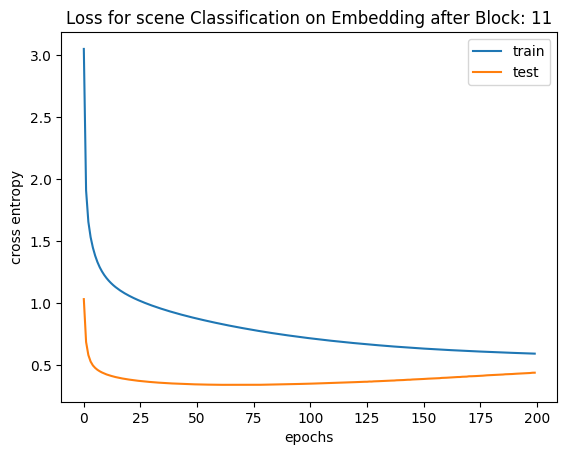

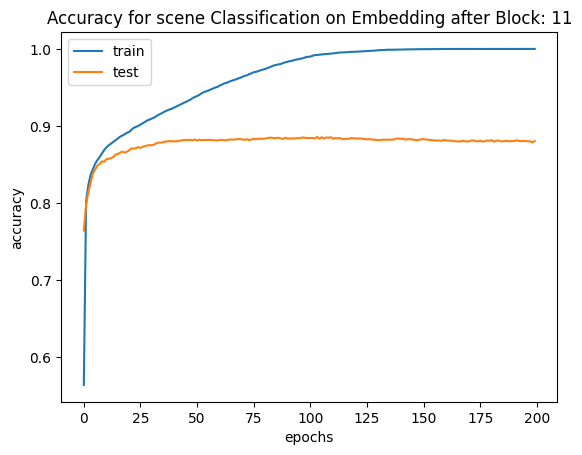

In [281]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [282]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [283]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [284]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [285]:
X_test=train_ready(test_data,col_name)

In [286]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

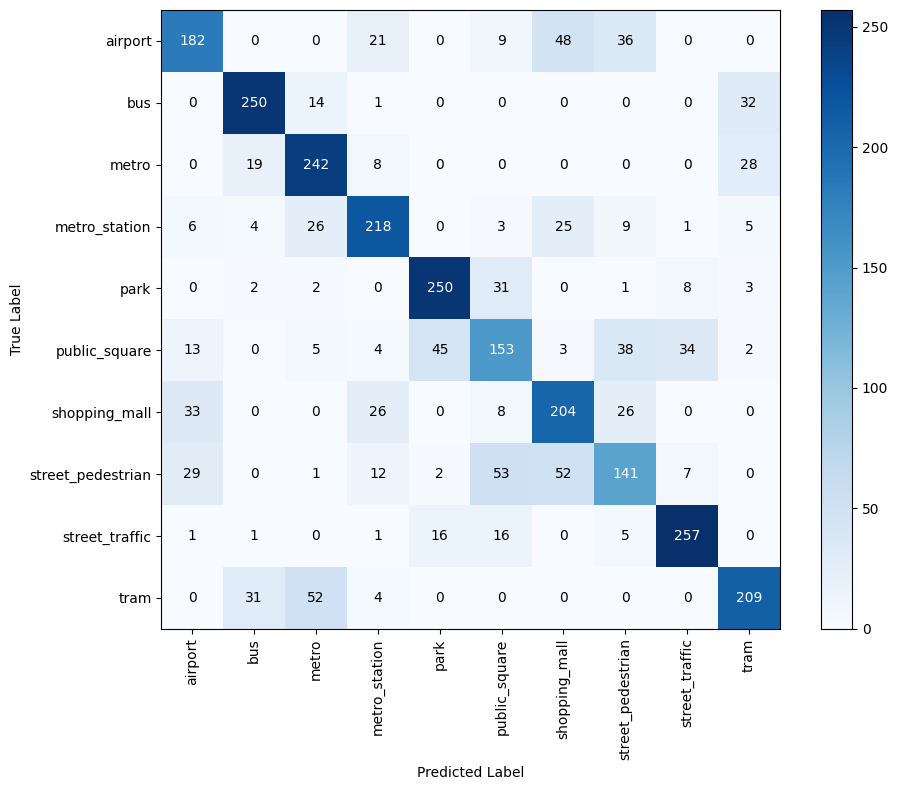

Accuracy: 0.7096


In [287]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-12


In [288]:
Block_number=12

In [289]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [290]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [291]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


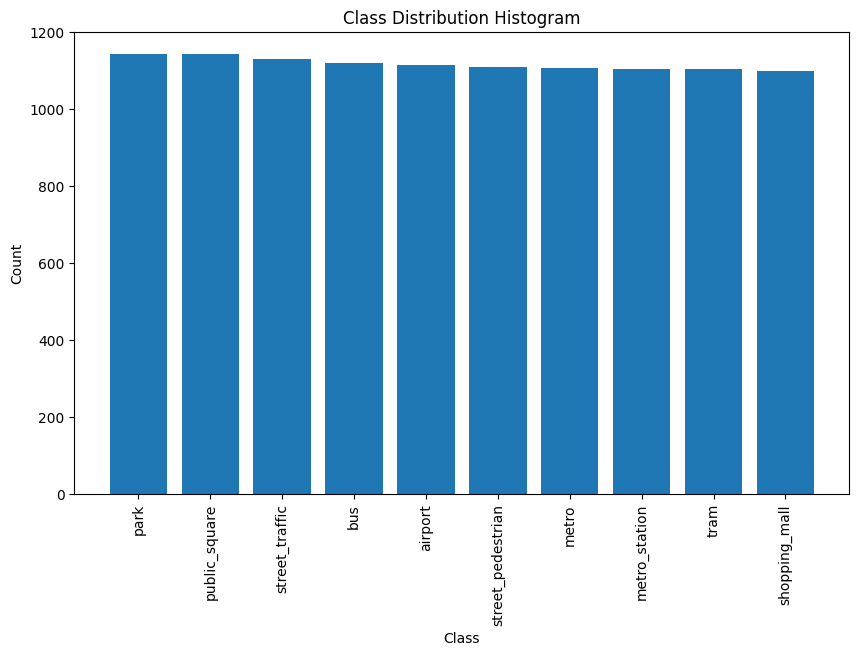

{'metro': 1106,
 'tram': 1103,
 'street_traffic': 1130,
 'park': 1143,
 'bus': 1120,
 'shopping_mall': 1098,
 'metro_station': 1104,
 'airport': 1114,
 'public_square': 1142,
 'street_pedestrian': 1109}

In [292]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


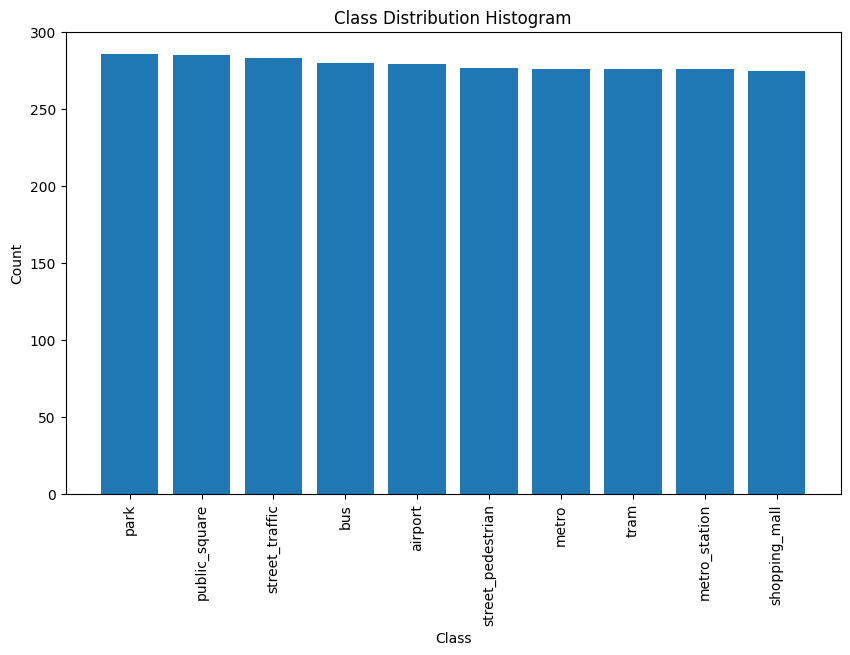

{'metro': 276,
 'tram': 276,
 'street_traffic': 283,
 'park': 286,
 'bus': 280,
 'shopping_mall': 275,
 'metro_station': 276,
 'airport': 279,
 'public_square': 285,
 'street_pedestrian': 277}

In [293]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [294]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [295]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return emb,logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [296]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 342.45batch/s, acc=0.797, loss=2.58]


Epoch 0 validation: Cross-entropy=1.05, Accuracy=78.4%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 265.82batch/s, acc=0.828, loss=2.18]


Epoch 1 validation: Cross-entropy=0.68, Accuracy=81.3%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 380.43batch/s, acc=0.828, loss=2.04]


Epoch 2 validation: Cross-entropy=0.56, Accuracy=83.1%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 314.58batch/s, acc=0.844, loss=1.97]


Epoch 3 validation: Cross-entropy=0.51, Accuracy=84.1%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 384.82batch/s, acc=0.844, loss=1.93]


Epoch 4 validation: Cross-entropy=0.47, Accuracy=84.5%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 376.00batch/s, acc=0.844, loss=1.89] 


Epoch 5 validation: Cross-entropy=0.45, Accuracy=84.9%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 276.13batch/s, acc=0.844, loss=1.86] 


Epoch 6 validation: Cross-entropy=0.44, Accuracy=85.6%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 399.18batch/s, acc=0.844, loss=1.84] 


Epoch 7 validation: Cross-entropy=0.42, Accuracy=85.8%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 315.32batch/s, acc=0.844, loss=1.81] 


Epoch 8 validation: Cross-entropy=0.41, Accuracy=86.0%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 377.98batch/s, acc=0.828, loss=1.79] 


Epoch 9 validation: Cross-entropy=0.41, Accuracy=86.3%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 316.25batch/s, acc=0.828, loss=1.77] 


Epoch 10 validation: Cross-entropy=0.40, Accuracy=86.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 380.61batch/s, acc=0.844, loss=1.76] 


Epoch 11 validation: Cross-entropy=0.39, Accuracy=86.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 315.80batch/s, acc=0.844, loss=1.74] 


Epoch 12 validation: Cross-entropy=0.39, Accuracy=86.5%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 319.31batch/s, acc=0.844, loss=1.72] 


Epoch 13 validation: Cross-entropy=0.39, Accuracy=86.5%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 321.52batch/s, acc=0.844, loss=1.71] 


Epoch 14 validation: Cross-entropy=0.38, Accuracy=86.7%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 367.26batch/s, acc=0.844, loss=1.69] 


Epoch 15 validation: Cross-entropy=0.38, Accuracy=86.9%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 383.49batch/s, acc=0.844, loss=1.68] 


Epoch 16 validation: Cross-entropy=0.37, Accuracy=86.9%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 324.78batch/s, acc=0.859, loss=1.66] 


Epoch 17 validation: Cross-entropy=0.37, Accuracy=87.0%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 374.13batch/s, acc=0.859, loss=1.65] 


Epoch 18 validation: Cross-entropy=0.37, Accuracy=87.1%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 322.58batch/s, acc=0.859, loss=1.64] 


Epoch 19 validation: Cross-entropy=0.37, Accuracy=87.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 318.35batch/s, acc=0.859, loss=1.63] 


Epoch 20 validation: Cross-entropy=0.36, Accuracy=87.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 315.98batch/s, acc=0.859, loss=1.62] 


Epoch 21 validation: Cross-entropy=0.36, Accuracy=87.3%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 379.79batch/s, acc=0.859, loss=1.61] 


Epoch 22 validation: Cross-entropy=0.36, Accuracy=87.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 333.03batch/s, acc=0.859, loss=1.6]  


Epoch 23 validation: Cross-entropy=0.36, Accuracy=87.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 358.96batch/s, acc=0.859, loss=1.59] 


Epoch 24 validation: Cross-entropy=0.36, Accuracy=87.5%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 373.96batch/s, acc=0.859, loss=1.58] 


Epoch 25 validation: Cross-entropy=0.36, Accuracy=87.4%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 335.36batch/s, acc=0.859, loss=1.57] 


Epoch 26 validation: Cross-entropy=0.35, Accuracy=87.7%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 321.00batch/s, acc=0.859, loss=1.56] 


Epoch 27 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 318.94batch/s, acc=0.875, loss=1.55] 


Epoch 28 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 385.72batch/s, acc=0.875, loss=1.54] 


Epoch 29 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 320.21batch/s, acc=0.875, loss=1.53] 


Epoch 30 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 394.16batch/s, acc=0.875, loss=1.52] 


Epoch 31 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 344.79batch/s, acc=0.875, loss=1.52] 


Epoch 32 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 357.90batch/s, acc=0.875, loss=1.51] 


Epoch 33 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 320.57batch/s, acc=0.875, loss=1.5]  


Epoch 34 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 318.66batch/s, acc=0.875, loss=1.49] 


Epoch 35 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 375.44batch/s, acc=0.875, loss=1.48] 


Epoch 36 validation: Cross-entropy=0.34, Accuracy=88.0%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 321.34batch/s, acc=0.875, loss=1.48] 


Epoch 37 validation: Cross-entropy=0.34, Accuracy=88.0%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 383.03batch/s, acc=0.875, loss=1.47] 


Epoch 38 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 326.07batch/s, acc=0.875, loss=1.46] 


Epoch 39 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 384.34batch/s, acc=0.875, loss=1.46] 


Epoch 40 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 262.73batch/s, acc=0.875, loss=1.45] 


Epoch 41 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 386.86batch/s, acc=0.891, loss=1.44] 


Epoch 42 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 322.51batch/s, acc=0.891, loss=1.43] 


Epoch 43 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 387.67batch/s, acc=0.891, loss=1.43] 


Epoch 44 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 320.67batch/s, acc=0.891, loss=1.42] 


Epoch 45 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 330.74batch/s, acc=0.891, loss=1.41] 


Epoch 46 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 385.02batch/s, acc=0.891, loss=1.41] 


Epoch 47 validation: Cross-entropy=0.34, Accuracy=88.6%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 267.95batch/s, acc=0.891, loss=1.4]  


Epoch 48 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 348.92batch/s, acc=0.891, loss=1.39] 


Epoch 49 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 348.04batch/s, acc=0.891, loss=1.39] 


Epoch 50 validation: Cross-entropy=0.34, Accuracy=88.5%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 319.24batch/s, acc=0.891, loss=1.38] 


Epoch 51 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 399.10batch/s, acc=0.891, loss=1.37] 


Epoch 52 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 324.46batch/s, acc=0.891, loss=1.37] 


Epoch 53 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 330.78batch/s, acc=0.891, loss=1.36] 


Epoch 54 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 324.67batch/s, acc=0.891, loss=1.35] 


Epoch 55 validation: Cross-entropy=0.34, Accuracy=88.4%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 321.61batch/s, acc=0.891, loss=1.35] 


Epoch 56 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 391.26batch/s, acc=0.891, loss=1.34] 


Epoch 57 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 321.76batch/s, acc=0.891, loss=1.34] 


Epoch 58 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 357.92batch/s, acc=0.891, loss=1.33] 


Epoch 59 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 348.69batch/s, acc=0.891, loss=1.32] 


Epoch 60 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 330.58batch/s, acc=0.891, loss=1.32] 


Epoch 61 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 320.85batch/s, acc=0.891, loss=1.31] 


Epoch 62 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 321.34batch/s, acc=0.891, loss=1.31] 


Epoch 63 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 323.52batch/s, acc=0.891, loss=1.3]  


Epoch 64 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 394.24batch/s, acc=0.891, loss=1.3]  


Epoch 65 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 338.04batch/s, acc=0.891, loss=1.29] 


Epoch 66 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 388.60batch/s, acc=0.891, loss=1.28] 


Epoch 67 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 321.74batch/s, acc=0.891, loss=1.28] 


Epoch 68 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 271.47batch/s, acc=0.891, loss=1.27] 


Epoch 69 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 398.16batch/s, acc=0.891, loss=1.27] 


Epoch 70 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 316.51batch/s, acc=0.891, loss=1.26] 


Epoch 71 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 387.23batch/s, acc=0.891, loss=1.26] 


Epoch 72 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 331.36batch/s, acc=0.906, loss=1.25] 


Epoch 73 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 325.23batch/s, acc=0.906, loss=1.25] 


Epoch 74 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 395.70batch/s, acc=0.922, loss=1.24] 


Epoch 75 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 251.46batch/s, acc=0.938, loss=1.24] 


Epoch 76 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 264.54batch/s, acc=0.938, loss=1.23] 


Epoch 77 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 335.19batch/s, acc=0.938, loss=1.23] 


Epoch 78 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 248.61batch/s, acc=0.938, loss=1.22] 


Epoch 79 validation: Cross-entropy=0.34, Accuracy=88.3%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 306.01batch/s, acc=0.938, loss=1.22] 


Epoch 80 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 273.77batch/s, acc=0.953, loss=1.21] 


Epoch 81 validation: Cross-entropy=0.34, Accuracy=88.2%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 323.45batch/s, acc=0.953, loss=1.21] 


Epoch 82 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 282.86batch/s, acc=0.953, loss=1.2]  


Epoch 83 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 377.40batch/s, acc=0.953, loss=1.2]  


Epoch 84 validation: Cross-entropy=0.34, Accuracy=88.1%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 382.16batch/s, acc=0.953, loss=1.19] 


Epoch 85 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 318.43batch/s, acc=0.953, loss=1.19] 


Epoch 86 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 384.99batch/s, acc=0.953, loss=1.18] 


Epoch 87 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 314.32batch/s, acc=0.953, loss=1.18] 


Epoch 88 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 396.24batch/s, acc=0.953, loss=1.17] 


Epoch 89 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 269.24batch/s, acc=0.969, loss=1.17] 


Epoch 90 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 402.67batch/s, acc=0.969, loss=1.17] 


Epoch 91 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 324.75batch/s, acc=0.969, loss=1.16] 


Epoch 92 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 388.29batch/s, acc=0.969, loss=1.16] 


Epoch 93 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 317.15batch/s, acc=0.969, loss=1.15] 


Epoch 94 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 383.23batch/s, acc=0.969, loss=1.15] 


Epoch 95 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 318.11batch/s, acc=0.969, loss=1.14] 


Epoch 96 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 276.15batch/s, acc=0.969, loss=1.14] 


Epoch 97 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 344.63batch/s, acc=0.969, loss=1.14] 


Epoch 98 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 348.37batch/s, acc=0.984, loss=1.13] 


Epoch 99 validation: Cross-entropy=0.36, Accuracy=88.0%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 315.87batch/s, acc=0.984, loss=1.13] 


Epoch 100 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 386.77batch/s, acc=0.984, loss=1.13] 


Epoch 101 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 320.06batch/s, acc=0.984, loss=1.13] 


Epoch 102 validation: Cross-entropy=0.36, Accuracy=88.0%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 378.64batch/s, acc=0.984, loss=1.12] 


Epoch 103 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 270.61batch/s, acc=0.984, loss=1.12] 


Epoch 104 validation: Cross-entropy=0.36, Accuracy=88.0%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 320.36batch/s, acc=0.984, loss=1.12] 


Epoch 105 validation: Cross-entropy=0.36, Accuracy=87.9%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 355.65batch/s, acc=0.984, loss=1.11] 


Epoch 106 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 276.69batch/s, acc=0.984, loss=1.11] 


Epoch 107 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 301.30batch/s, acc=0.984, loss=1.11] 


Epoch 108 validation: Cross-entropy=0.36, Accuracy=88.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 365.28batch/s, acc=1, loss=1.1]      


Epoch 109 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 294.94batch/s, acc=1, loss=1.1]      


Epoch 110 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 256.23batch/s, acc=1, loss=1.1]      


Epoch 111 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 321.74batch/s, acc=1, loss=1.1]      


Epoch 112 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 258.70batch/s, acc=1, loss=1.1]      


Epoch 113 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 273.10batch/s, acc=1, loss=1.09]     


Epoch 114 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 307.74batch/s, acc=1, loss=1.09]     


Epoch 115 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 258.04batch/s, acc=1, loss=1.09]     


Epoch 116 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 273.49batch/s, acc=1, loss=1.09]     


Epoch 117 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 291.81batch/s, acc=1, loss=1.08]     


Epoch 118 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 326.23batch/s, acc=1, loss=1.08]     


Epoch 119 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 320.94batch/s, acc=1, loss=1.08]     


Epoch 120 validation: Cross-entropy=0.38, Accuracy=88.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 275.83batch/s, acc=1, loss=1.08]     


Epoch 121 validation: Cross-entropy=0.38, Accuracy=88.0%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 320.18batch/s, acc=1, loss=1.08]     


Epoch 122 validation: Cross-entropy=0.38, Accuracy=88.0%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 236.78batch/s, acc=1, loss=1.07]     


Epoch 123 validation: Cross-entropy=0.38, Accuracy=88.0%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 352.63batch/s, acc=1, loss=1.07]     


Epoch 124 validation: Cross-entropy=0.38, Accuracy=87.9%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 274.52batch/s, acc=1, loss=1.07]     


Epoch 125 validation: Cross-entropy=0.38, Accuracy=87.9%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 334.62batch/s, acc=1, loss=1.07]     


Epoch 126 validation: Cross-entropy=0.38, Accuracy=87.9%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 279.49batch/s, acc=1, loss=1.07]     


Epoch 127 validation: Cross-entropy=0.38, Accuracy=87.8%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 334.21batch/s, acc=1, loss=1.07]     


Epoch 128 validation: Cross-entropy=0.39, Accuracy=87.7%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 225.90batch/s, acc=1, loss=1.07]     


Epoch 129 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 328.42batch/s, acc=1, loss=1.06]     


Epoch 130 validation: Cross-entropy=0.39, Accuracy=87.8%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 276.42batch/s, acc=1, loss=1.06]     


Epoch 131 validation: Cross-entropy=0.39, Accuracy=87.8%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 327.78batch/s, acc=1, loss=1.06]     


Epoch 132 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 272.42batch/s, acc=1, loss=1.06]     


Epoch 133 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 338.82batch/s, acc=1, loss=1.06]     


Epoch 134 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 276.69batch/s, acc=1, loss=1.06]     


Epoch 135 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 271.08batch/s, acc=1, loss=1.06]     


Epoch 136 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 293.82batch/s, acc=1, loss=1.06]     


Epoch 137 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 287.51batch/s, acc=1, loss=1.05]     


Epoch 138 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 338.94batch/s, acc=1, loss=1.05]     


Epoch 139 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 269.31batch/s, acc=1, loss=1.05]     


Epoch 140 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 314.22batch/s, acc=1, loss=1.05]     


Epoch 141 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 247.38batch/s, acc=1, loss=1.05]     


Epoch 142 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 344.25batch/s, acc=1, loss=1.05]     


Epoch 143 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 257.02batch/s, acc=1, loss=1.05]     


Epoch 144 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 329.64batch/s, acc=1, loss=1.05]     


Epoch 145 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 274.28batch/s, acc=1, loss=1.05]     


Epoch 146 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 325.59batch/s, acc=1, loss=1.05]     


Epoch 147 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 268.68batch/s, acc=1, loss=1.05]     


Epoch 148 validation: Cross-entropy=0.41, Accuracy=87.9%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 251.26batch/s, acc=1, loss=1.04]     


Epoch 149 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 261.15batch/s, acc=1, loss=1.04]     


Epoch 150 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 327.61batch/s, acc=1, loss=1.04]    


Epoch 151 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 305.67batch/s, acc=1, loss=1.04]    


Epoch 152 validation: Cross-entropy=0.41, Accuracy=87.9%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 364.39batch/s, acc=1, loss=1.04]    


Epoch 153 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 312.19batch/s, acc=1, loss=1.04]    


Epoch 154 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 359.29batch/s, acc=1, loss=1.04]    


Epoch 155 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 323.07batch/s, acc=1, loss=1.04]    


Epoch 156 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 316.78batch/s, acc=1, loss=1.04]    


Epoch 157 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 379.79batch/s, acc=1, loss=1.04]    


Epoch 158 validation: Cross-entropy=0.42, Accuracy=87.9%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 312.49batch/s, acc=1, loss=1.04]    


Epoch 159 validation: Cross-entropy=0.42, Accuracy=87.9%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 385.93batch/s, acc=1, loss=1.04]    


Epoch 160 validation: Cross-entropy=0.42, Accuracy=88.0%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 317.27batch/s, acc=1, loss=1.04]    


Epoch 161 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 389.78batch/s, acc=1, loss=1.03]    


Epoch 162 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 255.92batch/s, acc=1, loss=1.03]    


Epoch 163 validation: Cross-entropy=0.43, Accuracy=88.1%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 359.99batch/s, acc=1, loss=1.03]   


Epoch 164 validation: Cross-entropy=0.43, Accuracy=88.0%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 324.01batch/s, acc=1, loss=1.03]    


Epoch 165 validation: Cross-entropy=0.43, Accuracy=88.1%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 302.29batch/s, acc=1, loss=1.03]    


Epoch 166 validation: Cross-entropy=0.43, Accuracy=88.1%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 378.17batch/s, acc=1, loss=1.03]    


Epoch 167 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 330.14batch/s, acc=1, loss=1.03]    


Epoch 168 validation: Cross-entropy=0.44, Accuracy=88.0%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 340.18batch/s, acc=1, loss=1.03]    


Epoch 169 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 303.40batch/s, acc=1, loss=1.03]    


Epoch 170 validation: Cross-entropy=0.44, Accuracy=88.1%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 402.71batch/s, acc=1, loss=1.03]    


Epoch 171 validation: Cross-entropy=0.44, Accuracy=88.0%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 316.32batch/s, acc=1, loss=1.03] 


Epoch 172 validation: Cross-entropy=0.44, Accuracy=88.0%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 382.13batch/s, acc=1, loss=1.03] 


Epoch 173 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 329.71batch/s, acc=1, loss=1.03] 


Epoch 174 validation: Cross-entropy=0.44, Accuracy=88.0%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 378.68batch/s, acc=1, loss=1.03] 


Epoch 175 validation: Cross-entropy=0.45, Accuracy=88.0%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 282.44batch/s, acc=1, loss=1.03] 


Epoch 176 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 339.99batch/s, acc=1, loss=1.02] 


Epoch 177 validation: Cross-entropy=0.45, Accuracy=88.0%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 305.17batch/s, acc=1, loss=1.02] 


Epoch 178 validation: Cross-entropy=0.45, Accuracy=88.0%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 322.25batch/s, acc=1, loss=1.02] 


Epoch 179 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 392.94batch/s, acc=1, loss=1.02] 


Epoch 180 validation: Cross-entropy=0.45, Accuracy=88.0%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 315.15batch/s, acc=1, loss=1.02] 


Epoch 181 validation: Cross-entropy=0.46, Accuracy=88.0%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 330.86batch/s, acc=1, loss=1.02] 


Epoch 182 validation: Cross-entropy=0.46, Accuracy=88.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 387.54batch/s, acc=1, loss=1.02] 


Epoch 183 validation: Cross-entropy=0.46, Accuracy=88.0%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 274.65batch/s, acc=1, loss=1.02] 


Epoch 184 validation: Cross-entropy=0.46, Accuracy=88.1%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 388.33batch/s, acc=1, loss=1.02] 


Epoch 185 validation: Cross-entropy=0.46, Accuracy=88.1%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 314.48batch/s, acc=1, loss=1.02] 


Epoch 186 validation: Cross-entropy=0.46, Accuracy=88.1%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 317.88batch/s, acc=1, loss=1.02] 


Epoch 187 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 381.35batch/s, acc=1, loss=1.02] 


Epoch 188 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 311.58batch/s, acc=1, loss=1.02] 


Epoch 189 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 333.59batch/s, acc=1, loss=1.02] 


Epoch 190 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 325.87batch/s, acc=1, loss=1.02] 


Epoch 191 validation: Cross-entropy=0.47, Accuracy=88.0%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 321.00batch/s, acc=1, loss=1.02] 


Epoch 192 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 386.86batch/s, acc=1, loss=1.02] 


Epoch 193 validation: Cross-entropy=0.47, Accuracy=88.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 324.06batch/s, acc=1, loss=1.02] 


Epoch 194 validation: Cross-entropy=0.48, Accuracy=88.0%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 325.15batch/s, acc=1, loss=1.02] 


Epoch 195 validation: Cross-entropy=0.48, Accuracy=87.9%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 384.85batch/s, acc=1, loss=1.02] 


Epoch 196 validation: Cross-entropy=0.48, Accuracy=88.0%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 311.25batch/s, acc=1, loss=1.02] 


Epoch 197 validation: Cross-entropy=0.48, Accuracy=87.9%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 335.26batch/s, acc=1, loss=1.02] 


Epoch 198 validation: Cross-entropy=0.48, Accuracy=87.9%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 318.33batch/s, acc=1, loss=1.02] 


Epoch 199 validation: Cross-entropy=0.48, Accuracy=87.9%


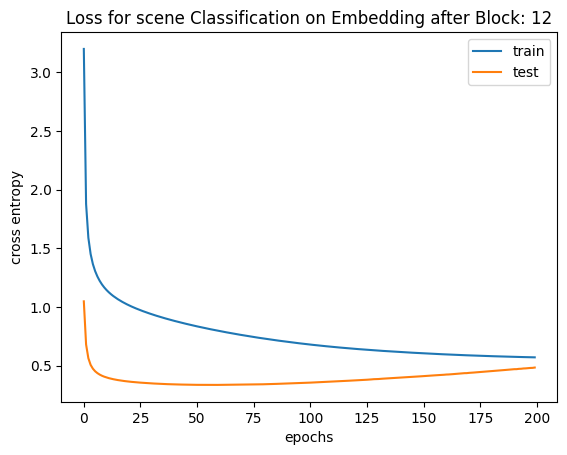

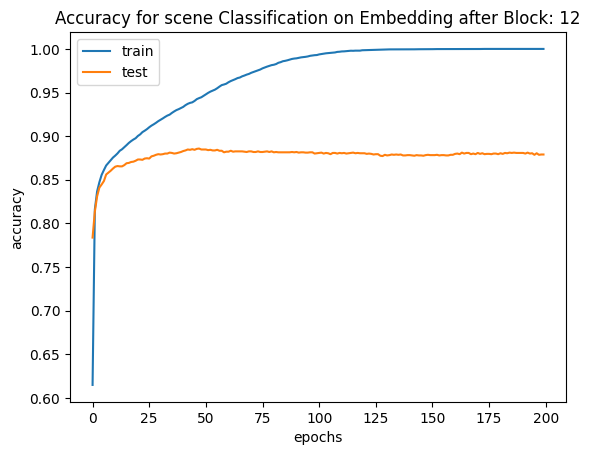

In [297]:
import tqdm
import copy
from loss import OrthogonalProjectionLoss
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size


op_loss = OrthogonalProjectionLoss()
op_lambda = 1

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            y_batch_norm = torch.argmax(y_batch, 1)

            # forward pass
            y_emb,y_pred = model(X_batch)
            loss_ce = criterion_ce(y_pred, y_batch)
            loss_op = op_loss(y_emb,y_batch_norm)
            loss = loss_ce + op_lambda * loss_op
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)

        _,y_pred = model(X_test_batch)
        ce = criterion_ce(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [298]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [299]:
torch.save(model, f'scene_maam_audioset/small_model_{run_mode}_{Block_number}_opl.pth')

In [300]:
# model=torch.load(fr'C:\code_start\CS-671\PaSST-main_changed\Classification\Models\{run_mode}_{Block_number}.pth')
# model.to(device)

In [301]:
X_test=train_ready(test_data,col_name)

In [302]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        feature_proc = feature.unsqueeze(0)
        
        _,output = model(feature_proc)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

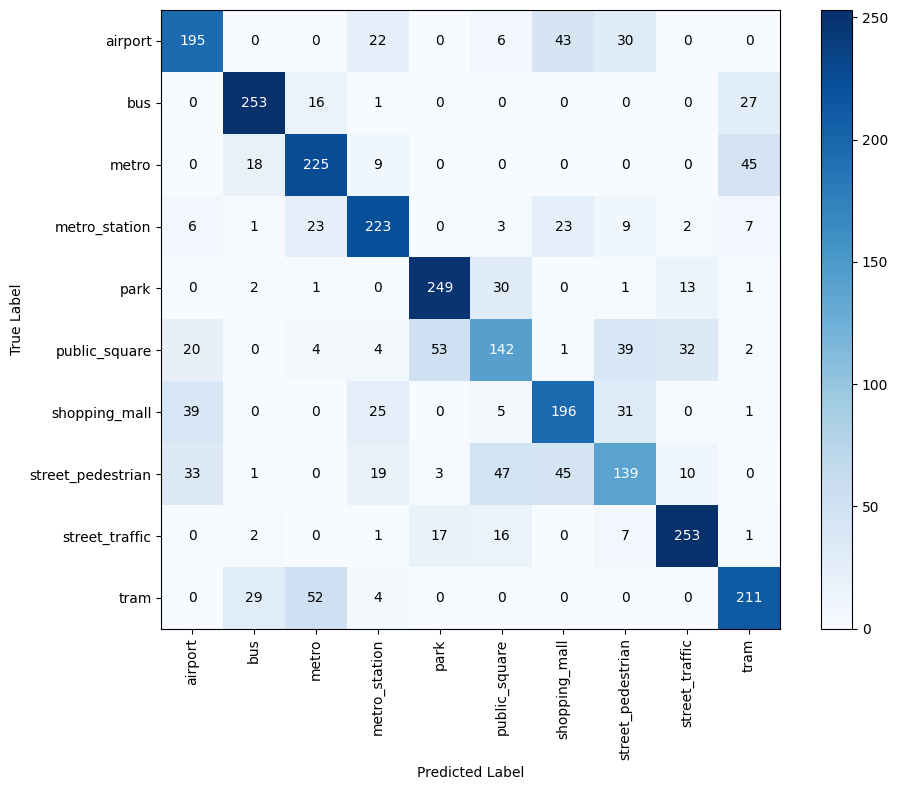

Accuracy: 0.7028


In [303]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

In [304]:
# df.to_csv(fr'{run_mode}_predictions.csv')

# Accuracy plot per block 

In [305]:
acc_list

[0.24225067385444743,
 0.4511455525606469,
 0.522911051212938,
 0.5731132075471698,
 0.6408355795148248,
 0.6580188679245284,
 0.6772237196765498,
 0.6923854447439353,
 0.6960916442048517,
 0.7008086253369272,
 0.7095687331536388,
 0.7028301886792453]

In [306]:
# acc_list=[0.2065,0.3807,0.4660,0.5270,0.5799,0.6112,0.6449,0.6445,0.6597,0.6584,0.6580,0.6614]
# acc_list=[0.2392,0.4579,0.5273,0.5630,0.6287,0.6513,0.6752,0.6863,0.6883,0.7042,0.7032,0.7018]

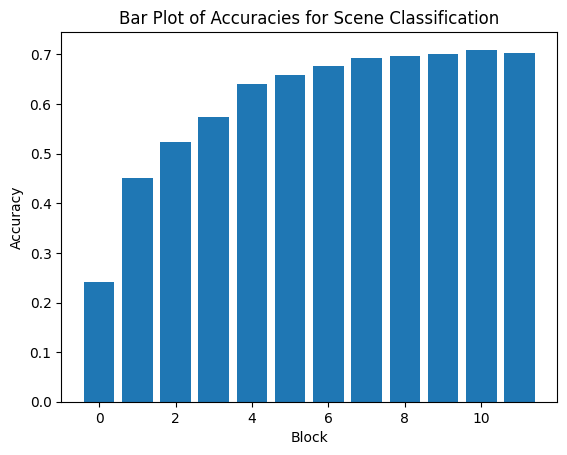

In [307]:
import matplotlib.pyplot as plt

# Example list of numbers
numbers = acc_list

# Create the plot
plt.bar(range(len(numbers)), numbers)

# Add labels and title
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Accuracies for Scene Classification')

# Display the plot
plt.show()
